# Setup

In [3]:
# Import packages
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import copy
import collections
import theano
import theano.tensor as tt
from sklearn.svm import LinearSVC
from sklearn.model_selection import PredefinedSplit, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')

import pickle
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

demo of make_vonmises function:


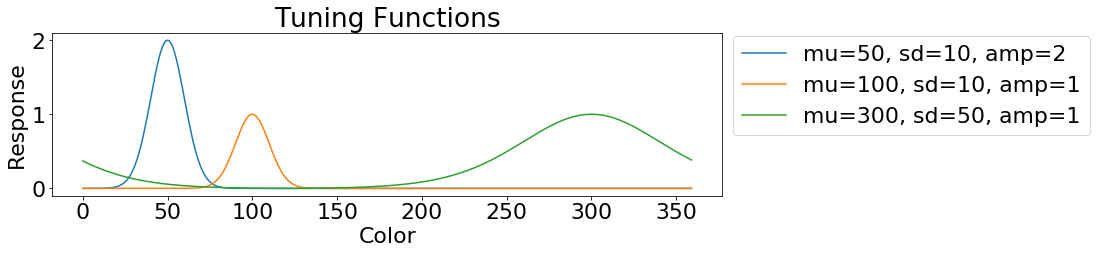

In [5]:
# change default plotting
plt.rcParams.update({'font.size': 22, 'figure.figsize': (12,3)})

# Convenience functions
k2sd = lambda k : np.sqrt( -2 * np.log( sp.special.iv(1,k) / sp.special.iv(0,k) ) )

def sd2k(S):
    try:
        len(S)
    except:
        S = np.array([S])
    R = np.exp(-S**2/2)
    K = 1/(R**3 - 4 * R**2 + 3 * R)
    if np.any(R < 0.85):
        K[R < 0.85] = -0.4 + 1.39 * R[R < 0.85] + 0.43/(1 - R[R < 0.85])
    if np.any(R < 0.53):
        K[R < 0.53] = 2 * R[R < 0.53] + R[R < 0.53]**3 + (5 * R[R < 0.53]**5)/6
    if len(S) == 1:
        K = float(K)
    return K

def inverse_transform(x,f_range=360,samps=5000):
    X=[]
    for f in range(f_range):
        X=np.concatenate((X,np.repeat(f,np.ceil(x[f]*samps))))
    if len(X) < samps:
        X=[]
        for f in range(f_range):
            X=np.concatenate((X,np.repeat(f,np.ceil(x[f]*(samps+samps/5)))))
    return np.random.choice(X,samps,replace=False)

def dim_reduce(x):
    least_freq_feature = collections.Counter(x).most_common()[-1][0]
    least_freq_feature_cnt = len(x[x==least_freq_feature])
    y = [];
    for f in np.unique(x):
        y = np.concatenate((y,np.repeat(f,len(x[x==f])-least_freq_feature_cnt)))
    return y

def half_dim_reduce(x):
    least_freq_feature = collections.Counter(x).most_common()[-1][0]
    least_freq_feature_cnt = len(x[x==least_freq_feature])/2
    y = [];
    for f in np.unique(x):
        y = np.concatenate((y,np.repeat(f,len(x[x==f])-least_freq_feature_cnt)))
    return y

def third_dim_reduce(x):
    least_freq_feature = collections.Counter(x).most_common()[-1][0]
    least_freq_feature_cnt = 2/3 * len(x[x==least_freq_feature])
    y = [];
    for f in np.unique(x):
        y = np.concatenate((y,np.repeat(f,len(x[x==f])-least_freq_feature_cnt)))
    return y

def wrap360(a,b):
    try:
        len(a);len(b);
    except:
        a = np.array([a]); b= np.array([b])
    diff = np.full(len(a),np.nan)
    for k in np.arange(len(a)):
        diff[k] = b[k] - a[k]
        if diff[k] < -180:
            diff[k] = b[k] - a[k] + 360
        elif diff[k] > 180:
            diff[k] = b[k] - a[k] - 360
    return diff

# def wrap360(a,b):
#     i = np.abs(diff) > (360 / 2.0)
#     out = diff.copy()
#     out[i] -= np.sign(diff[i]) * 360
#     return out

def within360(y):
    x = copy.deepcopy(y)
    try:
        len(x)
    except:
        x = np.array([x])
    x[x>359] = x[x>359]-360
    x[x>359] = x[x>359]-360
    x[x<0] = x[x<0]+360
    return x

import numpy as np

def normalize(x):
    if np.any(np.isnan((x - np.min(x)) / (np.max(x) - np.min(x)))):
        return x
    else:
        return (x - np.min(x)) / (np.max(x) - np.min(x))    
    
def norm0(x):
    return x / np.max(x)

def betw01(x):
    if (x>1):
        x=1
    elif (x<0):
        x=0
    return x

def sumfix(x):
    if (np.min(x)<0):
        x = x - np.min(x)
    return x / np.sum(x)

def within180(x):
    x[x<0] = x[x<0]+360
    x[x>180] = x[x>180]-360
    return np.abs(x)

def within_pi(k):
    while (np.any(k<-np.pi) or np.any(k>np.pi)):
        k[k>np.pi] -= np.pi*2
        k[k<-np.pi] += np.pi*2
    return k

def within_pi30(k):
    while (np.any(k<-np.deg2rad(30)) or np.any(k>np.deg2rad(30))):
        k[k>np.deg2rad(30)] -= np.deg2rad(60)
        k[k<-np.deg2rad(30)] += np.deg2rad(60)
    return k

def in360_scalar(x):
    while x>359:
        x=x-360
    while x<0:
        x=x+360
    return x

def basis_features(basis_points,trial_features):
    b = np.argmin(np.abs(np.subtract.outer(np.concatenate([basis_points,[basis_points[0]+360]]), trial_features)),axis=0)
    b[b==np.max(b)]=0
    return b

def circmean(samples, high=359, low=0, axis=None, weights=None):
    """
    Compute the circular mean for samples in a range, allowing for input weights
    Edited from scipy.stats.circmean by Paul Scotti to allow for weighting
    """
    samples = np.asarray(samples)

    # Recast samples as radians that range between 0 and 2 pi
    sin_samp = sp.sin((samples - low)*2.*np.pi / (high - low))
    cos_samp = sp.cos((samples - low)*2.*np.pi / (high - low))

    if weights is not None:
        weights = weights / np.sum(weights)
        sin_samp = sin_samp * weights / scl
        cos_samp = cos_samp * weights / scl

    sin_sum = sin_samp.sum(axis=axis)
    cos_sum = cos_samp.sum(axis=axis)

    res = sp.arctan2(sin_sum, cos_sum)

    if res < low and high > np.pi:
        res += np.deg2rad(high+1)

    return np.round(res*(high - low)/2.0/np.pi + low,6)

def make_vonmises(xx,mu,sd,amp=1):
    res = np.exp(sd2k(np.deg2rad(sd))*np.cos(np.deg2rad(xx-mu)))/(2*np.pi*sp.special.i0(sd2k(np.deg2rad(sd))))
    res[np.isnan(res)] = 0 # if requesting a stick function (very small sd), return a stick function
    if np.all(res==0):
        res[int(np.floor(mu))] = amp
    norm_res = (res - np.min(res)) / (np.max(res) - np.min(res)) 
    return norm_res * amp

def make_vonmises_iter(xx,mu,sd,amp):
    res1 = np.full( (360,len(mu)) , np.nan)
    for i in range(len(mu)):
        res = np.exp(sd2k(np.deg2rad(sd[i]))*np.cos(np.deg2rad(xx-mu[i])))/(2*np.pi*sp.special.i0(sd2k(np.deg2rad(sd[i]))))
        res[np.isnan(res)] = 0 
        if np.all(res==0):
            res[int(np.floor(mu[i]))] = amp[i]
        norm_res = (res - np.min(res)) / (np.max(res) - np.min(res)) 
        res1[:,i] = norm_res * amp[i]
    return res1

def make_vonmises_iter2(xx,mu,sd,amp):
    res1 = np.full( (360,len(mu)) , np.nan)
    for i in range(len(mu)):
        res = np.exp(sd2k(np.deg2rad(sd[i]))*np.cos(np.deg2rad(xx-mu[i])))/(2*np.pi*sp.special.i0(sd2k(np.deg2rad(sd[i]))))
        res[np.isnan(res)] = 0 
        if np.all(res==0):
            res[int(np.floor(mu[i]))] = amp[i]
        norm_res = (res - np.min(res)) / (np.max(res) - np.min(res)) 
        res1[:,i] = norm_res * amp[i]
    for x in xx:
        res1[int(x),:] = norm0(res1[int(x),:])
    return res1

def make_vonmises_iter_unif(xx,mu,sd,unif,amp):
    res1 = np.full( (360,len(mu)+1) , np.nan)
    for i in range(len(mu)):
        res = np.exp(sd2k(np.deg2rad(sd[i]))*np.cos(np.deg2rad(xx-mu[i])))/(2*np.pi*sp.special.i0(sd2k(np.deg2rad(sd[i]))))
        res[np.isnan(res)] = 0 
        if np.all(res==0):
            res[int(np.floor(mu[i]))] = amp[i]
        norm_res = (res - np.min(res)) / (np.max(res) - np.min(res)) 
        res1[:,i] = norm_res * amp[i]
    res1[:,-1] = np.ones(360)*unif
#     for x in xx:
#         res1[int(x),:] = normalize0(res1[int(x),:])
    return res1
    
print('demo of make_vonmises function:')
plt.plot(make_vonmises(np.linspace(0,359,360),50,10,[2]),label="mu=50, sd=10, amp=2")
plt.plot(make_vonmises(np.linspace(0,359,360),100,10,[1]),label="mu=100, sd=10, amp=1")
plt.plot(make_vonmises(np.linspace(0,359,360),300,50,[1]),label="mu=300, sd=50, amp=1")
plt.xlabel('Color')
plt.ylabel('Response')
plt.legend(bbox_to_anchor=(1, 1.05))
plt.title("Tuning Functions")
plt.show()

In [6]:
### function to automate voxel simulation ###
def sim_vox(plotting=0):
    # Simulate voxels 
    trial_features = np.concatenate([within360(np.random.permutation(np.arange(ntrials//2))),
                                     within360(np.random.permutation(np.arange(ntrials//2)))])
#     for t in range(ntrials):
#         if trial_features[t] < 60:
#             trial_features[t] = np.random.randint(300)+60
#     trial_features = np.array([np.arange(360),np.arange(360)]).flatten()
    trial_conds = np.tile(np.array([0,1]),ntrials//2)
    trial_by_vox = np.full((ntrials,nvoxels),np.nan)
    trial_by_id = np.full((ntrials,nvoxels),np.nan)
    trial_by_trial = np.full((ntrials,nvoxels),np.nan)
    for vox in np.arange(nvoxels):
        vox_tuning = make_vonmises( 
            np.linspace(0,359,360),
            vox_mu[vox],
            vox_sd[vox],
            vox_amp[vox])
        for trial in range(ntrials):
            vox_w_noise = vox_tuning[trial_features[trial]] + (np.random.rand()*vox_noise)
            vox_w_noise_and_gain = vox_w_noise * (trial_conds[trial]*vox_gain_diff + 1)
            trial_by_vox[trial,vox] = np.sum(vox_w_noise_and_gain)
            trial_by_trial[trial,vox] = trial
            trial_by_id[trial,vox] = vox
    
    # use trial_by_vox and trial_features to obtain an "observed" distribution for later MCMC/VI
    # I think this is called inverse transform sampling?
    vox_betas = trial_by_vox.flatten()
    vox_id = trial_by_id.flatten()
    vox_trial = trial_by_trial.flatten()
    features = np.repeat(trial_features,nvoxels)
        
    if plotting:
        with plt.rc_context(rc={'font.size': 14, 'figure.figsize': (12,1)}):
            plt.hist(vox_mu,bins=30)
            plt.ylabel('Count')
            plt.title("Each voxel's maximal color preference")
            plt.show()
            plt.hist(vox_amp,bins=30)
            plt.ylabel('Count')
            plt.title("Each voxels's amplitude if maximal stimulus")
            plt.show()
            plt.hist(vox_sd,bins=30)
            plt.ticklabel_format(useOffset=False)
            plt.ylabel('Count')
            plt.title("Each voxel's sd of tuning function")
            plt.show()
    return np.array(trial_features), trial_conds, vox_betas, features, vox_id, vox_trial, trial_by_vox


In [7]:
# def try_recon(basis_points,channel_sd,trial_features):
#     basis_points = correct_basis(basis_points,nchannels)
#     basis_set = make_vonmises_iter(feature_space, basis_points, channel_sd) 
# #     trial_weights = basis_set[trial_features,:]
#     trial_weights = [basis_set[t,:][np.argmax(basis_set[t,:])] for t in trial_features]
#     trial_weights = trial_weights - np.abs(np.min(trial_weights))
#     return trial_weights

# def auto_recon(basis_points,channel_sd,trial_features,trial_by_vox):   
#     # create each basis channel
#     basis_points = correct_basis(basis_points,nchannels)
#     basis_set = make_vonmises_iter(feature_space, basis_points, channel_sd) 
#     trial_weights = basis_set[trial_features,:]
#     trial_weights = trial_weights / np.sum(trial_weights)

#     X = np.linspace(0,ntrials-1,ntrials)
#     train_index = list(map(int,np.sort(X[:len(X)//2])))
#     test_index = list(map(int,np.sort(X[len(X)//2:])))

#     saved_weights = np.linalg.lstsq(trial_weights[train_index,:], trial_by_vox[train_index,:], rcond=None)[0] 
#     # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

#     # Invert to compute channel responses
#     cr_tst = np.linalg.lstsq(saved_weights.T , trial_by_vox[test_index,:].T, rcond=None)[0].T

#     # Avg. reconstructions (testing)
#     trial_actual = trial_features[test_index]
#     trial_guess = basis_points[np.argmax(cr_tst,axis=1)]
#     trial_conf = np.max(cr_tst,axis=1)
# #     trial_conf = (np.max(cr_tst,axis=1) - np.min(np.max(cr_tst,axis=1))) / (np.max(np.max(cr_tst,axis=1)) - np.min(np.max(cr_tst,axis=1)))
# #     trial_guess = basis_points[[int(np.random.choice(np.linspace(0,nchannels-1,nchannels),p=cr_tst[t,:]/np.sum(cr_tst[t,:]))) for t in range(ntrials//2)]]
#     trial_diff = within180(trial_actual-trial_guess)
# #     trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
#     tst_rmse = np.sqrt(np.mean((trial_diff*trial_conf)**2))
    
#     # Plot simulated voxel tunings:              
#     ground_truth_set = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis,np.ones(nchannels)*vox_sd_mu,vox_amp_basis)
#     plt.plot(ground_truth_set/np.max(ground_truth_set))
#     plt.ylabel('Response')
#     plt.xlabel('Color')
#     plt.yticks([])
#     # Plot reconstructed basis sets:
#     r_amps = np.full((nvoxels,2),np.nan)
#     for vox in range(nvoxels):
#         chan = np.argmin(np.abs(np.subtract.outer(np.concatenate([basis_points,[basis_points[0]+360]]), sp.stats.circmean(trial_features[np.argsort(trial_by_vox[:,vox])[-30:]],low=0,high=359))),axis=0)
#         if chan >= nchannels:
#             chan = 0
#         r_amps[vox,:] = chan,np.max(trial_by_vox[np.isin(trial_features,np.where(basis_set[:,chan]>np.max(basis_set[:,chan])/2)),vox])
#     recon_amps = []
#     for chan in range(nchannels):
#         recon_amps.append(np.mean(r_amps[:,1][r_amps[:,0]==chan]))
#     plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
#     r_basis_set = make_vonmises_iter(feature_space, basis_points, channel_sd, recon_amps)
#     plt.plot(r_basis_set/np.max(r_basis_set),':',linewidth=5,alpha=.5)
#     plt.show()
#     # Plot actual voxel tunings
#     for vox in np.arange(nvoxels):
#         if vox <= 50:
#             plt.scatter(trial_features,trial_by_vox[:,vox])
#     plt.xlabel('Color')
#     plt.ylabel('Response')
#     plt.yticks([])
#     plt.title('First 50 Voxel Responses')
#     plt.show()
#     print(tst_rmse)
#     print(np.mean(trial_diff))
    
#     return tst_rmse

# def auto_recon_old(basis_points,channel_sd,trial_features,trial_by_vox,n_splits=2):   
#     # create each basis channel
#     basis_set = make_vonmises(feature_space, basis_points, channel_sd)
#     trial_weights = basis_set[trial_features,:]
    
#     cv_iter = -1
#     for n in range(n_splits):
#         X = np.linspace(0,ntrials-1,np.sum(ntrials))
#         train_index = list(map(int,np.sort(X[:len(X)//2])))
#         test_index = list(map(int,np.sort(X[len(X)//2:])))

#         if cv_iter == -1:
#             tstf=[];
#             cr_tst = np.full((n_splits,len(test_index),nchannels),np.nan)
#         cv_iter = cv_iter + 1

#         tstf.append(trial_features[test_index])
#         trn_or_tst = np.zeros(len(trial_features))
#         trn_or_tst[test_index] = 1

#         saved_weights = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trial_by_vox[train_index,:], rcond=None)[0] 
#         # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

#         # Invert to compute channel responses
#         cr_tst[cv_iter,:,:] = np.linalg.lstsq(saved_weights.T , trial_by_vox[test_index,:].T, rcond=None)[0].T

#     # collapse folds
#     tstf = np.array(tstf).flatten()
#     cr_tst = cr_tst.reshape(cr_tst.shape[1]*n_splits,nchannels)
#     #full_saved_weights = np.linalg.lstsq(trial_weights, trial_by_vox, rcond=None)[0] 

#     # Plot perfect reconstruction for comparison
#     shiftby = nchannels//2
#     perfect_recon = trial_weights[np.where(trial_features==shiftby*(360/nchannels))[0][0],:]

#     # Avg. reconstructions (testing)
#     cr_center_tst = np.empty_like(cr_tst)
#     trial_actual = np.full(cr_tst.shape[0],999)
#     trial_guess = np.full(cr_tst.shape[0],999)
#     for trial in np.arange(cr_tst.shape[0]):
#         trial_actual[trial] = np.argmin(np.abs(within180(basis_points - tstf[trial])))
#         trial_guess[trial] = np.argmax(cr_tst[trial,:])
#         cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
#     trial_diff = np.abs(trial_actual-trial_guess)
#     trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
#     trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
#     tst_mae = np.mean(trial_diff)

#     return tst_mae

# def auto_recon_plotting(basis_points,channel_sd,trial_features,trial_by_vox,n_splits=2):   
#     # create each basis channel
#     basis_points = correct_basis(basis_points,nchannels)
#     basis_set = make_vonmises(feature_space, basis_points, channel_sd)
#     trial_weights = basis_set[trial_features,:]
    
#     cv_iter = -1
#     for n in range(n_splits):
#         X = np.linspace(0,ntrials-1,np.sum(ntrials))
#         train_index = list(map(int,np.sort(X[:len(X)//2])))
#         test_index = list(map(int,np.sort(X[len(X)//2:])))

#         if cv_iter == -1:
#             trn=[];tst=[];trnf=[];tstf=[];
#             cr_trn = np.full((n_splits,len(train_index),nchannels),np.nan)
#             cr_tst = np.full((n_splits,len(test_index),nchannels),np.nan)
#         cv_iter = cv_iter + 1

#         trnf.append(trial_features[train_index])
#         tstf.append(trial_features[test_index])
#         trn_or_tst = np.zeros(len(trial_features))
#         trn_or_tst[test_index] = 1

#         saved_weights = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trial_by_vox[train_index,:], rcond=None)[0] 
#         # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

#         # Invert to compute channel responses
#         cr_trn[cv_iter,:,:] = np.linalg.lstsq(saved_weights.T , trial_by_vox[train_index,:].T, rcond=None)[0].T
#         cr_tst[cv_iter,:,:] = np.linalg.lstsq(saved_weights.T , trial_by_vox[test_index,:].T, rcond=None)[0].T

#     # collapse folds
#     trnf = np.array(trnf).flatten()
#     tstf = np.array(tstf).flatten()
#     cr_trn = cr_trn.reshape(cr_trn.shape[1]*n_splits,nchannels)
#     cr_tst = cr_tst.reshape(cr_tst.shape[1]*n_splits,nchannels)
#     #full_saved_weights = np.linalg.lstsq(trial_weights, trial_by_vox, rcond=None)[0] 

#     # Plot perfect reconstruction for comparison
#     shiftby = nchannels//2
            
#     # Avg. reconstructions (training)
#     cr_center_trn = np.empty_like(cr_trn)
#     trial_actual = np.full(cr_trn.shape[0],999)
#     trial_guess = np.full(cr_trn.shape[0],999)
#     trial_actual = basis_features(basis_points,trnf)
#     for trial in np.arange(cr_trn.shape[0]):
#         trial_guess[trial] = np.argmax(cr_trn[trial,:])
#         cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - trial_actual[trial]);
#     trial_diff = np.abs(trial_actual-trial_guess)
#     trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
# #     trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
#     trn_mae = np.mean(trial_diff)

#     # Avg. reconstructions (testing)
#     cr_center_tst = np.empty_like(cr_tst)
#     trial_actual = np.full(cr_tst.shape[0],999)
#     trial_guess = np.full(cr_tst.shape[0],999)
#     trial_actual = basis_features(basis_points,tstf)
#     for trial in np.arange(cr_tst.shape[0]):
#         trial_guess[trial] = np.argmax(cr_tst[trial,:])
#         cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
#     trial_diff = np.abs(trial_actual-trial_guess)
#     trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
# #     trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
#     tst_mae = np.mean(trial_diff)

#     # Null distribution testing
#     numperms = 1000
#     cr_center_null = np.empty_like(cr_tst)
#     trial_actual = np.full(cr_tst.shape[0],999)
#     trial_guess = np.full(cr_tst.shape[0],999)
#     null_mae = np.full(numperms,np.nan)
#     for perm in np.arange(numperms):
#         tstf_shuffle = np.random.permutation(tstf)
#         trial_actual = basis_features(basis_points,tstf_shuffle)
#         for trial in np.arange(cr_tst.shape[0]):
#             trial_guess[trial] = np.argmax(cr_tst[trial,:])
#             cr_center_null[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
#         trial_diff = np.abs(trial_actual-trial_guess)
#         trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
# #         trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
#         null_mae[perm] = np.mean(trial_diff)

#     trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae)*100
#     tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae)*100

#     # Plotting
#     print("train: avg MAE: {}".format(trn_mae))
#     plt.plot(np.mean(cr_center_tst,axis=0),color='r')
#     plt.title("Test")
#     plt.xlabel("Color")
#     plt.ylabel("Channel Response")
#     plt.show()    
#     plt.plot(np.mean(cr_center_trn,axis=0),color='b',label="Train")
#     plt.plot(np.mean(cr_center_tst,axis=0),color='r',label="Test")
#     plt.plot(np.mean(cr_center_null,axis=0),color='gray',label="Null")
#     plt.title("All Reconstructions (overlaid)")
#     plt.xlabel("Color")
#     plt.ylabel("Channel Response")
#     plt.legend()
#     plt.show()
#     print("test: avg MAE: {}".format(tst_mae))
#     sns.distplot(null_mae,color='gray',bins=10)
#     plt.axvline(trn_mae,color='blue',label="Train MAE")
#     plt.axvline(tst_mae,color='red',label="Test MAE")
#     plt.axvline(np.mean(null_mae),linestyle=':',color='gray',label="Null")
#     plt.legend(bbox_to_anchor=(1, 1.05))
#     plt.text(trn_mae,1,"{:.2f}%".format(trn_overlap),color='blue')
#     plt.text(tst_mae,.25,"{:.2f}%".format(tst_overlap),color='red')
#     plt.xlim([0,2])
#     plt.show()
#     print("null: avg MAE: {}".format(np.mean(null_mae)))
#     print("% overlap w/ null distribution ({} permutations): {}%".format(numperms,tst_overlap))
#     print("basically, this means p={:.3f}".format(tst_overlap/100))
#     if tst_overlap < 5:
#         print("meaning that test reconstructions are significantly different from null reconstructions.")
#     else:
#         print("meaning that test reconstructions are not significantly different from null reconstructions.")
#     # Plot simulated voxel tunings:              
#     ground_truth_set = make_vonmises(np.linspace(0,359,360),vox_mu_basis,np.ones(nchannels)*vox_sd_mu,vox_amp_basis)
#     plt.plot(ground_truth_set/np.max(ground_truth_set))
#     plt.ylabel('Response')
#     plt.xlabel('Color')
#     plt.yticks([])
#     # Plot reconstructed basis sets:
#     r_amps = np.full((nvoxels,2),np.nan)
#     for vox in range(nvoxels):
#         chan = np.argmin(np.abs(np.subtract.outer(np.concatenate([basis_points,[basis_points[0]+360]]), sp.stats.circmean(trial_features[np.argsort(trial_by_vox[:,vox])[-30:]],low=0,high=359))),axis=0)
#         if chan >= nchannels:
#             chan = 0
#         #chan = np.argmin(np.abs(within180(basis_points - np.median(trial_features[np.argsort(trial_by_vox[:,vox])[-30:]]))))
#         r_amps[vox,:] = chan,np.max(trial_by_vox[np.isin(trial_features,np.where(basis_set[:,chan]>np.max(basis_set[:,chan])/2)),vox])
#     #r_amps[:,1] = r_amps[:,1]/np.max(r_amps[:,1])
#     recon_amps = []
#     for chan in range(nchannels):
#         recon_amps.append(np.mean(r_amps[:,1][r_amps[:,0]==chan]))
#     plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
#     r_basis_set = make_vonmises(feature_space, basis_points, channel_sd, recon_amps)
#     plt.plot(r_basis_set/np.max(r_basis_set),':',linewidth=5,alpha=.5)
#     plt.show()
#     print("null mae range: {},{}".format(np.min(null_mae),np.max(null_mae)))
#     print("null_mae - tst_mae (larger positive number is better): {}".format(np.mean(null_mae - tst_mae)))
#     print("tst_mae - trn_mae (smaller number is better): {}".format(np.mean(tst_mae - trn_mae)))
#     return tst_mae, tst_overlap

# def auto_recon_plotting_old(basis_points,channel_sd,trial_features,trial_by_vox,n_splits=2):   
#     # create each basis channel
#     basis_points = correct_basis(basis_points,nchannels)
#     basis_set = make_vonmises(feature_space, basis_points, channel_sd)
#     trial_weights = basis_set[trial_features,:]
    
#     cv_iter = -1
#     for n in range(n_splits):
#         X = np.linspace(0,ntrials-1,np.sum(ntrials))
#         train_index = list(map(int,np.sort(X[:len(X)//2])))
#         test_index = list(map(int,np.sort(X[len(X)//2:])))

#         if cv_iter == -1:
#             trn=[];tst=[];trnf=[];tstf=[];
#             cr_trn = np.full((n_splits,len(train_index),nchannels),np.nan)
#             cr_tst = np.full((n_splits,len(test_index),nchannels),np.nan)
#         cv_iter = cv_iter + 1

#         trnf.append(trial_features[train_index])
#         tstf.append(trial_features[test_index])
#         trn_or_tst = np.zeros(len(trial_features))
#         trn_or_tst[test_index] = 1

#         saved_weights = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trial_by_vox[train_index,:], rcond=None)[0] 
#         # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

#         # Invert to compute channel responses
#         cr_trn[cv_iter,:,:] = np.linalg.lstsq(saved_weights.T , trial_by_vox[train_index,:].T, rcond=None)[0].T
#         cr_tst[cv_iter,:,:] = np.linalg.lstsq(saved_weights.T , trial_by_vox[test_index,:].T, rcond=None)[0].T

#     # collapse folds
#     trnf = np.array(trnf).flatten()
#     tstf = np.array(tstf).flatten()
#     cr_trn = cr_trn.reshape(cr_trn.shape[1]*n_splits,nchannels)
#     cr_tst = cr_tst.reshape(cr_tst.shape[1]*n_splits,nchannels)
#     #full_saved_weights = np.linalg.lstsq(trial_weights, trial_by_vox, rcond=None)[0] 

#     # Plot perfect reconstruction for comparison
#     shiftby = nchannels//2
#     perfect_recon = basis_set[int(basis_points[shiftby]),:]
#     perfect_recon = perfect_recon / np.max(perfect_recon)
#     if np.argmax(perfect_recon) != shiftby:
#         raise ValueError('Shiftby Error')
            
#     # Avg. reconstructions (training)
#     cr_center_trn = np.empty_like(cr_trn)
#     trial_actual = np.full(cr_trn.shape[0],999)
#     trial_guess = np.full(cr_trn.shape[0],999)
#     trial_actual = basis_features(basis_points,trnf)
#     for trial in np.arange(cr_trn.shape[0]):
#         trial_guess[trial] = np.argmax(cr_trn[trial,:])
#         cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - trial_actual[trial]);
#     trial_diff = np.abs(trial_actual-trial_guess)
#     trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
#     trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
#     trn_mae = np.mean(trial_diff)

#     # Avg. reconstructions (testing)
#     cr_center_tst = np.empty_like(cr_tst)
#     trial_actual = np.full(cr_tst.shape[0],999)
#     trial_guess = np.full(cr_tst.shape[0],999)
#     trial_actual = basis_features(basis_points,tstf)
#     for trial in np.arange(cr_tst.shape[0]):
#         trial_guess[trial] = np.argmax(cr_tst[trial,:])
#         cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
#     trial_diff = np.abs(trial_actual-trial_guess)
#     trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
#     trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
#     tst_mae = np.mean(trial_diff)

#     # Null distribution testing
#     numperms = 1000
#     cr_center_null = np.empty_like(cr_tst)
#     trial_actual = np.full(cr_tst.shape[0],999)
#     trial_guess = np.full(cr_tst.shape[0],999)
#     null_mae = np.full(numperms,np.nan)
#     for perm in np.arange(numperms):
#         tstf_shuffle = np.random.permutation(tstf)
#         trial_actual = basis_features(basis_points,tstf_shuffle)
#         for trial in np.arange(cr_tst.shape[0]):
#             trial_guess[trial] = np.argmax(cr_tst[trial,:])
#             cr_center_null[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
#         trial_diff = np.abs(trial_actual-trial_guess)
#         trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
#         trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
#         null_mae[perm] = np.mean(trial_diff)

#     trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae)*100
#     tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae)*100

#     # Plotting
#     print("Reconstructions aligned at {} \n".format(shiftby))
#     plt.plot(perfect_recon,color='k')
#     plt.title("Perfect Reconstruction (for comparison)")
#     plt.xlabel("Color")
#     plt.ylabel("Channel Response")
#     plt.show()
#     plt.plot(np.mean(cr_center_trn,axis=0),color='b')
#     plt.title("Train")
#     plt.xlabel("Color")
#     plt.ylabel("Channel Response")
#     plt.show()
#     print("train: avg MAE: {}".format(trn_mae))
#     plt.plot(np.mean(cr_center_tst,axis=0),color='r')
#     plt.title("Test")
#     plt.xlabel("Color")
#     plt.ylabel("Channel Response")
#     plt.show()    
#     plt.plot(np.mean(cr_center_trn,axis=0),color='b',label="Train")
#     plt.plot(np.mean(cr_center_tst,axis=0),color='r',label="Test")
#     plt.plot(np.mean(cr_center_null,axis=0),color='gray',label="Null")
#     plt.title("All Reconstructions (overlaid)")
#     plt.xlabel("Color")
#     plt.ylabel("Channel Response")
#     plt.legend()
#     plt.show()
#     print("test: avg MAE: {}".format(tst_mae))
#     sns.distplot(null_mae,color='gray',bins=10)
#     plt.axvline(trn_mae,color='blue',label="Train MAE")
#     plt.axvline(tst_mae,color='red',label="Test MAE")
#     plt.axvline(np.mean(null_mae),linestyle=':',color='gray',label="Null")
#     plt.legend(bbox_to_anchor=(1, 1.05))
#     plt.text(trn_mae,1,"{:.2f}%".format(trn_overlap),color='blue')
#     plt.text(tst_mae,.25,"{:.2f}%".format(tst_overlap),color='red')
#     plt.xlim([0,1])
#     plt.show()
#     print("null: avg MAE: {}".format(np.mean(null_mae)))
#     print("% overlap w/ null distribution ({} permutations): {}%".format(numperms,tst_overlap))
#     print("basically, this means p={:.3f}".format(tst_overlap/100))
#     if tst_overlap < 5:
#         print("meaning that test reconstructions are significantly different from null reconstructions.")
#     else:
#         print("meaning that test reconstructions are not significantly different from null reconstructions.")
#     # Plot simulated voxel tunings:              
#     ground_truth_set = make_vonmises(np.linspace(0,359,360),vox_mu_basis,np.ones(nchannels)*vox_sd_mu,vox_amp_basis)
#     plt.plot(ground_truth_set/np.max(ground_truth_set))
#     plt.ylabel('Response')
#     plt.xlabel('Color')
#     plt.yticks([])
#     # Plot reconstructed basis sets:
#     r_amps = np.full((nvoxels,2),np.nan)
#     for vox in range(nvoxels):
#         chan = np.argmin(np.abs(np.subtract.outer(np.concatenate([basis_points,[basis_points[0]+360]]), sp.stats.circmean(trial_features[np.argsort(trial_by_vox[:,vox])[-30:]],low=0,high=359))),axis=0)
#         if chan >= nchannels:
#             chan = 0
#         #chan = np.argmin(np.abs(within180(basis_points - np.median(trial_features[np.argsort(trial_by_vox[:,vox])[-30:]]))))
#         r_amps[vox,:] = chan,np.max(trial_by_vox[np.isin(trial_features,np.where(basis_set[:,chan]>np.max(basis_set[:,chan])/2)),vox])
#     #r_amps[:,1] = r_amps[:,1]/np.max(r_amps[:,1])
#     recon_amps = []
#     for chan in range(nchannels):
#         recon_amps.append(np.mean(r_amps[:,1][r_amps[:,0]==chan]))
#     plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
#     r_basis_set = make_vonmises(feature_space, basis_points, channel_sd, recon_amps)
#     plt.plot(r_basis_set/np.max(r_basis_set),':',linewidth=5,alpha=.5)
#     plt.show()
#     print("null mae range: {},{}".format(np.min(null_mae),np.max(null_mae)))
#     print("null_mae - tst_mae (larger positive number is better): {}".format(np.mean(null_mae - tst_mae)))
#     print("tst_mae - trn_mae (smaller number is better): {}".format(np.mean(tst_mae - trn_mae)))
#     return tst_mae, tst_overlap
    
# def plot_basis_avg(basis_points,channel_sd,trial_features,chan_pow=np.ones(nchannels)/nchannels): 
#     # reset default matplotlib color picker
#     plt.gca().set_prop_cycle(None)
    
#     # create each basis channel
#     basis_set = make_vonmises(feature_space, basis_points, channel_sd, chan_pow)
        
#     # plot basis functions
#     for chan in np.arange(nchannels):
#         plt.plot(basis_set[:,chan])

#     plt.xlabel('Color')
#     plt.ylabel('Response')
#     plt.yticks([])
#     plt.title("Reconstructed Basis Set",color='green') 
    
# def plot_basis_dotted(basis_points,channel_sd,trial_features,chan_pow=np.ones(nchannels)/nchannels): 
#     # reset default matplotlib color picker
#     plt.gca().set_prop_cycle(None)
    
#     # create each basis channel
#     basis_set = make_vonmises(feature_space, basis_points, channel_sd, chan_pow)
        
#     # plot basis functions
#     for chan in np.arange(nchannels):
#         plt.plot(basis_set[:,chan],':')

In [274]:
def generative_model(name,obs,widths,nchannels,means=1,
                     trn=None,trnf=None,tst=None,tstf=None,
                     vi=True,samples=10000,
                     initonly=False,viz=True,iem=True,null=False,standard=False):
    import pymc3 as pm
    
    ## Custom changes to PyMC3 to work with -pi to pi continuous bounds
    from theano.compile.ops import as_op
    # allow pymc3 to use scipy's modified bessel function
    @as_op(itypes=[tt.dscalar], otypes=[tt.dscalar])
    def k2sd_to_deg_op(k):
        return np.rad2deg(np.sqrt( -2 * np.log( sp.special.iv(1,k) / sp.special.iv(0,k) ) ))
    # see this thread's last post for what this code does: 
    # https://discourse.pymc.io/t/how-does-pymc3-interpret-von-mises-boundaries/4453/7
    from pymc3.distributions.distribution import (Continuous, draw_values, generate_samples)
    from pymc3.distributions import transforms
    from pymc3.theanof import floatX
    from pymc3.distributions.special import log_i0
    from pymc3.distributions.dist_math import (
        alltrue_elemwise, betaln, bound, gammaln, i0e, incomplete_beta, logpow,
        normal_lccdf, normal_lcdf, SplineWrapper, std_cdf, zvalue)
    def assert_negative_support(var, label, distname, value=-1e-6):
        # Checks for evidence of positive support for a variable
        if var is None:
            return
        try:
            # Transformed distribution
            support = np.isfinite(var.transformed.distribution.dist
                                  .logp(value).tag.test_value)
        except AttributeError:
            try:
                # Untransformed distribution
                support = np.isfinite(var.distribution.logp(value).tag.test_value)
            except AttributeError:
                # Otherwise no direct evidence of non-positive support
                support = False

        if np.any(support):
            msg = "The variable specified for {0} has negative support for {1}, ".format(
                label, distname)
            msg += "likely making it unsuitable for this parameter."
            warnings.warn(msg)
    class VonMises(Continuous):
        R"""
        Univariate VonMises log-likelihood.

        The pdf of this distribution is

        .. math::

            f(x \mid \mu, \kappa) =
                \frac{e^{\kappa\cos(x-\mu)}}{2\pi I_0(\kappa)}

        where :math:`I_0` is the modified Bessel function of order 0.

        .. plot::

            import matplotlib.pyplot as plt
            import numpy as np
            import scipy.stats as st
            plt.style.use('seaborn-darkgrid')
            x = np.linspace(-np.pi, np.pi, 200)
            mus = [0., 0., 0.,  -2.5]
            kappas = [.01, 0.5,  4., 2.]
            for mu, kappa in zip(mus, kappas):
                pdf = st.vonmises.pdf(x, kappa, loc=mu)
                plt.plot(x, pdf, label=r'$\mu$ = {}, $\kappa$ = {}'.format(mu, kappa))
            plt.xlabel('x', fontsize=12)
            plt.ylabel('f(x)', fontsize=12)
            plt.legend(loc=1)
            plt.show()

        ========  ==========================================
        Support   :math:`x \in [-\pi, \pi]`
        Mean      :math:`\mu`
        Variance  :math:`1-\frac{I_1(\kappa)}{I_0(\kappa)}`
        ========  ==========================================

        Parameters
        ----------
        mu : float
            Mean.
        kappa : float
            Concentration (\frac{1}{kappa} is analogous to \sigma^2).
        """

        def __init__(self, mu=0.0, kappa=None, transform='circular',
                     *args, **kwargs):
            if transform == 'circular':
                transform = transforms.Circular()
            super().__init__(transform=transform, *args, **kwargs)
            self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
            self.kappa = kappa = tt.as_tensor_variable(floatX(kappa))

            assert_negative_support(kappa, 'kappa', 'VonMises')

        def random(self, point=None, size=None):
            """
            Draw random values from VonMises distribution.

            Parameters
            ----------
            point : dict, optional
                Dict of variable values on which random values are to be
                conditioned (uses default point if not specified).
            size : int, optional
                Desired size of random sample (returns one sample if not
                specified).

            Returns
            -------
            array
            """
            mu, kappa = draw_values([self.mu, self.kappa],
                                    point=point, size=size)
            return within_pi(generate_samples(sp.stats.vonmises.rvs, loc=mu, kappa=kappa,
                                    dist_shape=self.shape,
                                    size=size))

        def logp(self, value):
            """
            Calculate log-probability of VonMises distribution at specified value.

            Parameters
            ----------
            value : numeric
                Value(s) for which log-probability is calculated. If the log probabilities for multiple
                values are desired the values must be provided in a numpy array or theano tensor

            Returns
            -------
            TensorVariable
            """
            mu = self.mu
            kappa = self.kappa
            return bound(kappa * tt.cos(mu - value) - (tt.log(2 * np.pi) + log_i0(kappa)),
                         kappa > 0, value >= -np.pi, value <= np.pi)
    class BoundedContinuous(Continuous):
        """Base class for bounded continuous distributions"""

        def __init__(self, transform='auto', lower=None, upper=None,
                     *args, **kwargs):

            lower = tt.as_tensor_variable(lower) if lower is not None else None
            upper = tt.as_tensor_variable(upper) if upper is not None else None

            if transform == 'auto':
                if lower is None and upper is None:
                    transform = None
                elif lower is not None and upper is None:
                    transform = transforms.lowerbound(lower)
                elif lower is None and upper is not None:
                    transform = transforms.upperbound(upper)
                else:
                    transform = transforms.interval(lower, upper)

            super().__init__(transform=transform, *args, **kwargs)
    class Uniform(BoundedContinuous):
        R"""
        Continuous uniform log-likelihood.

        The pdf of this distribution is

        .. math::

           f(x \mid lower, upper) = \frac{1}{upper-lower}

        .. plot::

            import matplotlib.pyplot as plt
            import numpy as np
            plt.style.use('seaborn-darkgrid')
            x = np.linspace(-3, 3, 500)
            ls = [0., -2]
            us = [2., 1]
            for l, u in zip(ls, us):
                y = np.zeros(500)
                y[(x<u) & (x>l)] = 1.0/(u-l)
                plt.plot(x, y, label='lower = {}, upper = {}'.format(l, u))
            plt.xlabel('x', fontsize=12)
            plt.ylabel('f(x)', fontsize=12)
            plt.ylim(0, 1)
            plt.legend(loc=1)
            plt.show()

        ========  =====================================
        Support   :math:`x \in [lower, upper]`
        Mean      :math:`\dfrac{lower + upper}{2}`
        Variance  :math:`\dfrac{(upper - lower)^2}{12}`
        ========  =====================================

        Parameters
        ----------
        lower : float
            Lower limit.
        upper : float
            Upper limit.
        """

        def __init__(self, lower=0, upper=1, *args, **kwargs):
            self.lower = lower = tt.as_tensor_variable(floatX(lower))
            self.upper = upper = tt.as_tensor_variable(floatX(upper))
            self.mean = (upper + lower) / 2.
            self.median = self.mean

            super().__init__(lower=lower, upper=upper, *args, **kwargs)

        def random(self, point=None, size=None):
            """
            Draw random values from Uniform distribution.

            Parameters
            ----------
            point : dict, optional
                Dict of variable values on which random values are to be
                conditioned (uses default point if not specified).
            size : int, optional
                Desired size of random sample (returns one sample if not
                specified).

            Returns
            -------
            array
            """

            lower, upper = draw_values([self.lower, self.upper],
                                       point=point, size=size)
            return within_pi(generate_samples(stats.uniform.rvs, loc=lower,
                                    scale=upper - lower,
                                    dist_shape=self.shape,
                                    size=size))

        def logp(self, value):
            """
            Calculate log-probability of Uniform distribution at specified value.

            Parameters
            ----------
            value : numeric
                Value for which log-probability is calculated.

            Returns
            -------
            TensorVariable
            """
            lower = self.lower
            upper = self.upper
            return bound(-tt.log(upper - lower),
                         value >= lower, value <= upper)

        def logcdf(self, value):
            """
            Compute the log of the cumulative distribution function for Uniform distribution
            at the specified value.

            Parameters
            ----------
            value: numeric
                Value(s) for which log CDF is calculated. If the log CDF for multiple
                values are desired the values must be provided in a numpy array or theano tensor.

            Returns
            -------
            TensorVariable
            """
            return tt.switch(
                tt.or_(tt.lt(value, self.lower), tt.gt(value, self.upper)),
                -np.inf,
                tt.switch(
                    tt.eq(value, self.upper),
                    0,
                    tt.log((value - self.lower)) -
                    tt.log((self.upper - self.lower))
                )
            )
    pm.VonMises = VonMises
    pm.Uniform = Uniform
    
    if standard==False:
        print(widths,nchannels,means)
        if ((widths>1) & (widths!=nchannels)):
            print("widths={}, nchannels={}".format(widths,means,nchannels))
            raise Exception('Check parameters. Set kappa to 1 for single shared parameter, or set equal to nchannels for individual parameters per channel')
        if vi==True:
            if means==0:
                print('cur_model: {}_{}k_fixedmu_{}chan_vi'.format(name,widths,nchannels))
            else:
                print('cur_model: {}_{}k_{}chan_vi'.format(name,widths,nchannels))
            X = pm.Minibatch(obs, batch_size=500)
        else:
            if means==0:
                print('cur_model: {}_{}k_fixedmu_{}chan'.format(name,widths,nchannels))
            else:
                print('cur_model: {}_{}k_{}chan'.format(name,widths,nchannels))
        with pm.Model() as cur_model:   
            if widths==1:
                # shared precision parameter per channel, bounded 20-160 deg sd [sd2k(np.deg2rad(160))]
                # prior MAP = 60 sd (deg.)
                kappas = pm.Bound(pm.Gamma,lower = 0.0405,upper = 8.733)('kappas',2.,.7)
            elif widths==nchannels:
                # separate precision parameters per channel
                kappas = [pm.Bound(pm.Gamma,
                       lower = 0.0405, # 160 deg sd [sd2k(np.deg2rad(160))]
                       upper = 8.733) # 20 deg sd
                 ('kappa_%d' % i,2.,.7)
                 for i in range(nchannels)]

            if means==0:
                # fixed mu for each channel
                mus = tt.real(np.deg2rad(np.linspace(0,(360-(360/nchannels)),nchannels))-np.pi)
            elif means==1:
                mushift = pm.Uniform('mushift',lower=-(2*np.pi/nchannels)/4,upper=(2*np.pi/nchannels)/4)
                mus = tt.real(np.deg2rad(np.linspace(0,(360-(360/nchannels)),nchannels))-np.pi)+mushift
            else:
                # bounded uniform distribution per channel mu
                mus = [pm.Uniform('mu_%d' % i, 
                               lower = (2*np.pi)/nchannels*i - np.pi - (np.pi/nchannels) - np.pi/5,
                               upper = (2*np.pi)/nchannels*i + (2*np.pi)/nchannels - np.pi - (np.pi/nchannels) + np.pi/5)
                   for i in range(nchannels)]

            # uniform weights for each mixture component
            if nchannels==1:
                p = [1.]
            else:
                p = pm.Dirichlet('p', a=np.array([1.]*(nchannels)))

            # mixture components
            if nchannels==1:
                if means==0:
                    dists = [
                        pm.VonMises.dist(mu=mus,kappa=kappas),
                    ]
                else:
                    dists = [
                        pm.VonMises.dist(mu=mus[0],kappa=kappas),
                    ]
            elif nchannels==2:
                if widths==1:
                    dists = [
                        pm.VonMises.dist(mu=mus[0],kappa=kappas),
                        pm.VonMises.dist(mu=mus[1],kappa=kappas),
                    ]
                elif widths==nchannels:
                    dists = [
                        pm.VonMises.dist(mu=mus[0],kappa=kappas[0]),
                        pm.VonMises.dist(mu=mus[1],kappa=kappas[1]),
                    ]
            elif nchannels==3:
                if widths==1:
                    dists = [
                        pm.VonMises.dist(mu=mus[0],kappa=kappas),
                        pm.VonMises.dist(mu=mus[1],kappa=kappas),
                        pm.VonMises.dist(mu=mus[2],kappa=kappas),
                    ]
                elif widths==nchannels:
                    dists = [
                        pm.VonMises.dist(mu=mus[0],kappa=kappas[0]),
                        pm.VonMises.dist(mu=mus[1],kappa=kappas[1]),
                        pm.VonMises.dist(mu=mus[2],kappa=kappas[2]),
                    ]
            elif nchannels==4:
                if widths==1:
                    dists = [
                        pm.VonMises.dist(mu=mus[0],kappa=kappas),
                        pm.VonMises.dist(mu=mus[1],kappa=kappas),
                        pm.VonMises.dist(mu=mus[2],kappa=kappas),
                        pm.VonMises.dist(mu=mus[3],kappa=kappas),
                    ]
                elif widths==nchannels:
                    dists = [
                        pm.VonMises.dist(mu=mus[0],kappa=kappas[0]),
                        pm.VonMises.dist(mu=mus[1],kappa=kappas[1]),
                        pm.VonMises.dist(mu=mus[2],kappa=kappas[2]),
                        pm.VonMises.dist(mu=mus[3],kappa=kappas[3]),
                    ]
            elif nchannels==5:
                if widths==1:
                    dists = [
                        pm.VonMises.dist(mu=mus[0],kappa=kappas),
                        pm.VonMises.dist(mu=mus[1],kappa=kappas),
                        pm.VonMises.dist(mu=mus[2],kappa=kappas),
                        pm.VonMises.dist(mu=mus[3],kappa=kappas),
                        pm.VonMises.dist(mu=mus[4],kappa=kappas),
                    ]
                elif widths==nchannels:
                    dists = [
                        pm.VonMises.dist(mu=mus[0],kappa=kappas[0]),
                        pm.VonMises.dist(mu=mus[1],kappa=kappas[1]),
                        pm.VonMises.dist(mu=mus[2],kappa=kappas[2]),
                        pm.VonMises.dist(mu=mus[3],kappa=kappas[3]),
                        pm.VonMises.dist(mu=mus[4],kappa=kappas[4]),
                    ]
            elif nchannels==6:
                if widths==1:
                    dists = [
                        pm.VonMises.dist(mu=mus[0],kappa=kappas),
                        pm.VonMises.dist(mu=mus[1],kappa=kappas),
                        pm.VonMises.dist(mu=mus[2],kappa=kappas),
                        pm.VonMises.dist(mu=mus[3],kappa=kappas),
                        pm.VonMises.dist(mu=mus[4],kappa=kappas),
                        pm.VonMises.dist(mu=mus[5],kappa=kappas),
                    ]
                elif widths==nchannels:
                    dists = [
                        pm.VonMises.dist(mu=mus[0],kappa=kappas[0]),
                        pm.VonMises.dist(mu=mus[1],kappa=kappas[1]),
                        pm.VonMises.dist(mu=mus[2],kappa=kappas[2]),
                        pm.VonMises.dist(mu=mus[3],kappa=kappas[3]),
                        pm.VonMises.dist(mu=mus[4],kappa=kappas[4]),
                        pm.VonMises.dist(mu=mus[5],kappa=kappas[5]),
                    ]
            elif nchannels==7:
                if widths==1:
                    dists = [
                        pm.VonMises.dist(mu=mus[0],kappa=kappas),
                        pm.VonMises.dist(mu=mus[1],kappa=kappas),
                        pm.VonMises.dist(mu=mus[2],kappa=kappas),
                        pm.VonMises.dist(mu=mus[3],kappa=kappas),
                        pm.VonMises.dist(mu=mus[4],kappa=kappas),
                        pm.VonMises.dist(mu=mus[5],kappa=kappas),
                        pm.VonMises.dist(mu=mus[6],kappa=kappas),
                    ]
                elif widths==nchannels:
                    dists = [
                        pm.VonMises.dist(mu=mus[0],kappa=kappas[0]),
                        pm.VonMises.dist(mu=mus[1],kappa=kappas[1]),
                        pm.VonMises.dist(mu=mus[2],kappa=kappas[2]),
                        pm.VonMises.dist(mu=mus[3],kappa=kappas[3]),
                        pm.VonMises.dist(mu=mus[4],kappa=kappas[4]),
                        pm.VonMises.dist(mu=mus[5],kappa=kappas[5]),
                        pm.VonMises.dist(mu=mus[6],kappa=kappas[6]),
                    ]
            elif nchannels==8:
                if widths==1:
                    dists = [
                        pm.VonMises.dist(mu=mus[0],kappa=kappas),
                        pm.VonMises.dist(mu=mus[1],kappa=kappas),
                        pm.VonMises.dist(mu=mus[2],kappa=kappas),
                        pm.VonMises.dist(mu=mus[3],kappa=kappas),
                        pm.VonMises.dist(mu=mus[4],kappa=kappas),
                        pm.VonMises.dist(mu=mus[5],kappa=kappas),
                        pm.VonMises.dist(mu=mus[6],kappa=kappas),
                        pm.VonMises.dist(mu=mus[7],kappa=kappas),
                    ]
                elif widths==nchannels:
                    dists = [
                        pm.VonMises.dist(mu=mus[0],kappa=kappas[0]),
                        pm.VonMises.dist(mu=mus[1],kappa=kappas[1]),
                        pm.VonMises.dist(mu=mus[2],kappa=kappas[2]),
                        pm.VonMises.dist(mu=mus[3],kappa=kappas[3]),
                        pm.VonMises.dist(mu=mus[4],kappa=kappas[4]),
                        pm.VonMises.dist(mu=mus[5],kappa=kappas[5]),
                        pm.VonMises.dist(mu=mus[6],kappa=kappas[6]),
                        pm.VonMises.dist(mu=mus[7],kappa=kappas[7]),
                    ]
            elif nchannels==9:
                if widths==1:
                    dists = [
                        pm.VonMises.dist(mu=mus[0],kappa=kappas),
                        pm.VonMises.dist(mu=mus[1],kappa=kappas),
                        pm.VonMises.dist(mu=mus[2],kappa=kappas),
                        pm.VonMises.dist(mu=mus[3],kappa=kappas),
                        pm.VonMises.dist(mu=mus[4],kappa=kappas),
                        pm.VonMises.dist(mu=mus[5],kappa=kappas),
                        pm.VonMises.dist(mu=mus[6],kappa=kappas),
                        pm.VonMises.dist(mu=mus[7],kappa=kappas),
                        pm.VonMises.dist(mu=mus[8],kappa=kappas),
                    ]
                elif widths==nchannels:
                    dists = [
                        pm.VonMises.dist(mu=mus[0],kappa=kappas[0]),
                        pm.VonMises.dist(mu=mus[1],kappa=kappas[1]),
                        pm.VonMises.dist(mu=mus[2],kappa=kappas[2]),
                        pm.VonMises.dist(mu=mus[3],kappa=kappas[3]),
                        pm.VonMises.dist(mu=mus[4],kappa=kappas[4]),
                        pm.VonMises.dist(mu=mus[5],kappa=kappas[5]),
                        pm.VonMises.dist(mu=mus[6],kappa=kappas[6]),
                        pm.VonMises.dist(mu=mus[7],kappa=kappas[7]),
                        pm.VonMises.dist(mu=mus[8],kappa=kappas[8]),
                    ]
            elif nchannels==10:
                if widths==1:
                    dists = [
                        pm.VonMises.dist(mu=mus[0],kappa=kappas),
                        pm.VonMises.dist(mu=mus[1],kappa=kappas),
                        pm.VonMises.dist(mu=mus[2],kappa=kappas),
                        pm.VonMises.dist(mu=mus[3],kappa=kappas),
                        pm.VonMises.dist(mu=mus[4],kappa=kappas),
                        pm.VonMises.dist(mu=mus[5],kappa=kappas),
                        pm.VonMises.dist(mu=mus[6],kappa=kappas),
                        pm.VonMises.dist(mu=mus[7],kappa=kappas),
                        pm.VonMises.dist(mu=mus[8],kappa=kappas),
                        pm.VonMises.dist(mu=mus[9],kappa=kappas),
                    ]
                elif widths==nchannels:
                    dists = [
                        pm.VonMises.dist(mu=mus[0],kappa=kappas[0]),
                        pm.VonMises.dist(mu=mus[1],kappa=kappas[1]),
                        pm.VonMises.dist(mu=mus[2],kappa=kappas[2]),
                        pm.VonMises.dist(mu=mus[3],kappa=kappas[3]),
                        pm.VonMises.dist(mu=mus[4],kappa=kappas[4]),
                        pm.VonMises.dist(mu=mus[5],kappa=kappas[5]),
                        pm.VonMises.dist(mu=mus[6],kappa=kappas[6]),
                        pm.VonMises.dist(mu=mus[7],kappa=kappas[7]),
                        pm.VonMises.dist(mu=mus[8],kappa=kappas[8]),
                        pm.VonMises.dist(mu=mus[9],kappa=kappas[9]),
                    ]
            else:
                raise Exception('Currently generative_model only supports up to 10 channels!')

            # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
            if means<=1:
                mus_deg = pm.Deterministic('mu_deg',np.rad2deg(mus)+180)
            else:
                mus_deg = [pm.Deterministic('mu_deg_%d' % i,
                                          np.rad2deg(mus[i]+np.pi))
                          for i in range(nchannels)]
            # Convenience transform: kappa (in radians) to sd (in degrees)
            if widths==1:
                sds = pm.Deterministic('sd_deg', k2sd_to_deg_op(kappas))
            elif widths==nchannels:
                sds = [pm.Deterministic('sd_deg_%d' % i,
                        k2sd_to_deg_op(kappas[i]))
                        for i in range(nchannels)]

            # Specify the likelihood
            if vi==False:
                y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs)
            else:
                y = pm.Mixture('y', w=p, comp_dists=dists, observed=X, total_size=obs.shape)  

            # Sample and save posterior?
            if initonly==False:
                if vi==False:
                    print("starting sampling...")
                    # Start sampling
                    posterior = pm.sample(samples, tune=samples, chains=3)
                    # Save posterior
                    if means==False:
                        pm.save_trace(posterior,
                        "posteriors/{}_{}k_fixedmu_{}chan".format(name,widths,nchannels),overwrite=True)
                    else:
                        pm.save_trace(posterior,
                        "posteriors/{}_{}k_{}chan".format(name,widths,nchannels),overwrite=True)
                else:
                    print("starting approximation...")
                    approx = pm.FullRankADVI()
                    approx.fit(samples)
                    posterior = approx.approx.sample(1000)
                    # Save posterior
                    if means==False:
                        pm.save_trace(posterior,
                            "posteriors/{}_{}k_fixedmu_{}chan_vi".format(name,widths,nchannels),overwrite=True)
                    else:
                        pm.save_trace(posterior,
                            "posteriors/{}_{}k_{}chan_vi".format(name,widths,nchannels),overwrite=True)

    if initonly==False:
        # Plot estimated voxel tunings
        if standard==False:
            if means==0:
                vox_mu_basis_r = [circmean(posterior['mu_deg'][:,chan]) for chan in range(nchannels)]
            elif means==1:
                vox_mu_basis_r = [circmean(posterior['mu_deg'][:,chan]) for chan in range(nchannels)]
            else:
                vox_mu_basis_r = [circmean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
            if widths==1:
                channel_sd_r = np.ones(nchannels)*np.mean(posterior['sd_deg'])
            elif widths==nchannels:
                channel_sd_r = [np.mean(posterior['sd_deg_{}'.format(chan)]) for chan in range(nchannels)]
            if nchannels==1:
                vox_amp_basis_r = [1]
            else:
                vox_amp_basis_r = np.ones(nchannels)/nchannels
#                 vox_amp_basis_r = [np.mean(posterior['p'][:,chan]) for chan in range(nchannels)]
            print(vox_mu_basis_r);print(channel_sd_r);print(vox_amp_basis_r)
            basis_set = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
        else:
            vox_mu_basis_r = np.linspace(0,(360-(360/nchannels)),nchannels)
            channel_sd_r = 60*np.ones(nchannels)
            vox_amp_basis_r = np.ones(nchannels)/nchannels
        basis_set = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)

        if viz==True:
            plt.plot(basis_set)
            plt.title('Estimated voxel basis') 
            plt.ylabel('Proportion')
            # plt.ylim([0,1])
            plt.xlabel('Feature')

            if standard==False:
                ## Plot 95% HDIs
                colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
                # plot mu HDI intervals
                if means==1:
                    mu_prior = np.deg2rad(np.linspace(0,(360-(360/nchannels)),nchannels))-np.pi
                    vox_mu_basis_r0 = [np.rad2deg(pm.stats.hpd(posterior['mushift'],hdi_prob=0.95,circular=True)[0]+np.pi+mu_prior[chan]) for chan in range(nchannels)]
                    vox_mu_basis_r1 = [np.rad2deg(pm.stats.hpd(posterior['mushift'],hdi_prob=0.95,circular=True)[1]+np.pi+mu_prior[chan]) for chan in range(nchannels)]
                    for chan in range(nchannels):
                        plt.axvline(within360(vox_mu_basis_r0[chan]),linestyle=':',linewidth=3,alpha=.3,color=colors[chan])
                        plt.axvline(within360(vox_mu_basis_r1[chan]),linestyle=':',linewidth=3,alpha=.3,color=colors[chan])
                elif means==True:
                    vox_mu_basis_r0 = [np.rad2deg(pm.stats.hpd(posterior['mu_{}'.format(chan)],hdi_prob=0.95,circular=True)[0]+np.pi) for chan in range(nchannels)]
                    vox_mu_basis_r1 = [np.rad2deg(pm.stats.hpd(posterior['mu_{}'.format(chan)],hdi_prob=0.95,circular=True)[1]+np.pi) for chan in range(nchannels)]
                    for chan in range(nchannels):
                        plt.axvline(within360(vox_mu_basis_r0[chan]),linestyle=':',linewidth=3,alpha=.3,color=colors[chan])
                        plt.axvline(within360(vox_mu_basis_r1[chan]),linestyle=':',linewidth=3,alpha=.3,color=colors[chan])
                # plot sd HDI intervals
                if widths==1:
                    channel_sd_r0 = np.ones(nchannels)*pm.stats.hpd(posterior['sd_deg'],hdi_prob=0.95)[0]
                    channel_sd_r1 = np.ones(nchannels)*pm.stats.hpd(posterior['sd_deg'],hdi_prob=0.95)[1]
                else:
                    channel_sd_r0 = [pm.stats.hpd(posterior['sd_deg_{}'.format(chan)],hdi_prob=0.95)[0] for chan in range(nchannels)]
                    channel_sd_r1 = [pm.stats.hpd(posterior['sd_deg_{}'.format(chan)],hdi_prob=0.95)[1] for chan in range(nchannels)]
                basis0 = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r0,vox_amp_basis_r)
                basis1 = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r1,vox_amp_basis_r)
                plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
                for chan in np.arange(nchannels):
                    plt.fill_between(np.arange(360), 
                                     np.array([basis0[i,chan] for i in np.arange(len(basis0))]), 
                                     np.array([basis1[i,chan] for i in np.arange(len(basis1))]), 
                                     alpha=0.2, color=colors[chan])
                # # plot amp HDI intervals 
#                 if nchannels>1:
#                     vox_amp_basis_r0 = [pm.stats.hpd(posterior['p'],hdi_prob=0.95)[chan][0] for chan in range(nchannels)]
#                     vox_amp_basis_r1 = [pm.stats.hpd(posterior['p'],hdi_prob=0.95)[chan][1] for chan in range(nchannels)]
#                     plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
#                     for chan in np.arange(nchannels):
#                         plt.vlines(x=vox_mu_basis_r[chan],ymin=vox_amp_basis_r0[chan],ymax=vox_amp_basis_r1[chan],color=colors[chan])
                # # add text for mus
                # for chan in np.arange(nchannels):
                #     plt.text(vox_mu_basis_r[chan],0,'{:.2f}'.format(vox_mu_basis_r[chan]),
                #             horizontalalignment='center',fontsize=16,color=colors[chan],
                #             bbox=dict(facecolor='white',edgecolor='white'))
                if vi==False:
                    if means==False:
                        plt.savefig("posteriors/{}_{}k_fixedmu_{}chan.png".format(name,widths,nchannels), format='png', dpi=300)
                    else:
                        plt.savefig("posteriors/{}_{}k_{}chan.png".format(name,widths,nchannels), format='png', dpi=300)
                else:
                    if means==False:
                        plt.savefig("posteriors/{}_{}k_fixedmu_{}chan_vi.png".format(name,widths,nchannels), format='png', dpi=300)
                    else:
                        plt.savefig("posteriors/{}_{}k_{}chan_vi.png".format(name,widths,nchannels), format='png', dpi=300)
            else:
                plt.savefig("posteriors/{}_prior_{}chan.png".format(name,nchannels), format='png', dpi=300)
            plt.show()

        if iem==True:
            print("inverting model...")
            trial_weights = basis_set[trnf,:]
            channelweights_per_vox = np.linalg.lstsq(trial_weights, trn, rcond=None)[0] 
            cr_trn = np.linalg.lstsq(channelweights_per_vox.T , trn.T, rcond=None)[0].T
            cr_tst = np.linalg.lstsq(channelweights_per_vox.T , tst.T, rcond=None)[0].T
            # train reconstruction (warning: this is double-dipping/circular)
            cr_center_trn = np.empty_like(cr_trn[:,:])
            estimated_color_trn = np.full(cr_center_trn.shape[0],np.nan)
            for trial in np.arange(cr_trn.shape[0]):
                closest_basis = np.argmin(np.abs(wrap360(np.repeat(trnf[trial],nchannels), vox_mu_basis_r)))
                cr_center_trn[trial,:] = np.roll(cr_trn[trial,:], nchannels//2 - closest_basis);
                bs=make_vonmises_iter(np.linspace(0,359,360),
                                    vox_mu_basis_r,
                                    channel_sd_r,
                                    cr_trn[trial,:])
                estimated_color_trn[trial] = np.argmax(np.sum(bs,axis=1))
            trn_err = np.abs(wrap360(estimated_color_trn, trnf))
            # test reconstruction
            cr_center_tst = np.empty_like(cr_tst[:,:])
            estimated_color_tst = np.full(cr_center_tst.shape[0],np.nan)
            for trial in np.arange(cr_tst.shape[0]):
                closest_basis = np.argmin(np.abs(wrap360(np.repeat(tstf[trial],nchannels), vox_mu_basis_r)))
                cr_center_tst[trial,:] = np.roll(cr_tst[trial,:], nchannels//2 - closest_basis);
                bs=make_vonmises_iter(np.linspace(0,359,360),
                                    vox_mu_basis_r,
                                    channel_sd_r,
                                    cr_tst[trial,:])
                estimated_color_tst[trial] = np.argmax(np.sum(bs,axis=1))
            tst_err = np.abs(wrap360(estimated_color_tst, tstf))
            if null:
                # null permutation testing
                print("null permutation testing...")
                estimated_color_null = np.full(cr_tst.shape[0],np.nan)
                null_err = np.full(100,np.nan)
                for perm in np.arange(100):
                    shuffled_tst = np.random.permutation(tst)
                    cr_shuffle_tst = np.linalg.lstsq(channelweights_per_vox.T , shuffled_tst.T, rcond=None)[0].T
                    for trial in np.arange(cr_shuffle_tst.shape[0]):
                        bs=make_vonmises_iter(np.linspace(0,359,360),
                                            vox_mu_basis_r,
                                            channel_sd_r,
                                            cr_shuffle_tst[trial,:])
                        estimated_color_null[trial] = np.argmax(np.sum(bs,axis=1))
                    null_err[perm] = np.mean(np.abs(wrap360(estimated_color_null, tstf)))
    print('Done!')
    if initonly:
        return cur_model
    elif iem and standard:
        if null:
            return trn_err, tst_err, null_err
        else:
            return trn_err, tst_err
    elif iem:
        if null:
            return trn_err, tst_err, null_err, posterior
        else:
            return trn_err, tst_err, posterior
    else:
        return posterior

In [7]:
## Custom changes to PyMC3 to work with -pi to pi continuous bounds
from theano.compile.ops import as_op
# allow pymc3 to use scipy's modified bessel function
@as_op(itypes=[tt.dscalar], otypes=[tt.dscalar])
def k2sd_to_deg_op(k):
    return np.rad2deg(np.sqrt( -2 * np.log( sp.special.iv(1,k) / sp.special.iv(0,k) ) ))
# see this thread's last post for what this code does: 
# https://discourse.pymc.io/t/how-does-pymc3-interpret-von-mises-boundaries/4453/7
from pymc3.distributions.distribution import (Continuous, draw_values, generate_samples)
from pymc3.distributions import transforms
from pymc3.theanof import floatX
from pymc3.distributions.special import log_i0
from pymc3.distributions.dist_math import (
    alltrue_elemwise, betaln, bound, gammaln, i0e, incomplete_beta, logpow,
    normal_lccdf, normal_lcdf, SplineWrapper, std_cdf, zvalue)
def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False

    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)
class VonMises(Continuous):
    R"""
    Univariate VonMises log-likelihood.

    The pdf of this distribution is

    .. math::

        f(x \mid \mu, \kappa) =
            \frac{e^{\kappa\cos(x-\mu)}}{2\pi I_0(\kappa)}

    where :math:`I_0` is the modified Bessel function of order 0.

    .. plot::

        import matplotlib.pyplot as plt
        import numpy as np
        import scipy.stats as st
        plt.style.use('seaborn-darkgrid')
        x = np.linspace(-np.pi, np.pi, 200)
        mus = [0., 0., 0.,  -2.5]
        kappas = [.01, 0.5,  4., 2.]
        for mu, kappa in zip(mus, kappas):
            pdf = st.vonmises.pdf(x, kappa, loc=mu)
            plt.plot(x, pdf, label=r'$\mu$ = {}, $\kappa$ = {}'.format(mu, kappa))
        plt.xlabel('x', fontsize=12)
        plt.ylabel('f(x)', fontsize=12)
        plt.legend(loc=1)
        plt.show()

    ========  ==========================================
    Support   :math:`x \in [-\pi, \pi]`
    Mean      :math:`\mu`
    Variance  :math:`1-\frac{I_1(\kappa)}{I_0(\kappa)}`
    ========  ==========================================

    Parameters
    ----------
    mu : float
        Mean.
    kappa : float
        Concentration (\frac{1}{kappa} is analogous to \sigma^2).
    """

    def __init__(self, mu=0.0, kappa=None, transform='circular',
                 *args, **kwargs):
        if transform == 'circular':
            transform = transforms.Circular()
        super().__init__(transform=transform, *args, **kwargs)
        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.kappa = kappa = tt.as_tensor_variable(floatX(kappa))

        assert_negative_support(kappa, 'kappa', 'VonMises')

    def random(self, point=None, size=None):
        """
        Draw random values from VonMises distribution.

        Parameters
        ----------
        point : dict, optional
            Dict of variable values on which random values are to be
            conditioned (uses default point if not specified).
        size : int, optional
            Desired size of random sample (returns one sample if not
            specified).

        Returns
        -------
        array
        """
        mu, kappa = draw_values([self.mu, self.kappa],
                                point=point, size=size)
        return within_pi(generate_samples(sp.stats.vonmises.rvs, loc=mu, kappa=kappa,
                                dist_shape=self.shape,
                                size=size))

    def logp(self, value):
        """
        Calculate log-probability of VonMises distribution at specified value.

        Parameters
        ----------
        value : numeric
            Value(s) for which log-probability is calculated. If the log probabilities for multiple
            values are desired the values must be provided in a numpy array or theano tensor

        Returns
        -------
        TensorVariable
        """
        mu = self.mu
        kappa = self.kappa
        return bound(kappa * tt.cos(mu - value) - (tt.log(2 * np.pi) + log_i0(kappa)),
                     kappa > 0, value >= -np.pi, value <= np.pi)
class BoundedContinuous(Continuous):
    """Base class for bounded continuous distributions"""

    def __init__(self, transform='auto', lower=None, upper=None,
                 *args, **kwargs):

        lower = tt.as_tensor_variable(lower) if lower is not None else None
        upper = tt.as_tensor_variable(upper) if upper is not None else None

        if transform == 'auto':
            if lower is None and upper is None:
                transform = None
            elif lower is not None and upper is None:
                transform = transforms.lowerbound(lower)
            elif lower is None and upper is not None:
                transform = transforms.upperbound(upper)
            else:
                transform = transforms.interval(lower, upper)

        super().__init__(transform=transform, *args, **kwargs)
class Uniform(BoundedContinuous):
    R"""
    Continuous uniform log-likelihood.

    The pdf of this distribution is

    .. math::

       f(x \mid lower, upper) = \frac{1}{upper-lower}

    .. plot::

        import matplotlib.pyplot as plt
        import numpy as np
        plt.style.use('seaborn-darkgrid')
        x = np.linspace(-3, 3, 500)
        ls = [0., -2]
        us = [2., 1]
        for l, u in zip(ls, us):
            y = np.zeros(500)
            y[(x<u) & (x>l)] = 1.0/(u-l)
            plt.plot(x, y, label='lower = {}, upper = {}'.format(l, u))
        plt.xlabel('x', fontsize=12)
        plt.ylabel('f(x)', fontsize=12)
        plt.ylim(0, 1)
        plt.legend(loc=1)
        plt.show()

    ========  =====================================
    Support   :math:`x \in [lower, upper]`
    Mean      :math:`\dfrac{lower + upper}{2}`
    Variance  :math:`\dfrac{(upper - lower)^2}{12}`
    ========  =====================================

    Parameters
    ----------
    lower : float
        Lower limit.
    upper : float
        Upper limit.
    """

    def __init__(self, lower=0, upper=1, *args, **kwargs):
        self.lower = lower = tt.as_tensor_variable(floatX(lower))
        self.upper = upper = tt.as_tensor_variable(floatX(upper))
        self.mean = (upper + lower) / 2.
        self.median = self.mean

        super().__init__(lower=lower, upper=upper, *args, **kwargs)

    def random(self, point=None, size=None):
        """
        Draw random values from Uniform distribution.

        Parameters
        ----------
        point : dict, optional
            Dict of variable values on which random values are to be
            conditioned (uses default point if not specified).
        size : int, optional
            Desired size of random sample (returns one sample if not
            specified).

        Returns
        -------
        array
        """

        lower, upper = draw_values([self.lower, self.upper],
                                   point=point, size=size)
        return within_pi(generate_samples(stats.uniform.rvs, loc=lower,
                                scale=upper - lower,
                                dist_shape=self.shape,
                                size=size))

    def logp(self, value):
        """
        Calculate log-probability of Uniform distribution at specified value.

        Parameters
        ----------
        value : numeric
            Value for which log-probability is calculated.

        Returns
        -------
        TensorVariable
        """
        lower = self.lower
        upper = self.upper
        return bound(-tt.log(upper - lower),
                     value >= lower, value <= upper)

    def logcdf(self, value):
        """
        Compute the log of the cumulative distribution function for Uniform distribution
        at the specified value.

        Parameters
        ----------
        value: numeric
            Value(s) for which log CDF is calculated. If the log CDF for multiple
            values are desired the values must be provided in a numpy array or theano tensor.

        Returns
        -------
        TensorVariable
        """
        return tt.switch(
            tt.or_(tt.lt(value, self.lower), tt.gt(value, self.upper)),
            -np.inf,
            tt.switch(
                tt.eq(value, self.upper),
                0,
                tt.log((value - self.lower)) -
                tt.log((self.upper - self.lower))
            )
        )
      
pm.VonMises = VonMises
pm.Uniform = Uniform

## blackbox

logp = -11,580: 100%|██████████| 552/552 [00:08<00:00, 64.42it/s] 


5.790486985812201
21.694922350163562
[0.09579534 0.2324728  0.21696722 0.15638802 0.15137664 0.14699997]


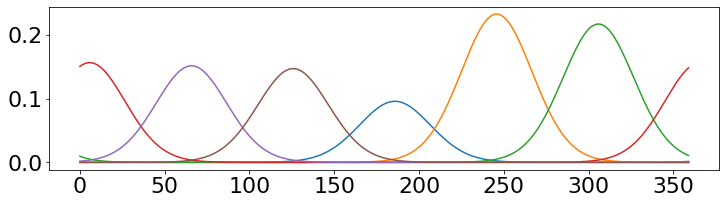

-12914.0
-11532.323895886497


In [45]:
def wrapdiff(diff):
    i = np.abs(diff) > (360 / 2.0)
    out = diff.copy()
    out[i] -= np.sign(diff[i]) * 360
    return np.abs(out)

# def alt_lstsq(M,b):
#     #workaround since autograd doesnt support np.linalg.lstsq
#     U, s, V = np.linalg.svd(M)
#     m = np.min(M.shape)
#     Sp = np.diag(np.concatenate([1/s,np.zeros(M.shape[0]-nchannels)]))[:,:nchannels].T
#     Us = np.asarray(np.matrix(U).getH())
#     Vs = np.asarray(np.matrix(V).getH())
#     return np.dot(np.dot(np.dot(Vs,Sp),Us),b)

class LogLike(tt.Op):
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value
    def __init__(self, function, trn, trnf):
        # add inputs as class attributes
        self.likelihood = function
        self.trn = trn
        self.trnf = trnf
#         # initialise the gradient Op (below)
#         self.logpgrad = LogLikeGrad(self.likelihood, self.trn, self.trnf)
    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta, = inputs  # this will contain my variables
        # call the log-likelihood function
        logl = self.likelihood(theta, self.trn, self.trnf)
        outputs[0][0] = np.array(logl) # output the log-likelihood
#     def grad(self, inputs, g):
#         theta, = inputs  # our parameters
#         return [g[0]*self.logpgrad(theta)]
    
class LogLikeGrad(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]
    def __init__(self, function, trn, trnf):
        # add inputs as class attributes
        self.likelihood = function
        self.trn = trn
        self.trnf = trnf
    def perform(self, node, inputs, outputs):
        theta, = inputs
        # define version of likelihood function to pass to derivative function
        def lnlike(values):
            return self.likelihood(values, self.trn, self.trnf)
        # calculate gradients
        grads = gradients(theta, lnlike)
        outputs[0][0] = grads

def decoder(theta,trn,trnf):
    mushift, kappas = theta[:2]
    amp = theta[2:]
    # construct basis set
    mu = np.linspace(0,(np.pi*2-(np.pi*2/nchannels)),nchannels)-np.pi+mushift
    k = np.ones(nchannels)*kappas
#     k = np.ones(nchannels)*1.42 # kappas
#     amp = np.ones(nchannels)/nchannels
    xx=np.linspace(-np.pi,np.pi,360)
    basis_set=[]
    for chan in range(nchannels):
        r = np.exp(k[chan]*np.cos((xx-mu[chan])))/(2*np.pi*sp.special.i0(k[chan]))
        basis_set.append(((r-np.min(r)) / (np.max(r)-np.min(r))) * amp[chan])
    basis_set = np.array(basis_set).T
    channelweights_per_vox = np.linalg.lstsq(basis_set[trnf,:], trn, rcond=None)[0] 
    cr_trn = np.linalg.lstsq(channelweights_per_vox.T , trn.T, rcond=None)[0].T
    # linear regression to find channel weights per voxel
#     U, s, V = np.linalg.svd(basis_set[trnf,:])
#     m = np.min(basis_set[trnf,:].shape)
#     Sp = np.diag(np.concatenate([1/s,np.zeros(basis_set[trnf,:].shape[0]-nchannels)]))[:,:nchannels].T
#     Us = np.asarray(np.matrix(U).getH())
#     Vs = np.asarray(np.matrix(V).getH())
#     channelweights_per_vox = np.dot(np.dot(np.dot(Vs,Sp),Us),trn)
    # linear regression to invert and decode
#     U, s, V = np.linalg.svd(channelweights_per_vox.T)
#     m = np.min(channelweights_per_vox.T.shape)
#     Sp = np.diag(np.concatenate([1/s,np.zeros(channelweights_per_vox.T.shape[0]-nchannels)]))[:,:nchannels].T
#     Us = np.asarray(np.matrix(U).getH())
#     Vs = np.asarray(np.matrix(V).getH())
#     cr_trn = np.dot(np.dot(np.dot(Vs,Sp),Us),trn.T).T
    # estimate stimulus feature
#     estimated_color_trn = np.full(cr_trn.shape[0],np.nan)
#     for trial in np.arange(cr_trn.shape[0]):
#         bs=[]
#         for chan in range(nchannels):
#             r = np.exp(k[chan]*np.cos((xx-mu[chan])))/(2*np.pi*sp.special.i0(k[chan]))
#             bs.append(((r-np.min(r)) / (np.max(r)-np.min(r))) * cr_trn[trial,chan])
#         bs = np.array(bs).T
#         estimated_color_trn[trial]=np.argmax(np.sum(bs,axis=1))
    estimated_color_trn = np.rad2deg(mu[np.argmax(cr_trn[:,:],axis=1)]+np.pi)
    trn_err = wrapdiff(trnf-estimated_color_trn.flatten())
    return -np.sum(trn_err)

def gradients(vals, func, releps=1e-3, abseps=None, mineps=1e-9, reltol=1e-3,
              epsscale=0.5):
    """
    Calculate the partial derivatives of a function at a set of values. The
    derivatives are calculated using the central difference, using an iterative
    method to check that the values converge as step size decreases.

    Parameters
    ----------
    vals: array_like
        A set of values, that are passed to a function, at which to calculate
        the gradient of that function
    func:
        A function that takes in an array of values.
    releps: float, array_like, 1e-3
        The initial relative step size for calculating the derivative.
    abseps: float, array_like, None
        The initial absolute step size for calculating the derivative.
        This overrides `releps` if set.
        `releps` is set then that is used.
    mineps: float, 1e-9
        The minimum relative step size at which to stop iterations if no
        convergence is achieved.
    epsscale: float, 0.5
        The factor by which releps if scaled in each iteration.

    Returns
    -------
    grads: array_like
        An array of gradients for each non-fixed value.
    """

    grads = np.zeros(len(vals))

    # maximum number of times the gradient can change sign
    flipflopmax = 10.

    # set steps
    if abseps is None:
        if isinstance(releps, float):
            eps = np.abs(vals)*releps
            eps[eps == 0.] = releps  # if any values are zero set eps to releps
            teps = releps*np.ones(len(vals))
        elif isinstance(releps, (list, np.ndarray)):
            if len(releps) != len(vals):
                raise ValueError("Problem with input relative step sizes")
            eps = np.multiply(np.abs(vals), releps)
            eps[eps == 0.] = np.array(releps)[eps == 0.]
            teps = releps
        else:
            raise RuntimeError("Relative step sizes are not a recognised type!")
    else:
        if isinstance(abseps, float):
            eps = abseps*np.ones(len(vals))
        elif isinstance(abseps, (list, np.ndarray)):
            if len(abseps) != len(vals):
                raise ValueError("Problem with input absolute step sizes")
            eps = np.array(abseps)
        else:
            raise RuntimeError("Absolute step sizes are not a recognised type!")
        teps = eps

    # for each value in vals calculate the gradient
    count = 0
    for i in range(len(vals)):
        # initial parameter diffs
        leps = eps[i]
        cureps = teps[i]

        flipflop = 0

        # get central finite difference
        fvals = np.copy(vals)
        bvals = np.copy(vals)

        # central difference
        fvals[i] += 0.5*leps  # change forwards distance to half eps
        bvals[i] -= 0.5*leps  # change backwards distance to half eps
        cdiff = (func(fvals)-func(bvals))/leps

        while 1:
            fvals[i] -= 0.5*leps  # remove old step
            bvals[i] += 0.5*leps

            # change the difference by a factor of two
            cureps *= epsscale
            if cureps < mineps or flipflop > flipflopmax:
                # if no convergence set flat derivative (TODO: check if there is a better thing to do instead)
                warnings.warn("Derivative calculation did not converge: setting flat derivative.")
                grads[count] = 0.
                break
            leps *= epsscale

            # central difference
            fvals[i] += 0.5*leps  # change forwards distance to half eps
            bvals[i] -= 0.5*leps  # change backwards distance to half eps
            cdiffnew = (func(fvals)-func(bvals))/leps

            if cdiffnew == cdiff:
                grads[count] = cdiff
                break

            # check whether previous diff and current diff are the same within reltol
            rat = (cdiff/cdiffnew)
            if np.isfinite(rat) and rat > 0.:
                # gradient has not changed sign
                if np.abs(1.-rat) < reltol:
                    grads[count] = cdiffnew
                    break
                else:
                    cdiff = cdiffnew
                    continue
            else:
                cdiff = cdiffnew
                flipflop += 1
                continue

        count += 1

    return grads

# create our Op
logl = LogLike(decoder,trn,trnf)

with pm.Model() as mymodel:
    mushift = pm.Uniform('mushift',lower=-(2*np.pi/nchannels)/2,upper=(2*np.pi/nchannels)/2)
    # shared precision parameter per channel, bounded 20-160 deg sd [sd2k(np.deg2rad(160))]
    # prior MAP = 60 sd (deg.)
    kappas = pm.Bound(pm.Gamma,lower = 0.0405,upper = 8.733)('kappas',2.,.7)
    p = pm.Dirichlet('p', a=np.ones(nchannels))
    
    # convert to a tensor vector
    theta = tt.concatenate([tt.stack([mushift,kappas]),p])
#     theta = tt.as_tensor_variable([mushift,kappas])
    
    # use a custom blackbox function (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})

    tracemap = pm.find_MAP()
#     trace = pm.sample(500, tune=1000, chains=3)
#     approx = pm.FullRankADVI()
#     approx.fit(10000)
#     posterior = approx.approx.sample(1000)

print(np.rad2deg(tracemap['mushift']))
print(np.rad2deg(k2sd(tracemap['kappas'])))
print(tracemap['p'])

basis_set = make_vonmises_iter(np.linspace(0,359,360),
         np.linspace(0,(360-(360/nchannels)),nchannels)-180+np.rad2deg(tracemap['mushift']),
         np.rad2deg(k2sd(tracemap['kappas']))*np.ones(nchannels),
         tracemap['p'])
plt.plot(basis_set)
plt.show()

print(decoder([0,sd2k(np.deg2rad(40)),.16,.16,.16,.16,.16,.16],trn,trnf))
print(decoder([tracemap['mushift'],tracemap['kappas'],
               1/nchannels,1/nchannels,1/nchannels,
               1/nchannels,1/nchannels,1/nchannels],
               trn,trnf))
print(decoder([tracemap['mushift'],tracemap['kappas'],
               tracemap['p'][0],tracemap['p'][1],tracemap['p'][2],
               tracemap['p'][3],tracemap['p'][4],tracemap['p'][5]],
               trn,trnf))


# Load real data

Num voxels: 1178
(848160,)
360 360 360.0 360.0
12.936943054199219
5000
5000


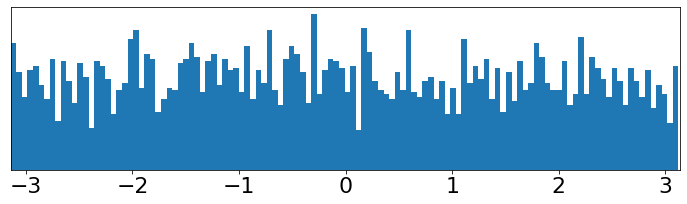

In [44]:
# create trial_by_vox and trial_features from our data
np.random.seed(1)
cur_roi='v1'
ntrials = 720
nvoxels = 0

lhd=load_obj("lh_v1d") 
rhd=load_obj("rh_v1d")
lhv=load_obj("lh_v1v")
rhv=load_obj("rh_v1v")

for roi in [lhd,lhv,rhd,rhv]: #[lhd,lhv,rhd,rhv]
    temp=roi['betas0'][0]
    nvoxels+=len(temp[~np.isnan(temp)])
del temp

vox_betas = []
vox_trial = []
vox_id = []
    
for trial in range(ntrials):
    data = [];
    for roi in [lhd,lhv,rhd,rhv]: #[lhd,lhv,rhd,rhv]
        if trial < 360:
            data = np.concatenate([data,roi['betas0'][trial]])
            select = data[np.where(~np.isnan(data))]
        else:
            data = np.concatenate([data,roi['betas1'][trial-360]])
            select = data[np.where(~np.isnan(data))]
    vox_betas = np.concatenate([vox_betas,select])
    vox_trial = np.concatenate([vox_trial,np.repeat(trial,select.size)])
    vox_id = np.concatenate([vox_id,np.arange(nvoxels)])
del roi; del lhd; del lhv; del rhd; del rhv; # free up computing power
print("Num voxels: {}".format(nvoxels))
print(vox_betas.shape)

train_trials=np.arange(ntrials)
test_trials=np.arange(360)+360#np.sort(np.random.choice(np.arange(ntrials),int(ntrials*.2)))
train_trials=np.where(~np.isin(train_trials,test_trials))[0]
print(len(train_trials),len(test_trials),ntrials*.5,ntrials*.5)

vox_betas-=np.min(vox_betas)

train_vox_betas = vox_betas[np.where(np.isin(vox_trial,train_trials))[0]]
test_vox_betas = vox_betas[np.where(np.isin(vox_trial,test_trials))[0]]
train_vox_trial = vox_trial[np.where(np.isin(vox_trial,train_trials))[0]]
test_vox_trial = vox_trial[np.where(np.isin(vox_trial,test_trials))[0]]
train_vox_features = within360(train_vox_trial)
test_vox_features = within360(test_vox_trial)
train_vox_id = vox_id[np.where(np.isin(vox_trial,train_trials))[0]]
test_vox_id = vox_id[np.where(np.isin(vox_trial,test_trials))[0]]

trial_by_vox=np.full((ntrials,nvoxels),np.nan)
trial_by_feature=np.full(ntrials,np.nan)
for t in range(ntrials):
    if np.isin(t,train_vox_trial):
        trial_by_vox[t,:] = train_vox_betas[train_vox_trial==t]
        trial_by_feature[t] = train_vox_features[train_vox_trial==t][0]
    elif np.isin(t,test_vox_trial):
        trial_by_vox[t,:] = test_vox_betas[test_vox_trial==t]
        trial_by_feature[t] = test_vox_features[test_vox_trial==t][0]
    else:
        error("?")

trial_features=np.tile(np.arange(360),2)
print(np.min(train_vox_betas))

# REAL DATA #
trn = trial_by_vox[np.isin(np.arange(ntrials),np.unique(train_vox_trial)),:]
trnf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(train_vox_trial))].astype(int)
tst = trial_by_vox[np.isin(np.arange(ntrials),np.unique(test_vox_trial)),:]
tstf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(test_vox_trial))]

vox_prob = [np.sum([train_vox_betas[j] for j in np.where(train_vox_features==f)[0]]) / np.sum(train_vox_betas)
            for f in range(360)]
vox_prob = vox_prob + (1-np.sum(vox_prob))/len(vox_prob) # ensure probabilites sum to 1
vox_prob -= np.min(vox_prob)
vox_prob = vox_prob * 100
vox_dist = inverse_transform(vox_prob)

# Plot input data: obs is what gets fed into the model
print(len(vox_dist))
obs = np.deg2rad(vox_dist)-np.pi
print(len(obs))
plt.hist(obs,bins=120)
plt.xlim([-np.pi,np.pi])
plt.yticks([])
plt.show()

In [5]:
# lhd=load_obj("lh_v1d") 
# rhd=load_obj("rh_v1d")
# lhv=load_obj("lh_v1v")
# rhv=load_obj("rh_v1v")
# lhd_beta = np.full((360),np.nan)
# rhd_beta = np.full((360),np.nan)
# lhv_beta = np.full((360),np.nan)
# rhv_beta = np.full((360),np.nan)
# for i in np.arange(360):
#     lhd_beta[i] = np.nanmean([lhd['betas0'][i],lhd['betas1'][i]])
#     rhd_beta[i] = np.nanmean([rhd['betas0'][i],rhd['betas1'][i]])
#     lhv_beta[i] = np.nanmean([lhv['betas0'][i],lhv['betas1'][i]])
#     rhv_beta[i] = np.nanmean([rhv['betas0'][i],rhv['betas1'][i]])
# lh_beta = np.mean([lhd_beta,lhv_beta],axis=0)
# rh_beta = np.mean([rhd_beta,rhv_beta],axis=0)
# d_beta = np.mean([lhd_beta,rhd_beta],axis=0)
# v_beta = np.mean([lhv_beta,rhv_beta],axis=0)
# full_betas = np.mean([lhd_beta,rhd_beta,lhv_beta,rhv_beta],axis=0)

plt.scatter(np.arange(360),lhd_beta,label='lh V1d')
plt.scatter(np.arange(360),lhv_beta,label='lh V1v')
plt.scatter(np.arange(360),rhd_beta,label='rh V1d')
plt.scatter(np.arange(360),rhv_beta,label='rh V1v')
plt.ylabel("Avg beta")
plt.xlabel("Polar angle")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.show()
plt.scatter(np.arange(360),lh_beta-rh_beta)
plt.ylabel("Avg beta")
plt.xlabel("Polar angle")
plt.title("left V1 - right V1 (=0)")
plt.show()
plt.scatter(np.arange(360),rh_beta-lh_beta)
plt.ylabel("Avg beta")
plt.xlabel("Polar angle")
plt.title("right V1 - left V1 (=180)")
plt.show()
plt.scatter(np.arange(360),d_beta-v_beta)
plt.ylabel("Avg beta")
plt.xlabel("Polar angle")
plt.title("dorsal V1 - ventral V1 (=270)")
plt.show()
plt.scatter(np.arange(360),v_beta-d_beta)
plt.ylabel("Avg beta")
plt.xlabel("Polar angle")
plt.title("ventral V1 - dorsal V1 (=90)")
plt.show()
print("0°=Right side, 180°=Left side, increasing degrees counter-clockwise")

NameError: name 'lhd_beta' is not defined

# Simulate Data

running sim_vox


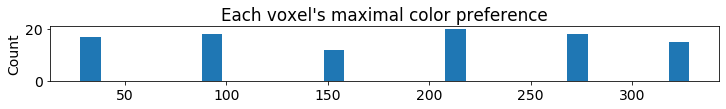

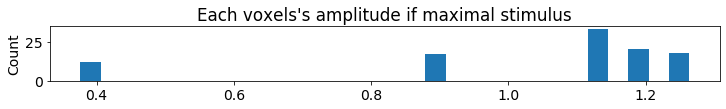

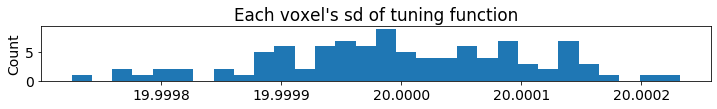

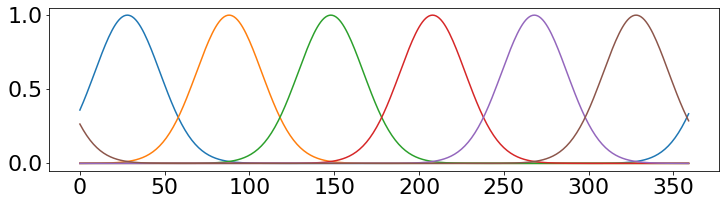

5000
5000


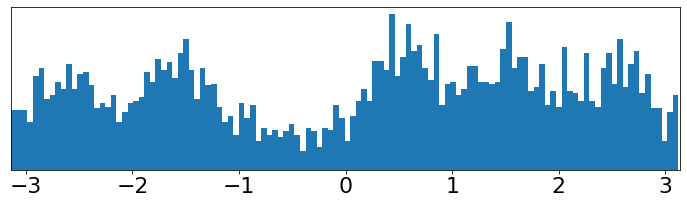

In [9]:
np.random.seed(1)

ntrials = 720
nvoxels = 100
vox_mu_sd = 0
vox_sd_mu = 20
vox_sd_sd = 0.0001
vox_gain_diff = 0 # difference in amplitude between trial conditions
vox_noise = 1 # introduce noise for every voxel
feature_space = np.linspace(0,359,360) # full range of our continuous feature (here 360 degrees in color wheel)

nchannels = 6
vox_nchannels = 6
# vox_mu_basis = np.array([ 40.,  72., 142., 222., 257., 324.]) 
vox_mu_basis = np.linspace(0,360-(360//vox_nchannels),vox_nchannels)+28 # ground truth voxel receptive fields
basis_points = vox_mu_basis
vox_amp_basis = np.ones(vox_nchannels) # amplitude for given features

# # randomize the amplitudes of the vox basis set
y_amp = pm.Dirichlet.dist(a=np.ones(nchannels)/nchannels)
vox_amp_basis = np.mean(y_amp.random(size=25),axis=0) * nchannels

y_mu = pm.NormalMixture.dist(w=np.ones(vox_nchannels)/vox_nchannels, 
                          mu=vox_mu_basis,
                          sigma=np.ones(vox_nchannels)*vox_mu_sd)
vox_mu = within360(y_mu.random(size=nvoxels))

vox_amp=np.full(nvoxels,np.nan)
for vox in np.arange(nvoxels):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(vox_mu[vox],len(vox_mu_basis)),vox_mu_basis) ) )
    vox_amp[vox] = vox_amp_basis[closest_basis]
    
y_sd = pm.TruncatedNormal.dist(mu=vox_sd_mu, sd=vox_sd_sd, lower=0)
vox_sd = y_sd.random(size=nvoxels)
channel_sd = np.ones(nchannels)*np.mean(vox_sd)
basis_sds=channel_sd
# vox_sd[(vox_mu<182) & (vox_mu>107)] = 40 #make the first channel wider than the rest
# channel_sd[1] = 40

print('running sim_vox')

trial_features, trial_conds, vox_betas, features, vox_id, vox_trial, trial_by_vox = sim_vox(plotting=1)

basis_set = make_vonmises_iter(feature_space, basis_points, channel_sd, np.ones(len(basis_points))) 
actual_weights = basis_set[trial_features,:]

plt.plot(basis_set)
plt.show()

trn = trial_by_vox[:ntrials//2,:] # training: trial "Betas"
trnf = np.array(trial_features[:ntrials//2]) # training trial features
tst = trial_by_vox[ntrials//2:,:] # testing: trial "Betas"
tstf = np.array(trial_features[ntrials//2:]) # test trial features

train_vox_betas = trn.flatten()
train_features = features[:len(features)//2]
test_vox_betas = tst.flatten()
test_features = features[len(features)//2:]

vox_prob = [np.sum([train_vox_betas[j] for j in np.where(train_features==f)[0]]) / np.sum(train_vox_betas)
            for f in range(360)]
vox_prob = vox_prob + (1-np.sum(vox_prob))/len(vox_prob) # ensure probabilites sum to 1
vox_prob -= np.min(vox_prob)
vox_prob *= 100
vox_dist = inverse_transform(vox_prob)

# Plot input data: obs is what gets fed into the model
print(len(vox_dist))
obs = np.deg2rad(vox_dist)-np.pi
print(len(obs))
plt.hist(obs,bins=120)
plt.xlim([-np.pi,np.pi])
plt.yticks([])
plt.show()


# Encoding Model

## Prep the model

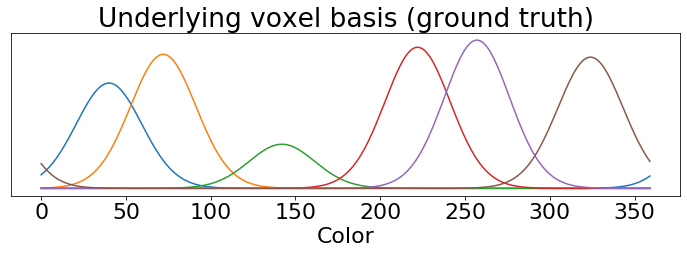

5000
5000


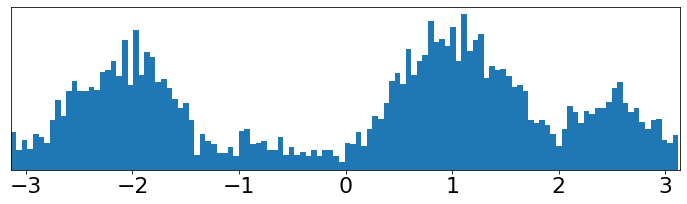

In [10]:
# # FAKE DATA #

# # Plot simulated voxel tunings (ground truth)               
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis,channel_sd,vox_amp_basis))
plt.title('Underlying voxel basis (ground truth)') 
# plt.ylabel('Response')
plt.xlabel('Color')
plt.yticks([])
plt.show()

vox_prob = [np.sum([vox_betas[j] for j in np.where(features==f)[0]]) / np.sum(vox_betas)
            for f in range(360)]
vox_prob = vox_prob + (1-np.sum(vox_prob))/len(vox_prob) # ensure probabilites sum to 1
vox_prob -= np.min(vox_prob)
vox_prob = vox_prob * 100
vox_dist = inverse_transform(vox_prob)

# Plot input data: obs is what gets fed into the model
print(len(vox_dist))
obs = np.deg2rad(vox_dist)-np.pi
print(len(obs))
plt.hist(obs,bins=120)
plt.xlim([-np.pi,np.pi])
plt.yticks([])
plt.show()

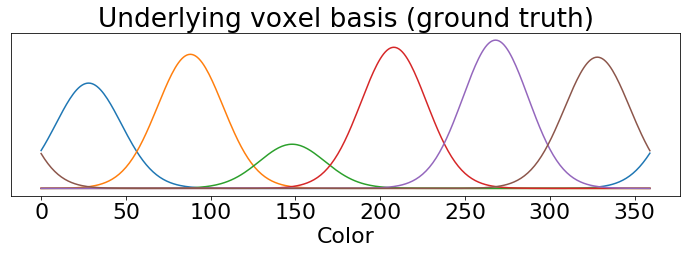

5000
5000


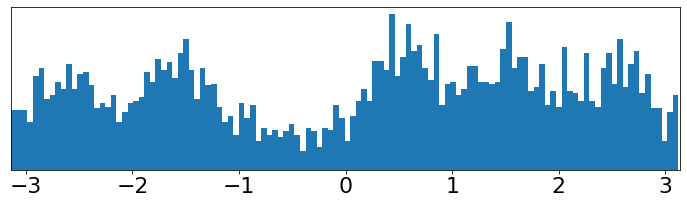

In [7]:
# # FAKE DATA #

# # Plot simulated voxel tunings (ground truth)               
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis,channel_sd,vox_amp_basis))
plt.title('Underlying voxel basis (ground truth)') 
# plt.ylabel('Response')
plt.xlabel('Color')
plt.yticks([])
plt.show()

trn = trial_by_vox[:ntrials//2,:] # training: trial "Betas"
trnf = np.array(trial_features[:ntrials//2]) # training trial features
tst = trial_by_vox[ntrials//2:,:] # testing: trial "Betas"
tstf = np.array(trial_features[ntrials//2:]) # test trial features

train_vox_betas = trn.flatten()
train_features = features[:len(features)//2]
test_vox_betas = tst.flatten()
test_features = features[len(features)//2:]

vox_prob = [np.sum([train_vox_betas[j] for j in np.where(train_features==f)[0]]) / np.sum(train_vox_betas)
            for f in range(360)]
vox_prob = vox_prob + (1-np.sum(vox_prob))/len(vox_prob) # ensure probabilites sum to 1
vox_prob -= np.min(vox_prob)
vox_prob *= 100
vox_dist = inverse_transform(vox_prob)

# Plot input data: obs is what gets fed into the model
print(len(vox_dist))
obs = np.deg2rad(vox_dist)-np.pi
print(len(obs))
plt.hist(obs,bins=120)
plt.xlim([-np.pi,np.pi])
plt.yticks([])
plt.show()

5000
5000


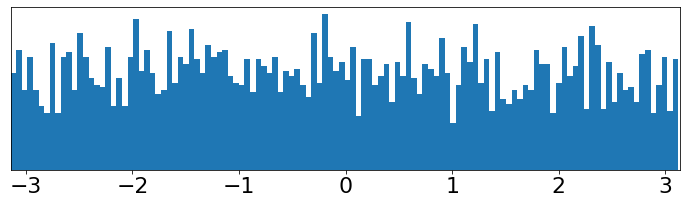

In [24]:
# REAL DATA #
trn = trial_by_vox[np.isin(np.arange(ntrials),np.unique(train_vox_trial)),:]
trnf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(train_vox_trial))].astype(int)
tst = trial_by_vox[np.isin(np.arange(ntrials),np.unique(test_vox_trial)),:]
tstf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(test_vox_trial))]

vox_prob = [np.sum([train_vox_betas[j] for j in np.where(train_vox_features==f)[0]]) / np.sum(train_vox_betas)
            for f in range(360)]
vox_prob = vox_prob + (1-np.sum(vox_prob))/len(vox_prob) # ensure probabilites sum to 1
vox_prob -= np.min(vox_prob)
vox_prob = vox_prob * 100
vox_dist = inverse_transform(vox_prob)

# Plot input data: obs is what gets fed into the model
print(len(vox_dist))
obs = np.deg2rad(vox_dist)-np.pi
print(len(obs))
plt.hist(obs,bins=120)
plt.xlim([-np.pi,np.pi])
plt.yticks([])
plt.show()

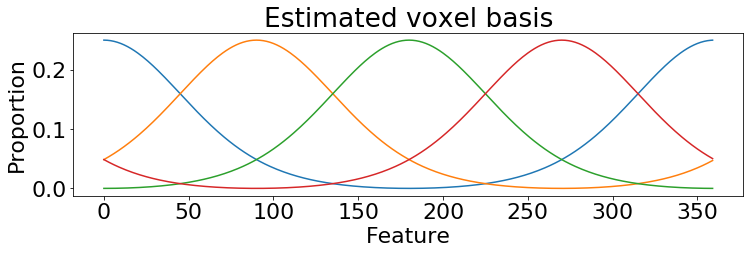

inverting model...
null permutation testing...
Done!
cur_model: v1_4k_4chan_vi
starting approximation...


Finished [100%]: Average Loss = 921.16


[49.224239, 137.627875, 225.565299, 314.877654]
[45.74334532799206, 47.85140560679244, 46.30739839577117, 47.138121977062504]
[0.2667112770728969, 0.24205756097917544, 0.24937412726049968, 0.241857034687428]


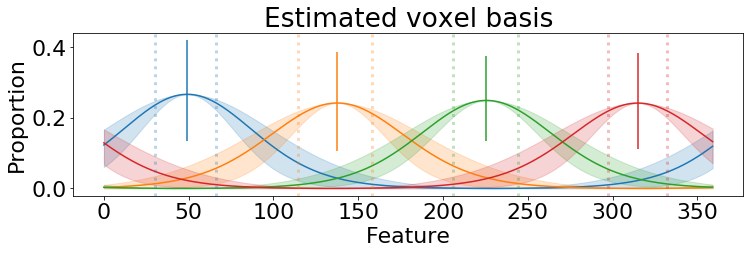

inverting model...
Done!
cur_model: v1_6k_6chan_vi
starting approximation...


Finished [100%]: Average Loss = 921.52


[32.675715, 87.648356, 152.516665, 210.111144, 268.42072, 328.284685]
[39.831038514310535, 39.36826872938054, 39.916761521783, 40.000476083488735, 39.708719049280134, 39.25205225376673]
[0.17499652251058523, 0.17256108723715652, 0.1665824366819773, 0.16558134304920025, 0.16367995980444439, 0.1565986507166363]


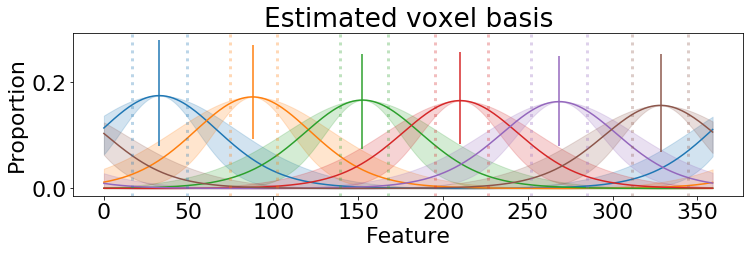

inverting model...
Done!
cur_model: v1_10k_10chan_vi
starting approximation...


Finished [100%]: Average Loss = 921.93


[18.229828, 55.040653, 88.730203, 126.299698, 162.790565, 197.65372, 234.309526, 268.731276, 306.138046, 341.644633]
[38.9985271010902, 36.48596568503819, 36.883164279843285, 40.13657021972099, 35.44587412224671, 37.58884217208538, 35.684302621467374, 37.962745238036604, 35.51077053465719, 38.97024075122401]
[0.10853324847164182, 0.11022815958650596, 0.10685666613607896, 0.09584904148544406, 0.09983447474505547, 0.099663963493898, 0.10364878697500694, 0.09608758127545912, 0.09357689586840764, 0.08572118196250199]


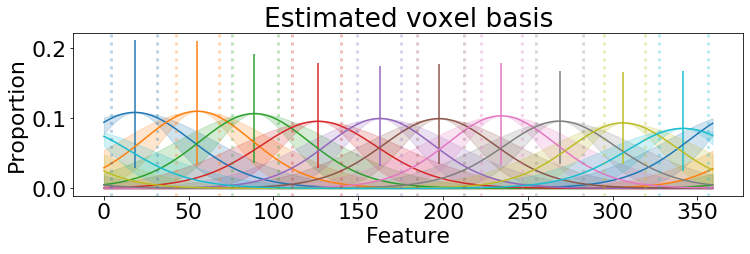

inverting model...
Done!


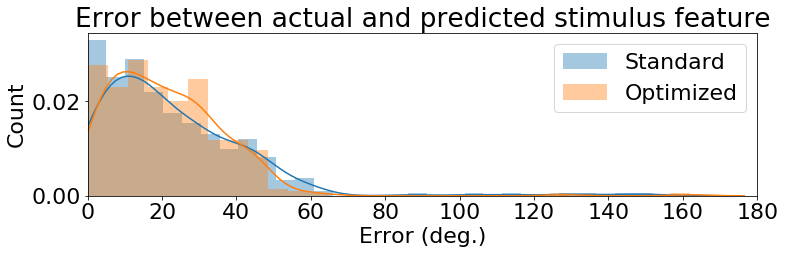

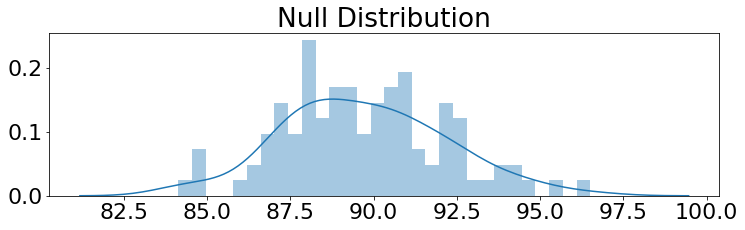

MAEs
 Standard: 23.022
 Optimized: 21.286

Standard vs. Optimized Reconstructions: t(359)=1.151, p=0.251

Standard vs. Null Distribution: p=0.00


In [105]:
[trn_err0, tst_err0, null_err0] = generative_model(cur_roi,obs,4,4,
                                        trn=trn,trnf=trnf,tst=tst,tstf=tstf,standard=True,null=True)
[trn_err, tst_err, posterior] = generative_model(cur_roi,obs,4,4,
                                        trn=trn,trnf=trnf,tst=tst,tstf=tstf)
[trn_err1, tst_err1, posterior] = generative_model(cur_roi,obs,6,6,
                                        trn=trn,trnf=trnf,tst=tst,tstf=tstf)
[trn_err2, tst_err2, posterior] = generative_model(cur_roi,obs,6,6,
                                        trn=trn,trnf=trnf,tst=tst,tstf=tstf,standard=True) # starting 0
[trn_err3, tst_err3, posterior] = generative_model(cur_roi,obs,6,6,
                                        trn=trn,trnf=trnf,tst=tst,tstf=tstf,standard=True)
[trn_err4, tst_err4, posterior] = generative_model(cur_roi,obs,1,6,
                                        trn=trn,trnf=trnf,tst=tst,tstf=tstf) 
[trn_err5, tst_err5, posterior] = generative_model(cur_roi,obs,1,6,
                                        trn=trn,trnf=trnf,tst=tst,tstf=tstf) # starting 0

sns.distplot(tst_err0,30,label="Standard")
sns.distplot(tst_err,30,label="Optimized")
plt.legend()
plt.title("Error between actual and predicted stimulus feature")
plt.xlabel("Error (deg.)")
plt.ylabel("Count")
plt.xlim([0,180])
plt.show()

sns.distplot(null_err,30)
plt.title("Null Distribution")
plt.show()

print("MAEs\n Standard: {:.3f}\n Optimized: {:.3f}\n".format(
    np.mean(tst_err0),np.mean(tst_err)))

[tstat, pvalue] = sp.stats.ttest_rel(tst_err0,tst_err)
print("Standard vs. Optimized Reconstructions: t({})={:.3f}, p={:.3f}\n".format(len(tst_err0)-1,tstat,pvalue))

print("Standard vs. Null Distribution: p={:.2f}".format(len(null_err0[null_err0<np.mean(tst_err0)])/len(null_err0)*100))
# print("Optimized vs. Null Distribution: p={:.2f}".format(len(null_err[null_err<np.mean(tst_err)])/len(null_err)*100))


In [802]:
## Custom changes to PyMC3 ##

# allow pymc3 to use scipy's modified bessel function
from theano.compile.ops import as_op
@as_op(itypes=[tt.dscalar], otypes=[tt.dscalar])
def k2sd_to_deg_op(k):
    return np.rad2deg(np.sqrt( -2 * np.log( sp.special.iv(1,k) / sp.special.iv(0,k) ) ))

# see this thread's last post for what this code does: 
# https://discourse.pymc.io/t/how-does-pymc3-interpret-von-mises-boundaries/4453/7
from pymc3.distributions.distribution import (Continuous, draw_values, generate_samples)
from pymc3.distributions import transforms
from pymc3.theanof import floatX
from pymc3.distributions.special import log_i0
from pymc3.distributions.dist_math import (
    alltrue_elemwise, betaln, bound, gammaln, i0e, incomplete_beta, logpow,
    normal_lccdf, normal_lcdf, SplineWrapper, std_cdf, zvalue)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False

    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)

class VonMises(Continuous):
    R"""
    Univariate VonMises log-likelihood.

    The pdf of this distribution is

    .. math::

        f(x \mid \mu, \kappa) =
            \frac{e^{\kappa\cos(x-\mu)}}{2\pi I_0(\kappa)}

    where :math:`I_0` is the modified Bessel function of order 0.

    .. plot::

        import matplotlib.pyplot as plt
        import numpy as np
        import scipy.stats as st
        plt.style.use('seaborn-darkgrid')
        x = np.linspace(-np.pi, np.pi, 200)
        mus = [0., 0., 0.,  -2.5]
        kappas = [.01, 0.5,  4., 2.]
        for mu, kappa in zip(mus, kappas):
            pdf = st.vonmises.pdf(x, kappa, loc=mu)
            plt.plot(x, pdf, label=r'$\mu$ = {}, $\kappa$ = {}'.format(mu, kappa))
        plt.xlabel('x', fontsize=12)
        plt.ylabel('f(x)', fontsize=12)
        plt.legend(loc=1)
        plt.show()

    ========  ==========================================
    Support   :math:`x \in [-\pi, \pi]`
    Mean      :math:`\mu`
    Variance  :math:`1-\frac{I_1(\kappa)}{I_0(\kappa)}`
    ========  ==========================================

    Parameters
    ----------
    mu : float
        Mean.
    kappa : float
        Concentration (\frac{1}{kappa} is analogous to \sigma^2).
    """

    def __init__(self, mu=0.0, kappa=None, transform='circular',
                 *args, **kwargs):
        if transform == 'circular':
            transform = transforms.Circular()
        super().__init__(transform=transform, *args, **kwargs)
        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.kappa = kappa = tt.as_tensor_variable(floatX(kappa))

        assert_negative_support(kappa, 'kappa', 'VonMises')

    def random(self, point=None, size=None):
        """
        Draw random values from VonMises distribution.

        Parameters
        ----------
        point : dict, optional
            Dict of variable values on which random values are to be
            conditioned (uses default point if not specified).
        size : int, optional
            Desired size of random sample (returns one sample if not
            specified).

        Returns
        -------
        array
        """
        mu, kappa = draw_values([self.mu, self.kappa],
                                point=point, size=size)
        return within_pi(generate_samples(sp.stats.vonmises.rvs, loc=mu, kappa=kappa,
                                dist_shape=self.shape,
                                size=size))

    def logp(self, value):
        """
        Calculate log-probability of VonMises distribution at specified value.

        Parameters
        ----------
        value : numeric
            Value(s) for which log-probability is calculated. If the log probabilities for multiple
            values are desired the values must be provided in a numpy array or theano tensor

        Returns
        -------
        TensorVariable
        """
        mu = self.mu
        kappa = self.kappa
        return bound(kappa * tt.cos(mu - value) - (tt.log(2 * np.pi) + log_i0(kappa)),
                     kappa > 0, value >= -np.pi, value <= np.pi)
    
class BoundedContinuous(Continuous):
    """Base class for bounded continuous distributions"""

    def __init__(self, transform='auto', lower=None, upper=None,
                 *args, **kwargs):

        lower = tt.as_tensor_variable(lower) if lower is not None else None
        upper = tt.as_tensor_variable(upper) if upper is not None else None

        if transform == 'auto':
            if lower is None and upper is None:
                transform = None
            elif lower is not None and upper is None:
                transform = transforms.lowerbound(lower)
            elif lower is None and upper is not None:
                transform = transforms.upperbound(upper)
            else:
                transform = transforms.interval(lower, upper)

        super().__init__(transform=transform, *args, **kwargs)
        
class Uniform(BoundedContinuous):
    R"""
    Continuous uniform log-likelihood.

    The pdf of this distribution is

    .. math::

       f(x \mid lower, upper) = \frac{1}{upper-lower}

    .. plot::

        import matplotlib.pyplot as plt
        import numpy as np
        plt.style.use('seaborn-darkgrid')
        x = np.linspace(-3, 3, 500)
        ls = [0., -2]
        us = [2., 1]
        for l, u in zip(ls, us):
            y = np.zeros(500)
            y[(x<u) & (x>l)] = 1.0/(u-l)
            plt.plot(x, y, label='lower = {}, upper = {}'.format(l, u))
        plt.xlabel('x', fontsize=12)
        plt.ylabel('f(x)', fontsize=12)
        plt.ylim(0, 1)
        plt.legend(loc=1)
        plt.show()

    ========  =====================================
    Support   :math:`x \in [lower, upper]`
    Mean      :math:`\dfrac{lower + upper}{2}`
    Variance  :math:`\dfrac{(upper - lower)^2}{12}`
    ========  =====================================

    Parameters
    ----------
    lower : float
        Lower limit.
    upper : float
        Upper limit.
    """

    def __init__(self, lower=0, upper=1, *args, **kwargs):
        self.lower = lower = tt.as_tensor_variable(floatX(lower))
        self.upper = upper = tt.as_tensor_variable(floatX(upper))
        self.mean = (upper + lower) / 2.
        self.median = self.mean

        super().__init__(lower=lower, upper=upper, *args, **kwargs)

    def random(self, point=None, size=None):
        """
        Draw random values from Uniform distribution.

        Parameters
        ----------
        point : dict, optional
            Dict of variable values on which random values are to be
            conditioned (uses default point if not specified).
        size : int, optional
            Desired size of random sample (returns one sample if not
            specified).

        Returns
        -------
        array
        """

        lower, upper = draw_values([self.lower, self.upper],
                                   point=point, size=size)
        return within_pi(generate_samples(stats.uniform.rvs, loc=lower,
                                scale=upper - lower,
                                dist_shape=self.shape,
                                size=size))

    def logp(self, value):
        """
        Calculate log-probability of Uniform distribution at specified value.

        Parameters
        ----------
        value : numeric
            Value for which log-probability is calculated.

        Returns
        -------
        TensorVariable
        """
        lower = self.lower
        upper = self.upper
        return bound(-tt.log(upper - lower),
                     value >= lower, value <= upper)

    def logcdf(self, value):
        """
        Compute the log of the cumulative distribution function for Uniform distribution
        at the specified value.

        Parameters
        ----------
        value: numeric
            Value(s) for which log CDF is calculated. If the log CDF for multiple
            values are desired the values must be provided in a numpy array or theano tensor.

        Returns
        -------
        TensorVariable
        """
        return tt.switch(
            tt.or_(tt.lt(value, self.lower), tt.gt(value, self.upper)),
            -np.inf,
            tt.switch(
                tt.eq(value, self.upper),
                0,
                tt.log((value - self.lower)) -
                tt.log((self.upper - self.lower))
            )
        )

pm.VonMises = VonMises
pm.Uniform = Uniform
# pm.TruncatedNormal = TruncatedNormal

## Initialize the model

See list of models at bottom of document. Initialize the model(s) you want to run.

In [664]:
nchannels=1
with pm.Model() as shared_k_1_channels:    
    # shared precision parameter per channel
    kappas = pm.Bound(pm.Gamma,lower = .609,upper = 33.33)('kappa',2.,.01)
    
    # bounded von mises distribution per channel
    mus = [pm.Uniform('mu_%d' % i, 
                   lower = -np.pi,
                   upper = np.pi)
       for i in range(nchannels)] #-.2618 = 15 degrees
    
    # weights of each mixture component
    p = pm.Dirichlet('p', a=np.array([1.]*(nchannels+1)))
    
    dists = [
        pm.VonMises.dist(mu=mus[0],kappa=kappas),
        pm.Uniform.dist(lower=-np.pi,upper=np.pi),
    ]
    
    # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
    mus_deg = [pm.Deterministic('mu_deg_%d' % i,
                              np.rad2deg(mus[i]+np.pi))
              for i in range(nchannels)]
    
        # Convenience transform: kappa (in radians) to sd (in degrees)
    sds = pm.Deterministic('sd_deg', k2sd_to_deg_op(kappas))

#     # Specify the likelihood
    y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs) #, total_size=obs.shape)


INFO (theano.gof.compilelock): Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock


In [667]:
nchannels=1
with pm.Model() as shared_k_1_channels_nounif:    
    # shared precision parameter per channel
    kappas = pm.Bound(pm.Gamma,lower = .609,upper = 33.33)('kappa',2.,.01)
    
    # bounded von mises distribution per channel
    mus = [pm.Uniform('mu_%d' % i, 
                   lower = -np.pi,
                   upper = np.pi)
       for i in range(nchannels)] #-.2618 = 15 degrees
    
    # weights of each mixture component
    p = [1,0]#pm.Dirichlet('p', a=np.array([1.]*(nchannels)))
    
    dists = [
        pm.VonMises.dist(mu=mus[0],kappa=kappas),
        pm.Uniform.dist(lower=-np.pi,upper=np.pi),
    ]
    
    # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
    mus_deg = [pm.Deterministic('mu_deg_%d' % i,
                              np.rad2deg(mus[i]+np.pi))
              for i in range(nchannels)]
    
        # Convenience transform: kappa (in radians) to sd (in degrees)
    sds = pm.Deterministic('sd_deg', k2sd_to_deg_op(kappas))

#     # Specify the likelihood
    y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs) #, total_size=obs.shape)


INFO (theano.gof.compilelock): Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock


In [588]:
nchannels=2
with pm.Model() as shared_k_2_channels_nounif:    
    # shared precision parameter per channel
    kappas = pm.Bound(pm.Gamma,lower = .609,upper = 33.33)('kappa',2.,.01)
    
    # bounded von mises distribution per channel
    mus = [pm.Uniform('mu_%d' % i, 
                   lower = (2*np.pi)/nchannels*i - np.pi-.2618,
                   upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi-.2618)
       for i in range(nchannels)] #-.2618 = 15 degrees
    
    # weights of each mixture component
    p = pm.Dirichlet('p', a=np.array([1.]*(nchannels)))
    
    dists = [
        pm.VonMises.dist(mu=mus[0],kappa=kappas),
        pm.VonMises.dist(mu=mus[1],kappa=kappas),
#         pm.Uniform.dist(lower=-np.pi,upper=np.pi),
    ]
    
    # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
    mus_deg = [pm.Deterministic('mu_deg_%d' % i,
                              np.rad2deg(mus[i]+np.pi))
              for i in range(nchannels)]
    
        # Convenience transform: kappa (in radians) to sd (in degrees)
    sds = pm.Deterministic('sd_deg', k2sd_to_deg_op(kappas))

#     # Specify the likelihood
    y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs) #, total_size=obs.shape)


INFO (theano.gof.compilelock): Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock


In [601]:
nchannels=4
with pm.Model() as shared_k_4_channels:    
    # shared precision parameter per channel, bounded 30-120 deg sd [sd2k(np.deg2rad(120))]
    kappas = pm.Bound(pm.Gamma,lower = .2245,upper = 4.207)('kappas',2.,1.)
    
    # bounded von mises distribution per channel
    mus = [pm.Uniform('mu_%d' % i, 
                   lower = (2*np.pi)/nchannels*i - np.pi-.2618,
                   upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi-.2618)
       for i in range(nchannels)] #-.2618 = 15 degrees
    
    # weights of each mixture component
    p = pm.Dirichlet('p', a=np.array([1.]*(nchannels)))
    
    dists = [
        pm.VonMises.dist(mu=mus[0],kappa=kappas),
        pm.VonMises.dist(mu=mus[1],kappa=kappas),
        pm.VonMises.dist(mu=mus[2],kappa=kappas),
        pm.VonMises.dist(mu=mus[3],kappa=kappas),
#         pm.Uniform.dist(lower=-np.pi,upper=np.pi),
    ]
    
    # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
    mus_deg = [pm.Deterministic('mu_deg_%d' % i,
                              np.rad2deg(mus[i]+np.pi))
              for i in range(nchannels)]
    
        # Convenience transform: kappa (in radians) to sd (in degrees)
    sds = pm.Deterministic('sd_deg', k2sd_to_deg_op(kappas))

#     # Specify the likelihood
    y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs) #, total_size=obs.shape)


INFO (theano.gof.compilelock): Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock


In [58]:
nchannels=4

def model_factory(obs):
    with pm.Model() as model:       
        # shared precision parameter per channel, bounded 30-120 deg sd [sd2k(np.deg2rad(120))]
        kappas = pm.Bound(pm.Gamma,lower = .2245,upper = 4.207)('kappas',2.,1.)

        # bounded von mises distribution per channel
        mus = [pm.Uniform('mu_%d' % i, 
                       lower = (2*np.pi)/nchannels*i - np.pi-.2618,
                       upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi-.2618)
           for i in range(nchannels)] #-.2618 = 15 degrees

        # weights of each mixture component
        p = pm.Dirichlet('p', a=np.array([1.]*(nchannels+1)))

        dists = [
            pm.VonMises.dist(mu=mus[0],kappa=kappas),
            pm.VonMises.dist(mu=mus[1],kappa=kappas),
            pm.VonMises.dist(mu=mus[2],kappa=kappas),
            pm.VonMises.dist(mu=mus[3],kappa=kappas),
            pm.Uniform.dist(lower=-np.pi,upper=np.pi),
        ]

        # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
        mus_deg = [pm.Deterministic('mu_deg_%d' % i,
                                  np.rad2deg(mus[i]+np.pi))
                  for i in range(nchannels)]

        # Convenience transform: kappa (in radians) to sd (in degrees)
        sds = pm.Deterministic('sd_deg', k2sd_to_deg_op(kappas))

        # Specify the likelihood
        y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs) #, total_size=obs.shape) note:for VI

    return model

with model_factory(obs) as model:
    train_trace = pm.sample(5000, tune=15000, chains=3)
    pm.save_trace(train_trace,"train_trace_{}".format(cur_roi),overwrite=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [p, mu_3, mu_2, mu_1, mu_0, kappas]


Sampling 3 chains for 15_000 tune and 5_000 draw iterations (45_000 + 15_000 draws total) took 8636 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.63440120685929, but should be close to 0.8. Try to increase the number of tuning steps.
There were 857 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5770043386667698, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


KeyError: 'sd_deg'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x11aee7b70> (for post_execute):


KeyboardInterrupt: 

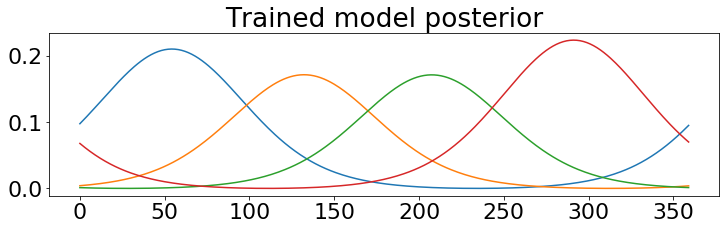

In [89]:
plt.plot(make_vonmises_iter(np.linspace(0,359,360),
         [np.mean(train_trace['mu_deg_{}'.format(chan)]) for chan in range(nchannels)],
         np.mean(train_trace['sd_deg'])*np.ones(nchannels),
#          [np.mean(train_trace['sd_deg_{}'.format(chan)]) for chan in range(nchannels)
         [np.mean(train_trace['p'][:,chan]) for chan in range(nchannels)]))
plt.title("Trained model posterior")
# plt.show()

trial=132+360
x = test_vox_betas[test_vox_trial==trial]/np.sum(test_vox_betas[test_vox_trial==trial])
x = x + (1-np.sum(x))/len(x) # ensure sums to 1
x = inverse_transform(x)
x = np.deg2rad(x)-np.pi
obs=x
    
with model_factory(x) as test_model:
    ppc = pm.fast_sample_posterior_predictive(train_trace,500)

plt.plot(make_vonmises_iter(np.linspace(0,359,360),
         [np.mean(train_trace['mu_deg_{}'.format(chan)]) for chan in range(nchannels)],
         np.mean(ppc['sd_deg'])*np.ones(nchannels),
#          [np.mean(train_trace['sd_deg_{}'.format(chan)]) for chan in range(nchannels)
         [np.mean(ppc['p'][:,chan]) for chan in range(nchannels)]))
plt.title("Trial {} posterior:".format(trial))

## enhanced model

In [110]:
nchannels=4

samps=360
nvoxels=50 #1178
X=[];Y=[];Z=[]
for v in range(nvoxels):
    x = train_vox_betas[train_vox_id==v]/np.sum(train_vox_betas[train_vox_id==v])
    x = x + (1-np.sum(x))/len(x) # ensure sums to 1
    x = inverse_transform(x,samps=samps)
    X = np.concatenate([X,np.deg2rad(x)-np.pi])
    
    y = test_vox_betas[test_vox_id==v]/np.sum(test_vox_betas[test_vox_id==v])
    y = y + (1-np.sum(y))/len(y) # ensure sums to 1
    y = inverse_transform(y,samps=samps)
    Y = np.concatenate([Y,np.deg2rad(y)-np.pi])
    
#     z = vox_betas[vox_id==v]/np.sum(vox_betas[vox_id==v])
#     z = z + (1-np.sum(z))/len(z) # ensure sums to 1
#     z = inverse_transform(z,samps=samps)
#     Z = np.concatenate([Z,np.deg2rad(z)-np.pi])
    
data = pm.Minibatch(X, batch_size=500)
with pm.Model() as hierarchical_iem:       
    # precision parameter bounded 15-120 deg sd [sd2k(np.deg2rad(120))]
#     k_shape = pm.Gamma('k_shape', 2, 1)
#     k_rate = pm.Gamma('k_rate', 2, 1)
    kappa = pm.Bound(pm.Gamma,lower = .2245,upper = 15.1046)('kappa', alpha=2., beta=1.)
#     kappa_i = pm.Bound(pm.Gamma,lower = .2245,upper = 15.1046)('kappa_i', alpha=2, beta=2, shape=nvoxels)

#     mus = tt.real([pm.Uniform('mu_%d' % i, 
#                lower = (2*np.pi)/nchannels*i - np.pi-.2618,
#                upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi-.2618)
#            for i in range(nchannels)])

    mus = pm.Uniform('mus',
                     lower=np.deg2rad(np.linspace(0,360-360//nchannels,nchannels))-np.pi,
                     upper=np.deg2rad(np.linspace(0,360-360//nchannels,nchannels)+(360//nchannels))-np.pi,
                     shape=nchannels)

    p = pm.Dirichlet('p',a=np.asarray([.05,.05,.05,.05,.8]),shape=(nvoxels,nchannels+1))
#     cat = pm.Categorical('cat',p=mu_p,shape=nvoxels)
    
#     p = pm.Dirichlet('p',a=np.ones(2),shape=(nvoxels,2))
#     pA = pm.Exponential('pA',.1)
#     pB = pm.Exponential('pB',.1)
#     p = pm.Beta('p', alpha=5, beta=2) # assuming mostly uniform
        
    # flexible mu within channel
#     u = pm.TruncatedNormal('u', mu=0, sd=np.deg2rad(5), shape=nvoxels)

    dists = [
#         pm.VonMises.dist(mu=tt.repeat(mus[cat[np.arange(nvoxels)]],samps),
#                          kappa=tt.repeat(kappa,samps*nvoxels)),
        pm.VonMises.dist(mu=tt.repeat(mus[0],samps*nvoxels),
                         kappa=tt.repeat(kappa,samps*nvoxels)),
        pm.VonMises.dist(mu=tt.repeat(mus[1],samps*nvoxels),
                         kappa=tt.repeat(kappa,samps*nvoxels)),
        pm.VonMises.dist(mu=tt.repeat(mus[2],samps*nvoxels),
                         kappa=tt.repeat(kappa,samps*nvoxels)),
        pm.VonMises.dist(mu=tt.repeat(mus[3],samps*nvoxels),
                         kappa=tt.repeat(kappa,samps*nvoxels)),
        pm.Uniform.dist(lower=np.full(samps*nvoxels,-np.pi), upper=np.full(samps*nvoxels,np.pi)),
    ]
    
    w = tt.repeat(p,samps,axis=0)
#     w = tt.stack([tt.repeat(p,samps*nvoxels), tt.repeat(1-p,samps*nvoxels)]).T

    y = pm.Mixture('y', w=w, comp_dists=dists, observed=data, total_size=X.shape)

    # Convenience transforms #
    # kappa: radians to sd (in degrees)
    sds = [pm.Deterministic('sd_deg', k2sd_to_deg_op(kappa))]
#     sds_i = [pm.Deterministic('sds_i_%d' % v, k2sd_to_deg_op(kappa_i[v])) for v in range(nvoxels)]
    # mu: radians to degrees (0 to 359)
    mus_chan = [pm.Deterministic('mu_chan_%d' % chan, np.rad2deg(mus[chan]+np.pi)) for chan in range(nchannels)]
#     mus_vox = [pm.Deterministic('mu_vox_%d' % v, np.rad2deg(mus[cat[v]]+np.pi)) for v in range(nvoxels)]
    
with hierarchical_iem:
#     posterior = pm.sample(5000, tune=15000, chains=3)
#     pm.save_trace(posterior,"hierarchical_{}".format(cur_roi),overwrite=True)
    approx = pm.FullRankADVI()
    approx.fit(1000) #100000
           
# pm.summary(posterior)#,var_names=["kappa","mus","sds","mus_deg"])    

INFO (theano.gof.compilelock): Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
INFO:theano.gof

Finished [100%]: Average Loss = 33,979
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 33,979


In [23]:
nchannels=6
samps=360
# nvoxels=15 #100
X=[];Y=[]
for v in range(nvoxels):
    x = vox_betas[vox_id==v]/np.sum(vox_betas[vox_id==v])
    x = x + (1-np.sum(x))/len(x) # ensure sums to 1
    x = inverse_transform(x,samps=samps)
    X = np.concatenate([X,np.deg2rad(x)-np.pi])
    
with pm.Model() as hierarchical_iem:       
    # precision parameter bounded 10-120 deg sd [sd2k(np.deg2rad(120))]
#     k_shape = pm.Gamma('k_shape', 2, 1)
#     k_rate = pm.Gamma('k_rate', 2, 1)
    kappa = pm.Bound(pm.Gamma,lower = .2245,upper = 33.334)('kappa', alpha=2., beta=1.)
#     kappa_i = pm.Bound(pm.Gamma,lower = .2245,upper = 33.334)('kappa_i', alpha=2, beta=2, shape=nvoxels)

#     mus = tt.real([pm.Uniform('mu_%d' % i, 
#                lower = (2*np.pi)/nchannels*i - np.pi-.2618,
#                upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi-.2618)
#            for i in range(nchannels)])

    mus = pm.Uniform('mus',
                     lower=np.deg2rad(basis_points)-np.pi,
                     upper=np.deg2rad(basis_points+360//nchannels)-np.pi,
                     shape=nchannels)

    mu_p = pm.Dirichlet('mu_p',a=np.ones(nchannels),shape=(nvoxels,nchannels))
    cat = pm.Categorical('cat',p=mu_p,shape=nvoxels)
    
#     p = pm.Dirichlet('p',a=np.ones(2),shape=(nvoxels,2))
#     pA = pm.Exponential('pA',.1)
#     pB = pm.Exponential('pB',.1)
    p = pm.Beta('p', alpha=5, beta=2) # assuming mostly uniform
        
    # flexible mu within channel
#     u = pm.TruncatedNormal('u', mu=0, sd=np.deg2rad(5), shape=nvoxels)

    dists = [
        pm.VonMises.dist(mu=tt.repeat(mus[cat[np.arange(nvoxels)]],samps),
                         kappa=tt.repeat(kappa,samps*nvoxels)),
        pm.Uniform.dist(lower=np.full(samps*nvoxels,-np.pi), upper=np.full(samps*nvoxels,np.pi)),
    ]
    
    w = tt.stack([tt.repeat(p,samps*nvoxels), tt.repeat(1-p,samps*nvoxels)]).T

    y = pm.Mixture('y', w=w, comp_dists=dists, observed=X)

    # Convenience transforms #
    # kappa: radians to sd (in degrees)
    sds = [pm.Deterministic('sd_deg', k2sd_to_deg_op(kappa))]
#     sds_i = [pm.Deterministic('sds_i_%d' % v, k2sd_to_deg_op(kappa_i[v])) for v in range(nvoxels)]
    # mu: radians to degrees (0 to 359)
    mus_chan = [pm.Deterministic('mu_chan_%d' % chan, np.rad2deg(mus[chan]+np.pi)) for chan in range(nchannels)]
    mus_vox = [pm.Deterministic('mu_vox_%d' % v, np.rad2deg(mus[cat[v]]+np.pi)) for v in range(nvoxels)]
    
with hierarchical_iem:
    posterior = pm.sample(5000, tune=15000, chains=3)
    pm.save_trace(posterior,"test",overwrite=True)
#     print('starting ppc')
#     ppc = pm.fast_sample_posterior_predictive(train_trace,var_names=["mus_vox"])
pm.summary(posterior)#,var_names=["kappa","mus","sds","mus_deg"])      


KeyboardInterrupt: 

In [ ]:
with hierarchical_iem(Y,Yf) as test_model:
    test_trace = pm.fast_sample_posterior_predictive(train_trace,
                    var_names=["kappa_i","mu_p","cat","u","p","sds_i","mus_deg_i"])

In [ ]:
with pm.Model() as test_model:       
    # shared precision parameter per channel, bounded 30-120 deg sd [sd2k(np.deg2rad(120))]
    kappas = pm.Bound(pm.Gamma,lower = .2245,upper = 4.207)('kappas',2.,1.)

    # weights of basis channel, will select one of these using categorical dist
    mu_p = pm.Dirichlet('mu_p', a=np.array([1.]*(nchannels+1)))
    
    cat = pm.Categorical('cat', p=mu_p)
    p = pm.Dirichlet('p', a=np.array([1.,1.]))

    dists = [
        pm.VonMises.dist(mu=mus[cat],kappa=kappas),
        pm.Uniform.dist(lower=-np.pi,upper=np.pi),
    ]

    # Convenience transform: kappa (in radians) to sd (in degrees)
    sds = pm.Deterministic('sd_deg', k2sd_to_deg_op(kappas))

    # Specify the likelihood
    y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs) #, total_size=obs.shape) note:for VI

with test_model:
    test_trace = pm.sample(5000, tune=15000, chains=3)

In [626]:
nchannels=4
with pm.Model() as indiv_k_4_channels:    
    kappas = [pm.Bound(pm.Gamma,
               lower = .2245, # 120 deg sd [sd2k(np.deg2rad(120))]
               upper = 4.207) # 30 deg sd
         ('kappa_%d' % i,2.,1.)
         for i in range(nchannels)]
    
    # bounded von mises distribution per channel
    mus = [pm.Uniform('mu_%d' % i, 
                   lower = (2*np.pi)/nchannels*i - np.pi-.2618,
                   upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi-.2618)
       for i in range(nchannels)] #-.2618 = 15 degrees
    
    # weights of each mixture component
    p = pm.Dirichlet('p', a=np.array([1.]*(nchannels)))
    
    dists = [
        pm.VonMises.dist(mu=mus[0],kappa=kappas[0]),
        pm.VonMises.dist(mu=mus[1],kappa=kappas[1]),
        pm.VonMises.dist(mu=mus[2],kappa=kappas[2]),
        pm.VonMises.dist(mu=mus[3],kappa=kappas[3]),
#         pm.Uniform.dist(lower=-np.pi,upper=np.pi),
    ]
    
    # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
    mus_deg = [pm.Deterministic('mu_deg_%d' % i,
                              np.rad2deg(mus[i]+np.pi))
              for i in range(nchannels)]
    
    # Convenience transform: kappa (in radians) to sd (in degrees)
    sds = [pm.Deterministic('sd_deg_%d' % i,
                k2sd_to_deg_op(kappas[i]))
          for i in range(nchannels)]

#     # Specify the likelihood
    y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs) #, total_size=obs.shape)


In [11]:
nchannels=6
with pm.Model() as shared_k_6_channels:    
    # shared precision parameter per channel
    kappas = pm.Bound(pm.Gamma,lower = .609,upper = 33.33)('kappa',2.,.01)
    
    # bounded von mises distribution per channel
    mus = [pm.Uniform('mu_%d' % i, 
                   lower = (2*np.pi)/nchannels*i - np.pi-.2618,
                   upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi-.2618)
       for i in range(nchannels)] #-.2618 = 15 degrees
    
    # weights of each mixture component
    p = pm.Dirichlet('p', a=np.array([1.]*(nchannels+1)))
    
    dists = [
        pm.VonMises.dist(mu=mus[0],kappa=kappas),
        pm.VonMises.dist(mu=mus[1],kappa=kappas),
        pm.VonMises.dist(mu=mus[2],kappa=kappas),
        pm.VonMises.dist(mu=mus[3],kappa=kappas),
        pm.VonMises.dist(mu=mus[4],kappa=kappas),
        pm.VonMises.dist(mu=mus[5],kappa=kappas),
        pm.Uniform.dist(lower=-np.pi,upper=np.pi),
    ]
    
    # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
    mus_deg = [pm.Deterministic('mu_deg_%d' % i,
                              np.rad2deg(mus[i]+np.pi))
              for i in range(nchannels)]
    
        # Convenience transform: kappa (in radians) to sd (in degrees)
    sds = pm.Deterministic('sd_deg', k2sd_to_deg_op(kappas))

#     # Specify the likelihood
    y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs) #, total_size=obs.shape)


## Run the model

Note: if you make any changes to the data fed to the model, you need to reinitialize it every time before running it.

### Prior

In [157]:
# warning: takes a LONG time to run and also no visible progress bar
with shared_k_4_channels:
    prior = pm.sample_prior_predictive(5)
save_obj(prior,'prior{}'.format(cur_roi))
    

In [42]:
with pm.Model() as mymodel:
    w = pm.Bound(pm.Gamma,lower = 0.0405,upper = 8.733)('w',2.,.7)
    mean_w = pm.find_MAP()
    print(np.rad2deg(k2sd(mean_w['w'])))


59.995545364102206


In [830]:
plt.plot(make_vonmises_iter(np.linspace(0,359,360),within360(np.arange(0,360,60)+30),np.ones(nchannels)*52.85,np.ones(nchannels)))
plt.title('Model Prior') 
plt.ylabel('');plt.yticks([]);plt.xlabel('')
plt.savefig('img/prior.eps', format='eps', dpi=300)
plt.show()

IndexError: index 4 is out of bounds for axis 0 with size 4

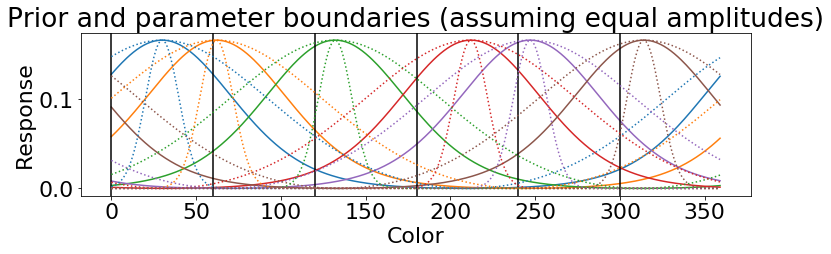

In [37]:
# Plot prior and parameter bounds
# Plot prior averages
vox_mu_basis_r = vox_mu_basis-10
channel_sd_r = [50 for chan in range(nchannels)]
vox_amp_basis_r = [1 for chan in range(nchannels)]
vox_amp_basis_r = sumfix(np.ones(nchannels))
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r))
plt.title('Prior and parameter boundaries (assuming equal amplitudes)') 
plt.ylabel('Response')
plt.xlabel('Color')
# plot vertical mu bounds
for chan in range(nchannels):
    plt.axvline(360/nchannels*chan,color='k')
channel_sd_r = np.ones(nchannels)*90
basis = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
# plot sd bounds
plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
for chan in np.arange(nchannels):
    plt.plot(basis[:,chan],':')
channel_sd_r = np.ones(nchannels)*10
basis = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
for chan in np.arange(nchannels):
    plt.plot(basis[:,chan],':')
# plt.savefig('prior_{}.png'.format(cur_roi), format='png', dpi=300)
plt.show()

### Posterior

In [387]:
# Load previous posterior
# posterior = pm.load_trace("indiv_k_4_channels_nodimreduce_all",indiv_k_4_channels)
posterior = pm.load_trace("shared_k_4_channels_all",shared_k_4_channels)
# posterior = pm.load_trace("shared_k_2_channels_lhd_rhv",shared_k_2_channels)

In [668]:
# cur_roi='simulation'
with shared_k_1_channels_nounif:   
    
    ## MCMC (NUTS) ##
    # note: running complicated models with MCMC will likely lead to
    # ridiculously long sampling times, lack of convergence, or stalling
    # in this case, VI may be preferable because
    # (1) VI takes much less time to run (although does not guarantee solution, 
    # but, practically speaking, neither does MCMC)
    # (2) VI might produce better fit than MCMC because data is too complex for MCMC (i.e., doesn't converge)
#     posterior = pm.sample(5000, tune=15000, chains=3)
#     pm.save_trace(posterior,"posterior_mcmc",overwrite=True)
    
    ## Variational inference ##
    approx = pm.FullRankADVI()
    approx.fit(50000)
#     approx.refine(900000) # if you want to keep sampling

    posterior = approx.approx.sample(1000)
#     save_obj(posterior, "shared_k_1_channels")
#     pm.save_trace(modelfit,"shared_k_1_channels",overwrite=True)

# pm.save_trace(posterior,"shared_k_4_channels_{}".format(cur_roi),overwrite=True)
print('saved posterior {}'.format(cur_roi))
pm.summary(posterior)

Finished [100%]: Average Loss = 9,504.3
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 9,504.3
INFO (theano.gof.compilelock): Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock


saved posterior rhd


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
kappa       0.610  0.002    0.609    0.612      0.000    0.000     945.0   
mu_0        0.677  0.091    0.511    0.845      0.003    0.002     926.0   
mu_deg_0  218.779  5.206  209.267  228.419      0.171    0.121     926.0   
sd_deg     89.946  0.085   89.840   90.000      0.003    0.002     945.0   

          ess_sd  ess_bulk  ess_tail  r_hat  
kappa      945.0    1030.0     975.0    NaN  
mu_0       925.0     927.0     944.0    NaN  
mu_deg_0   926.0     927.0     944.0    NaN  
sd_deg     945.0    1030.0     975.0    NaN

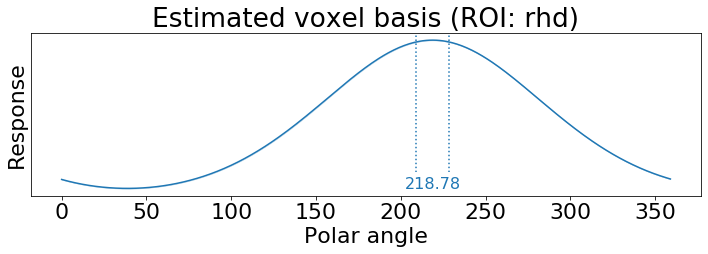

In [670]:
# Plot estimated voxel tunings
vox_mu_basis_r = [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
channel_sd_r = np.mean(posterior['sd_deg'])*np.ones(nchannels)
vox_amp_basis_r = [1,0]
vox_amp_basis_r = sumfix(vox_amp_basis_r)
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,np.ones(nchannels)*channel_sd_r,vox_amp_basis_r))
plt.title('Estimated voxel basis (ROI: {})'.format(cur_roi)) 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Polar angle')

## PLOTTING HDIS ##
# plot mu HDI intervals
vox_mu_basis_r0 = [pm.stats.hpd(posterior['mu_deg_{}'.format(chan)])[0] for chan in range(nchannels)]
vox_mu_basis_r1 = [pm.stats.hpd(posterior['mu_deg_{}'.format(chan)])[1] for chan in range(nchannels)]
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
for chan in range(nchannels):
    plt.axvline(vox_mu_basis_r0[chan],linestyle=':',color=colors[chan])
    plt.axvline(vox_mu_basis_r1[chan],linestyle=':',color=colors[chan])
# plot sd HDI intervals
# channel_sd_r = [pm.stats.hpd(posterior['sd_deg_{}'.format(chan)])[0] for chan in range(nchannels)]
channel_sd_r = pm.stats.hpd(posterior['sd_deg'])[0]*np.ones(nchannels)
basis0 = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
basis0 = np.array([basis0[i][0] for i in np.arange(len(basis0))])
channel_sd_r = pm.stats.hpd(posterior['sd_deg'])[1]*np.ones(nchannels)
basis1 = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
basis1 = np.array([basis1[i][0] for i in np.arange(len(basis1))])
plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
for chan in np.arange(nchannels):
    plt.fill_between(np.arange(360), basis0, basis1, alpha=0.2, color=colors[chan])

plt.text(vox_mu_basis_r[0],0,'{:.2f}'.format(vox_mu_basis_r[0]),
        horizontalalignment='center',fontsize=16,color=colors[0],
        bbox=dict(facecolor='white',edgecolor='white'))
# plt.savefig('{}.png'.format(cur_roi), format='png', dpi=300)
plt.show()

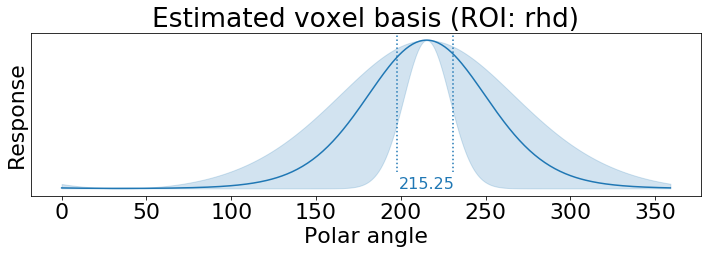

In [666]:
# Plot estimated voxel tunings
vox_mu_basis_r = [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
channel_sd_r = np.mean(posterior['sd_deg'])*np.ones(nchannels)
vox_amp_basis_r = [np.mean(posterior['p'][:,chan]) for chan in range(nchannels)]
vox_amp_basis_r = sumfix(vox_amp_basis_r)
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,np.ones(nchannels)*channel_sd_r,vox_amp_basis_r))
plt.title('Estimated voxel basis (ROI: {})'.format(cur_roi)) 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Polar angle')

## PLOTTING HDIS ##
# plot mu HDI intervals
vox_mu_basis_r0 = [pm.stats.hpd(posterior['mu_deg_{}'.format(chan)])[0] for chan in range(nchannels)]
vox_mu_basis_r1 = [pm.stats.hpd(posterior['mu_deg_{}'.format(chan)])[1] for chan in range(nchannels)]
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
for chan in range(nchannels):
    plt.axvline(vox_mu_basis_r0[chan],linestyle=':',color=colors[chan])
    plt.axvline(vox_mu_basis_r1[chan],linestyle=':',color=colors[chan])
# plot sd HDI intervals
# channel_sd_r = [pm.stats.hpd(posterior['sd_deg_{}'.format(chan)])[0] for chan in range(nchannels)]
channel_sd_r = pm.stats.hpd(posterior['sd_deg'])[0]*np.ones(nchannels)
basis0 = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
basis0 = np.array([basis0[i][0] for i in np.arange(len(basis0))])
channel_sd_r = pm.stats.hpd(posterior['sd_deg'])[1]*np.ones(nchannels)
basis1 = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
basis1 = np.array([basis1[i][0] for i in np.arange(len(basis1))])
plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
for chan in np.arange(nchannels):
    plt.fill_between(np.arange(360), basis0, basis1, alpha=0.2, color=colors[chan])

plt.text(vox_mu_basis_r[0],0,'{:.2f}'.format(vox_mu_basis_r[0]),
        horizontalalignment='center',fontsize=16,color=colors[0],
        bbox=dict(facecolor='white',edgecolor='white'))
# plt.savefig('{}.png'.format(cur_roi), format='png', dpi=300)
plt.show()

## Checking/validating the model

We can summarize all the results using the pm.summary() command. Feel free to examine the parameters and see what the 95% HDI (highest density interval aka HPD or highest posterior density) is. 95% HDIs indicate that the true parameter value has a 95% probability of lying within this interval. Values outside the intervals may be considered sufficiently implausible to be untenable (Lindley, 1965). 

In [10]:
pm.summary(posterior,include_circ=True)

mean         sd  mc_error     hpd_2.5    hpd_97.5  \
kappa       2.028864   4.393311  0.096433    0.609082    7.807011   
mu_0       -2.730759   0.447533  0.005040   -3.400448   -1.926128   
mu_1       -0.999362   0.329325  0.003664   -1.583675   -0.275118   
mu_2        0.495281   0.420699  0.005815   -0.261795    1.173992   
mu_3        2.178748   0.441686  0.004723    1.416382    2.879665   
p__0        0.092615   0.078417  0.001505    0.000015    0.248047   
p__1        0.147772   0.097992  0.002028    0.002056    0.327926   
p__2        0.108560   0.083101  0.001610    0.000068    0.268883   
p__3        0.097113   0.080111  0.001372    0.000016    0.253508   
p__4        0.553941   0.272938  0.005903    0.071626    0.985272   
mu_deg_0   23.539016  25.641768  0.288768  -14.831314   69.640972   
mu_deg_1  122.740794  18.868957  0.209921   89.262124  164.236921   
mu_deg_2  208.377495  24.104271  0.333181  165.000251  247.264788   
mu_deg_3  304.833085  25.306727  0.270629  261.152728  344.992653   
sd_deg     71.396818  19.671585  0.431953   21.244799   89.996677   

                n_eff      Rhat  
kappa     1889.116319  1.000483  
mu_0      5804.125285  1.000275  
mu_1      6805.628593  1.000344  
mu_2      6019.543667  1.000114  
mu_3      6758.219855  1.000153  
p__0      2752.842085  0.999921  
p__1      2258.287077  1.000278  
p__2      2588.465649  1.000442  
p__3      2979.990007  0.999983  
p__4      2033.221832  1.000117  
mu_deg_0  5804.125285  1.000275  
mu_deg_1  6805.628593  1.000344  
mu_deg_2  6019.543667  1.000114  
mu_deg_3  6758.219855  1.000153  
sd_deg    1877.814953  1.000473

In [47]:
# posterior = approx.approx.sample(2000)
pm.summary(posterior,include_circ=True)

mean        sd  mc_error   hpd_2.5   hpd_97.5        n_eff  \
mua     0.017403  0.004324  0.000048  0.008631   0.025560  8264.457163   
mub    -3.122792  0.093534  0.001388 -3.134871  -3.114385  4508.839871   
kappas  9.744692  0.139764  0.001551  9.473208  10.017277  8569.465579   
p__0    0.593441  0.004909  0.000051  0.583337   0.602424  7451.950947   
p__1    0.406559  0.004909  0.000051  0.397576   0.416663  7451.950947   

            Rhat  
mua     0.999764  
mub     0.999974  
kappas  0.999953  
p__0    0.999859  
p__1    0.999859

In [216]:
pm.summary(posterior,include_circ=True) # no noise

mean         sd  mc_error     hpd_2.5    hpd_97.5       n_eff  \
mu_0       -1.686135   0.838515  0.082976   -2.907970   -1.047267    1.502115   
mu_1       -0.770660   0.076390  0.007211   -0.881701   -0.674902    1.641203   
mu_2        2.494311   0.900053  0.089549    1.211139    3.141592    1.500749   
kappa_0    26.472470   3.287545  0.174802   21.383479   33.111604  214.973574   
kappa_1    18.399905   4.441683  0.400119   12.052882   24.928710    1.771814   
kappa_2    22.792421   6.345166  0.611296   15.622646   33.327701    1.564298   
p__0        0.410876   0.011554  0.000890    0.386912    0.430464    2.273611   
p__1        0.155893   0.061841  0.005420    0.063856    0.246993    1.929870   
p__2        0.345546   0.098760  0.009358    0.225812    0.489857    1.632033   
p__3        0.087685   0.033655  0.003279    0.027440    0.124018    1.571435   
mu_deg_0   83.391595  48.043373  4.754198   13.385609  119.996019    1.502115   
mu_deg_1  135.844436   4.376852  0.413181  129.482243  141.330987    1.641203   
mu_deg_2  322.913507  51.569215  5.130778  249.393143  359.999969    1.500749   
sd_deg_0   11.312482   0.719626  0.038152   10.005148   12.488841  215.108548   
sd_deg_1   13.895094   1.857674  0.174978   11.540556   16.772412    1.635108   
sd_deg_2   12.489629   1.664165  0.159292   10.000923   14.740506    1.580058   

               Rhat  
mu_0      32.045790  
mu_1       3.618057  
mu_2      82.057249  
kappa_0    1.022338  
kappa_1    2.674380  
kappa_2    5.092823  
p__0       1.768073  
p__1       2.242701  
p__2       3.736961  
p__3       5.065426  
mu_deg_0  32.045790  
mu_deg_1   3.618057  
mu_deg_2  82.057249  
sd_deg_0   1.016671  
sd_deg_1   3.648154  
sd_deg_2   4.571220

In [82]:
pm.summary(posterior,include_circ=True) #noise=2

mean         sd  mc_error     hpd_2.5    hpd_97.5  \
mu_0       -2.972030   0.079637  0.003178   -3.084944   -2.853343   
mu_1       -1.835209   0.031203  0.000519   -1.897404   -1.774974   
mu_2       -0.648819   0.045445  0.000990   -0.737963   -0.559078   
mu_3        0.768427   0.104900  0.002549    0.596793    0.960304   
mu_4        1.299126   0.199807  0.004406    1.047268    1.724778   
mu_5        2.535030   0.110020  0.003827    2.357686    2.752170   
kappa_0    10.355157   4.906041  0.118990    1.312256   19.478106   
kappa_1     8.919465   3.038424  0.104760    4.221556   14.833232   
kappa_2     3.940936   0.979554  0.024630    2.049192    5.737159   
kappa_3    12.176708   7.039498  0.160334    3.114569   26.965552   
kappa_4    13.095098   7.762602  0.155223    2.462286   30.051030   
kappa_5    25.763777   7.130686  0.156741   10.156764   33.327590   
p__0        0.329296   0.094203  0.002603    0.117385    0.478395   
p__1        0.074986   0.035344  0.001239    0.032078    0.145669   
p__2        0.153589   0.033246  0.001011    0.087503    0.220533   
p__3        0.241707   0.043047  0.001183    0.173930    0.331367   
p__4        0.108728   0.059656  0.001532    0.018625    0.217345   
p__5        0.072775   0.052845  0.001252    0.000031    0.166934   
p__6        0.018919   0.014299  0.000322    0.002893    0.035687   
mu_deg_0    9.715205   4.562883  0.182092    3.245724   16.515505   
mu_deg_1   74.850269   1.787780  0.029713   71.286733   78.301510   
mu_deg_2  142.825401   2.603792  0.056695  137.717840  147.967164   
mu_deg_3  224.027616   6.010311  0.146043  214.193748  235.021369   
mu_deg_4  254.434431  11.448119  0.252465  240.004017  278.822499   
mu_deg_5  325.246542   6.303656  0.219246  315.085445  337.687751   
sd_deg_0   20.747363   8.037343  0.299743   10.505622   34.715321   
sd_deg_1   20.619018   3.308342  0.094730   14.405247   27.686487   
sd_deg_2   32.528212   5.557514  0.147459   23.938280   44.043341   
sd_deg_3   19.349454   6.068410  0.158727   10.002796   29.720904   
sd_deg_4   18.989381   7.087247  0.145109   10.004421   30.075076   
sd_deg_5   12.324838   5.063175  0.139558   10.000849   18.460493   

                n_eff      Rhat  
mu_0       605.788467  1.001898  
mu_1      2675.128455  1.000411  
mu_2      1837.913056  1.001299  
mu_3      1258.308524  0.999944  
mu_4      1427.357892  1.000496  
mu_5       811.285774  1.001638  
kappa_0   1510.305954  1.001397  
kappa_1    803.999824  1.003521  
kappa_2   1323.281805  1.000787  
kappa_3   1368.348923  1.000247  
kappa_4   1889.922080  1.001667  
kappa_5   2245.707416  1.000445  
p__0      1239.414278  1.000041  
p__1       903.850860  1.000303  
p__2       983.229472  1.001886  
p__3      1184.240378  1.000917  
p__4      1062.024743  1.000116  
p__5      1305.098040  1.000335  
p__6      1906.474791  1.000430  
mu_deg_0   605.788467  1.001898  
mu_deg_1  2675.128455  1.000411  
mu_deg_2  1837.913056  1.001299  
mu_deg_3  1258.308524  0.999944  
mu_deg_4  1427.357892  1.000496  
mu_deg_5   811.285774  1.001638  
sd_deg_0   757.679905  1.001891  
sd_deg_1  1105.293841  1.002078  
sd_deg_2  1216.139979  1.001216  
sd_deg_3  1119.774484  1.000090  
sd_deg_4  2005.372253  1.001757  
sd_deg_5  1321.782666  1.000099

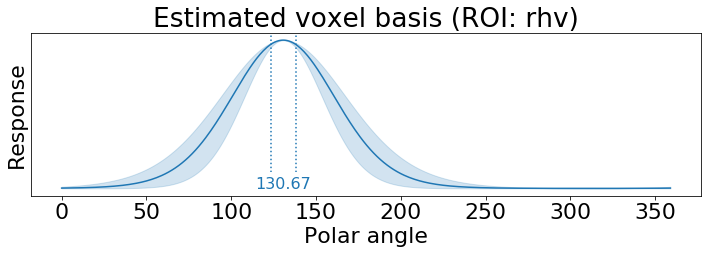

In [122]:
# # Plot simulated voxel tunings (ground truth)               
# plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis,channel_sd,vox_amp_basis))
# plt.title('Underlying voxel basis (ground truth)') 
# plt.ylabel('Response'); plt.yticks([])
# plt.xlabel('Color')
# plt.show()

# Plot estimated voxel tunings
vox_mu_basis_r = [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
channel_sd_r = np.mean(posterior['sd_deg'])*np.ones(nchannels)
vox_amp_basis_r = [np.mean(posterior['p'][:,chan]) for chan in range(nchannels)]
vox_amp_basis_r = sumfix(vox_amp_basis_r)
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,np.ones(nchannels)*channel_sd_r,vox_amp_basis_r))
plt.title('Estimated voxel basis (ROI: {})'.format(cur_roi)) 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Polar angle')

## PLOTTING HDIS ##
# plot mu HDI intervals
vox_mu_basis_r0 = [pm.stats.hpd(posterior['mu_deg_{}'.format(chan)])[0] for chan in range(nchannels)]
vox_mu_basis_r1 = [pm.stats.hpd(posterior['mu_deg_{}'.format(chan)])[1] for chan in range(nchannels)]
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
for chan in range(nchannels):
    plt.axvline(vox_mu_basis_r0[chan],linestyle=':',color=colors[chan])
    plt.axvline(vox_mu_basis_r1[chan],linestyle=':',color=colors[chan])
# plot sd HDI intervals
# channel_sd_r = [pm.stats.hpd(posterior['sd_deg_{}'.format(chan)])[0] for chan in range(nchannels)]
channel_sd_r = pm.stats.hpd(posterior['sd_deg'])[0]*np.ones(nchannels)
basis0 = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
basis0 = np.array([basis0[i][0] for i in np.arange(len(basis0))])
channel_sd_r = pm.stats.hpd(posterior['sd_deg'])[1]*np.ones(nchannels)
basis1 = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
basis1 = np.array([basis1[i][0] for i in np.arange(len(basis1))])
plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
for chan in np.arange(nchannels):
    plt.fill_between(np.arange(360), basis0, basis1, alpha=0.2, color=colors[chan])
# # plot amp HDI intervals 
# plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
# for chan in np.arange(nchannels):
#     plt.plot(basis[:,chan],':')
# vox_amp_basis_r = sumfix(pm.stats.hpd(posterior['p'])[:,1])
# basis = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
# plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
# for chan in np.arange(nchannels):
#     plt.plot(basis[:,chan],':')

plt.text(vox_mu_basis_r[0],0,'{:.2f}'.format(vox_mu_basis_r[0]),
        horizontalalignment='center',fontsize=16,color=colors[0],
        bbox=dict(facecolor='white',edgecolor='white'))
plt.savefig('{}.png'.format(cur_roi), format='png', dpi=300)
plt.show()

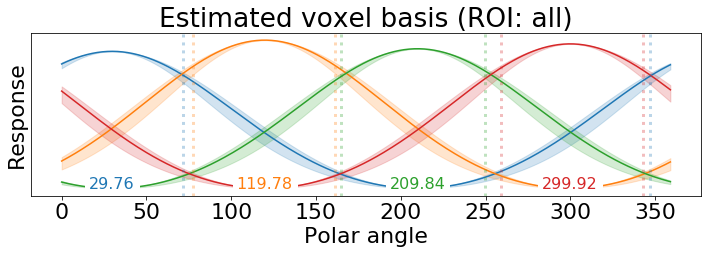

In [1113]:
# # Plot simulated voxel tunings (ground truth)               
# plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis,channel_sd,vox_amp_basis))
# plt.title('Underlying voxel basis (ground truth)') 
# plt.ylabel('Response'); plt.yticks([])
# plt.xlabel('Color')
# plt.show()

# Plot estimated voxel tunings
vox_mu_basis_r = [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
channel_sd_r = np.mean(posterior['sd_deg'])*np.ones(nchannels)
vox_amp_basis_r = [np.mean(posterior['p'][:,chan]) for chan in range(nchannels)]
vox_amp_basis_r = sumfix(vox_amp_basis_r)
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,np.ones(nchannels)*channel_sd_r,vox_amp_basis_r))
plt.title('Estimated voxel basis (ROI: {})'.format(cur_roi)) 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Polar angle')

## PLOTTING HDIS ##
# plot mu HDI intervals
vox_mu_basis_r0 = [pm.stats.hpd(posterior['mu_deg_{}'.format(chan)])[0] for chan in range(nchannels)]
vox_mu_basis_r1 = [pm.stats.hpd(posterior['mu_deg_{}'.format(chan)])[1] for chan in range(nchannels)]
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
for chan in range(nchannels):
    plt.axvline(within360(vox_mu_basis_r0[chan]),linestyle=':',linewidth=3,alpha=.3,color=colors[chan])
    plt.axvline(within360(vox_mu_basis_r1[chan]),linestyle=':',linewidth=3,alpha=.3,color=colors[chan])
# plot sd HDI intervals
# channel_sd_r = [pm.stats.hpd(posterior['sd_deg_{}'.format(chan)])[0] for chan in range(nchannels)]
channel_sd_r0 = pm.stats.hpd(posterior['sd_deg'])[0]*np.ones(nchannels)
basis0 = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r0,vox_amp_basis_r)
channel_sd_r1 = pm.stats.hpd(posterior['sd_deg'])[1]*np.ones(nchannels)
basis1 = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r1,vox_amp_basis_r)
plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
for chan in np.arange(nchannels):
    plt.fill_between(np.arange(360), 
                     np.array([basis0[i,chan] for i in np.arange(len(basis0))]), 
                     np.array([basis1[i,chan] for i in np.arange(len(basis1))]), 
                     alpha=0.2, color=colors[chan])
# # plot amp HDI intervals 
# plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
# for chan in np.arange(nchannels):
#     plt.plot(basis[:,chan],':')
# vox_amp_basis_r = sumfix(pm.stats.hpd(posterior['p'])[:,1])
# basis = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
# plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
# for chan in np.arange(nchannels):
#     plt.plot(basis[:,chan],':')
for chan in np.arange(nchannels):
    plt.text(vox_mu_basis_r[chan],0,'{:.2f}'.format(vox_mu_basis_r[chan]),
            horizontalalignment='center',fontsize=16,color=colors[chan],
            bbox=dict(facecolor='white',edgecolor='white'))
plt.savefig('img/{}.png'.format(cur_roi), format='png', dpi=300)
plt.show()

In [854]:
# # Plot simulated voxel tunings (ground truth)               
# plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis,channel_sd,vox_amp_basis))
# plt.title('Underlying voxel basis (ground truth)') 
# plt.ylabel('Response'); plt.yticks([])
# plt.xlabel('Color')
# plt.show()

# Plot estimated voxel tunings
vox_mu_basis_r = [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
channel_sd_r = [np.mean(posterior['sd_deg_{}'.format(chan)]) for chan in range(nchannels)]
vox_amp_basis_r = [np.mean(posterior['p'][:,chan]) for chan in range(nchannels)]
vox_amp_basis_r = sumfix(vox_amp_basis_r)
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,np.ones(nchannels)*channel_sd_r,vox_amp_basis_r))
plt.title('Estimated voxel basis (ROI: {})'.format(cur_roi)) 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Polar angle')

## PLOTTING HDIS ##
# plot mu HDI intervals
vox_mu_basis_r0 = [pm.stats.hpd(posterior['mu_deg_{}'.format(chan)])[0] for chan in range(nchannels)]
vox_mu_basis_r1 = [pm.stats.hpd(posterior['mu_deg_{}'.format(chan)])[1] for chan in range(nchannels)]
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
for chan in range(nchannels):
    plt.axvline(within360(vox_mu_basis_r0[chan]),linestyle=':',linewidth=3,alpha=.3,color=colors[chan])
    plt.axvline(within360(vox_mu_basis_r1[chan]),linestyle=':',linewidth=3,alpha=.3,color=colors[chan])
# plot sd HDI intervals
# channel_sd_r = [pm.stats.hpd(posterior['sd_deg_{}'.format(chan)])[0] for chan in range(nchannels)]
channel_sd_r0 = [pm.stats.hpd(posterior['sd_deg_{}'.format(chan)])[0] for chan in range(nchannels)]
basis0 = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r0,vox_amp_basis_r)
channel_sd_r1 = [pm.stats.hpd(posterior['sd_deg_{}'.format(chan)])[1] for chan in range(nchannels)]
basis1 = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r1,vox_amp_basis_r)
plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
for chan in np.arange(nchannels):
    plt.fill_between(np.arange(360), 
                     np.array([basis0[i,chan] for i in np.arange(len(basis0))]), 
                     np.array([basis1[i,chan] for i in np.arange(len(basis1))]), 
                     alpha=0.2, color=colors[chan])
# plot amp HDI intervals 
plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
for chan in np.arange(nchannels):
    plt.plot(basis[:,chan],':')
vox_amp_basis_r = sumfix(pm.stats.hpd(posterior['p'])[:,1])
basis = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
for chan in np.arange(nchannels):
    plt.plot(basis[:,chan],':')
for chan in np.arange(nchannels):
    plt.text(vox_mu_basis_r[chan],0,'{:.2f}'.format(vox_mu_basis_r[chan]),
            horizontalalignment='center',fontsize=16,color=colors[chan],
            bbox=dict(facecolor='white',edgecolor='white'))
plt.savefig('posterior/{}.png'.format(name), format='png', dpi=300)
plt.show()

KeyError: 'Unknown variable mu_deg_0'

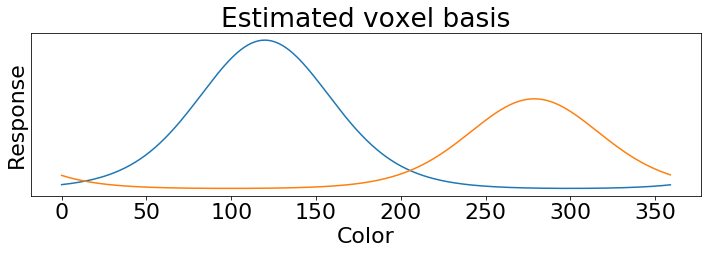

In [544]:
# # Plot simulated voxel tunings (ground truth)               
# plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis,channel_sd,vox_amp_basis))
# plt.title('Underlying voxel basis (ground truth)') 
# plt.ylabel('Response'); plt.yticks([])
# plt.xlabel('Color')
# plt.show()

# Plot estimated voxel tunings
vox_mu_basis_r = [circmean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
channel_sd_r = np.mean(posterior['sd_deg'])*np.ones(nchannels)
vox_amp_basis_r = [np.mean(posterior['p'][:,chan]) for chan in range(nchannels)]
vox_amp_basis_r = sumfix(vox_amp_basis_r)
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,np.ones(nchannels)*channel_sd_r,vox_amp_basis_r))
plt.title('Estimated voxel basis') 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Color')
plt.show()

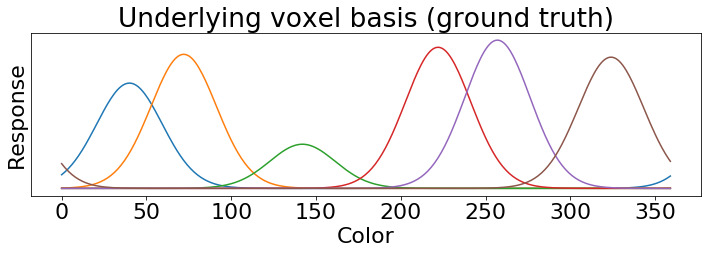

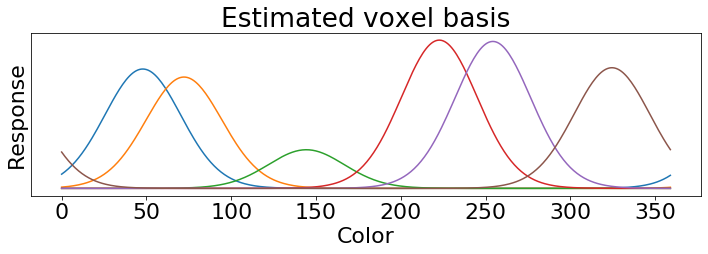

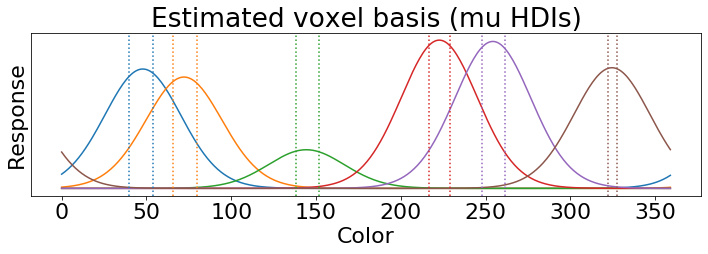

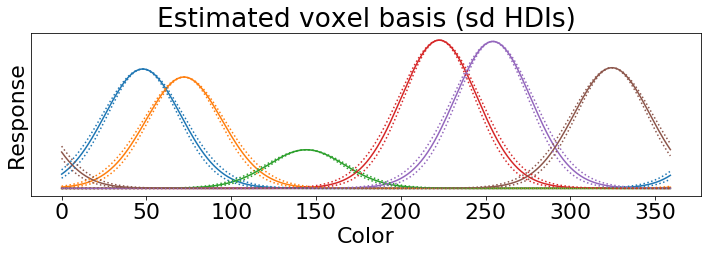

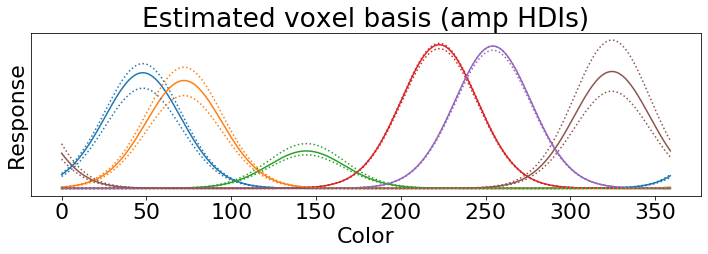

In [254]:
# Plot simulated voxel tunings (ground truth)               
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis,channel_sd,vox_amp_basis))
plt.title('Underlying voxel basis (ground truth)') 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Color')
plt.show()


# Plot estimated voxel tunings
vox_mu_basis_r = [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
# channel_sd_r = [np.mean(posterior['sd_deg_{}'.format(chan)]) for chan in range(nchannels)]
channel_sd_r = np.mean(posterior['sd_deg'])*np.ones(nchannels)
vox_amp_basis_r = [np.mean(posterior['p'][:,chan]) for chan in range(nchannels)]
vox_amp_basis_r = sumfix(vox_amp_basis_r)
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r))
plt.title('Estimated voxel basis') 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Color')
plt.show()

## PLOTTING HDIS ##

# Plot estimated voxel tunings
vox_mu_basis_r = [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
vox_amp_basis_r = [np.mean(posterior['p'][:,chan]) for chan in range(nchannels)]
vox_amp_basis_r = sumfix(vox_amp_basis_r)
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r))
plt.title('Estimated voxel basis (mu HDIs)') 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Color')
# plot mu HDI intervals
vox_mu_basis_r0 = [pm.stats.hpd(posterior['mu_deg_{}'.format(chan)])[0] for chan in range(nchannels)]
vox_mu_basis_r1 = [pm.stats.hpd(posterior['mu_deg_{}'.format(chan)])[1] for chan in range(nchannels)]
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
for chan in range(nchannels):
    plt.axvline(vox_mu_basis_r0[chan],linestyle=':',color=colors[chan])
    plt.axvline(vox_mu_basis_r1[chan],linestyle=':',color=colors[chan])
plt.show()
    
# Plot simulated voxel tunings (ground truth)               
vox_mu_basis_r = [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
vox_amp_basis_r = [np.mean(posterior['p'][:,chan]) for chan in range(nchannels)]
vox_amp_basis_r = sumfix(vox_amp_basis_r)
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r))
plt.title('Estimated voxel basis (sd HDIs)') 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Color')
# plot sd HDI intervals
# channel_sd_r = [pm.stats.hpd(posterior['sd_deg_{}'.format(chan)])[0] for chan in range(nchannels)]
channel_sd_r = pm.stats.hpd(posterior['sd_deg'])[0]*np.ones(nchannels)
basis = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
for chan in np.arange(nchannels):
    plt.plot(basis[:,chan],':')
channel_sd_r = pm.stats.hpd(posterior['sd_deg'])[1]*np.ones(nchannels)
basis = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
for chan in np.arange(nchannels):
    plt.plot(basis[:,chan],':')
plt.show()

# Plot simulated voxel tunings (ground truth)               
vox_mu_basis_r = [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
channel_sd_r = np.mean(posterior['sd_deg'])*np.ones(nchannels)
vox_amp_basis_r = [np.mean(posterior['p'][:,chan]) for chan in range(nchannels)]
vox_amp_basis_r = sumfix(vox_amp_basis_r)
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r))
plt.title('Estimated voxel basis (amp HDIs)') 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Color')
# plot amp HDI intervals 
vox_amp_basis_r = sumfix(pm.stats.hpd(posterior['p'])[:,0])
basis = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
for chan in np.arange(nchannels):
    plt.plot(basis[:,chan],':')
vox_amp_basis_r = sumfix(pm.stats.hpd(posterior['p'])[:,1])
basis = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
for chan in np.arange(nchannels):
    plt.plot(basis[:,chan],':')
plt.show()

### Trace plots
Trace plots show the history of sampling for each Markov chain. Good to visually see that chains never got stuck, never explored weird divergences, and don't show high serial correlation (i.e., effective sample size is too low such that chains were slow to explore and show few independent observations).

INFO (theano.gof.compilelock): Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3d58b358>,
      dtype=object)

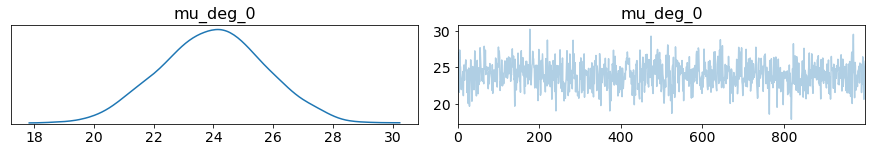

In [570]:
pm.traceplot(posterior,var_names=["mu_deg_0"])

### Gelman-Rubin diagnostic (MCMC only)

Tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical. Gelman et al. (2004) recommend R to be less than 1.1. You also get this output using pm.summary().

Gelman, A., Carlin, J. B., Stern, H. S., and Rubin, D. B. (2004). Bayesian Data
Analysis. Chapman & Hall/CRC, Boca Raton, FL,.

In [ ]:
pm.diagnostics.gelman_rubin(posterior,var_names=["mu_deg_0"])

### Geweke diagnostic

Return z-scores for convergence diagnostics. Compare the mean of the first % of series with the mean of the last % of series. x is divided into a number of segments for which this difference is computed. If the series is converged, this score should oscillate between -1 and 1. If say, the first 10% of the plot is significantly different from the rest of the plot, this might indicate a longer burn-in is necessary. If adequate mixing is not observed, we could try doing burn-in (e.g., posterior = posterior[500:]) to discard the first half of all samples across chains, or refine the model.

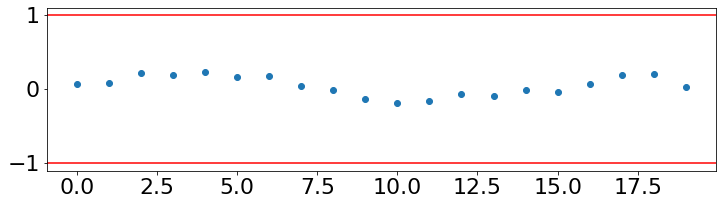

In [572]:
plt.plot(pm.geweke(posterior['mu_deg_0'])[:,1], 'o')
plt.axhline(1, c='red'); _ = plt.axhline(-1, c='red')
plt.gca().margins(0.05)

### Overlaying posterior over the prior

It's very helpful to better understand your prior by plotting it alongside your posterior. It allows you to see how the sampler went from a diffuse, moderately informed prior to a confident, peaky posterior distribution.

In [ ]:
# load prior directly without running model
prior = load_obj('prior')

In [100]:
sns.distplot(prior['mu_deg_0'], label='Prior', hist=False)
ax = sns.distplot(posterior['mu_deg_0'], label='Posterior', hist=False)
ax.legend()

NameError: name 'prior' is not defined

### Posterior predictive check

The idea behind posterior predictive checks is to generate data from the model using parameters from draws from the posterior. The posterior distribution should be approximating the underlying distribution (i.e., the raw observations that were input into the model). post_pred contains a dataset generated in this fashion (in blue), compared to the input data (aggregate degrees of error histogram, in red).

For more information see https://docs.pymc.io/notebooks/posterior_predictive.html

In [ ]:
# load posterior predictive directly instead of running model
post_pred = load_obj('post_pred')

In [265]:
with shared_k_6_channels:
    post_pred = pm.sample_posterior_predictive(posterior, var_names = ['y'], samples=1)
    print(post_pred['y'].shape)
    

  0%|          | 0/1 [00:26<?, ?it/s]


KeyError: 'y'

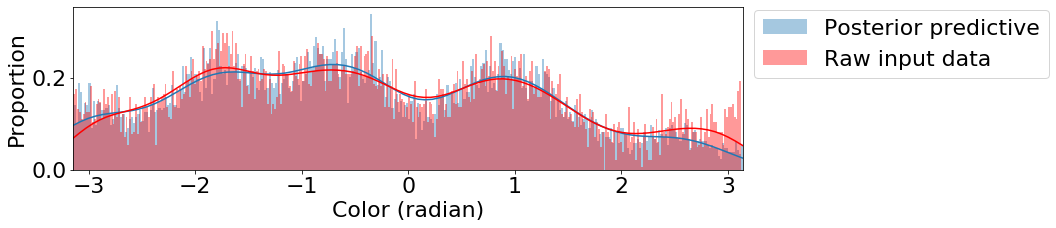

In [99]:
ax_data = sns.distplot(post_pred['y'][0,:], bins=len(np.unique(obs)), label='Posterior predictive')
ax_ppc = sns.distplot(obs, bins=len(np.unique(obs)), label='Raw input data', color='red')
ax_ppc.set_xlim(-np.pi, np.pi)
ax_ppc.set(xlabel="Color (radian)", ylabel="Proportion")
ax_ppc.legend(bbox_to_anchor=(1, 1.05))
plt.show()


In [ ]:
# Construct a new model with the held out datap
with shared_k_4_channels:
    ppc = pm.sample_posterior_predictive(posterior)
    plt.figure()
    plt.plot(hold_out_x, ppc['obs'].T, '.b', alpha=0.01)
    plt.plot(hold_out_x, hold_out_y, '-or')
    proxy_arts = [plt.Line2D([0], [0], marker='.', linestyle='', color='b'),
                  plt.Line2D([0], [0], marker='o', linestyle='-', color='r')]
    plt.legend(handles=proxy_arts, labels=['prediction', 'hold out data'])
    plt.title('Posterior predictive on the test set')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta]
100%|██████████| 1000/1000 [00:01<00:00, 788.35it/s]


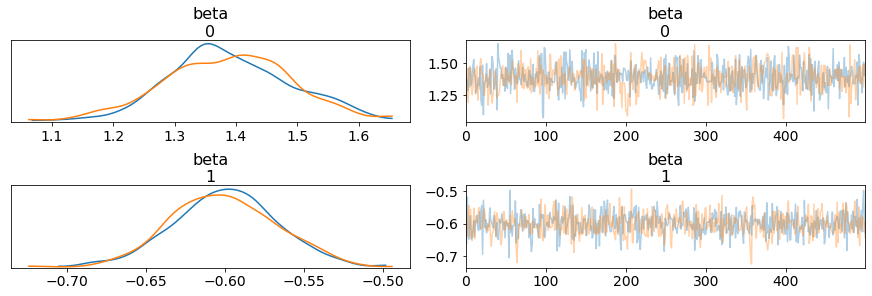

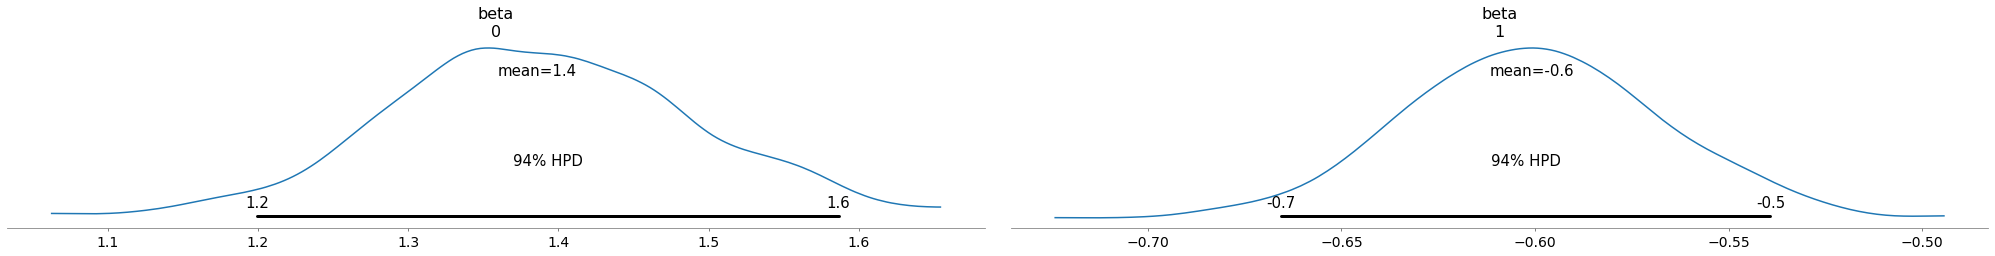

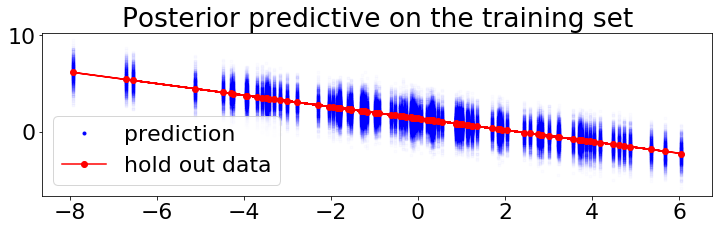

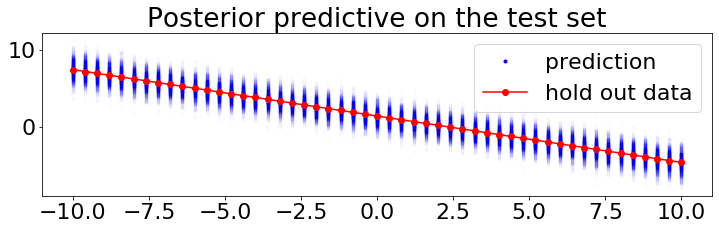

In [1114]:
def model_factory(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    with pm.Model() as model:
        beta = pm.Normal('beta', mu=0, sigma=1, shape=(2,))
        x_ = x.flatten()
        X = np.column_stack((np.ones_like(x_), x_))
        # If you enclose mu in Deterministic it will fail as #3346
        mu = tt.tensordot(X, beta, axes=[1, 0])
        pm.Normal('obs', mu=mu, sigma=1., observed=y)
    return model

BETA = np.array([1.4, -0.6])
train_x = np.random.randn(100) * 3
train_y = np.polyval(BETA[::-1], train_x)
hold_out_x = np.linspace(-10, 10, 51)
hold_out_y = np.polyval(BETA[::-1], hold_out_x)

# Perform the training to get the trace
with model_factory(train_x, train_y) as model:
    train_trace = pm.sample()
    pm.traceplot(train_trace)
    pm.plot_posterior(train_trace)
    ppc = pm.sample_posterior_predictive(train_trace)
    plt.figure()
    plt.plot(train_x, ppc['obs'].T, '.b', alpha=0.01)
    plt.plot(train_x, train_y, '-or')
    proxy_arts = [plt.Line2D([0], [0], marker='.', linestyle='', color='b'),
                  plt.Line2D([0], [0], marker='o', linestyle='-', color='r')]
    plt.legend(handles=proxy_arts, labels=['prediction', 'hold out data'])
    plt.title('Posterior predictive on the training set')

# Construct a new model with the held out data
with model_factory(hold_out_x, hold_out_y) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
    plt.figure()
    plt.plot(hold_out_x, ppc['obs'].T, '.b', alpha=0.01)
    plt.plot(hold_out_x, hold_out_y, '-or')
    proxy_arts = [plt.Line2D([0], [0], marker='.', linestyle='', color='b'),
                  plt.Line2D([0], [0], marker='o', linestyle='-', color='r')]
    plt.legend(handles=proxy_arts, labels=['prediction', 'hold out data'])
    plt.title('Posterior predictive on the test set')

## Model comparison

What if we don't know whether a 6- or 7-channel encoding model produces the best fit? We can estimate how well each model fits the data while penalizing complexity using the measures of WAIC and PSIS-LOO.

WAIC (Watanabe 2010) is a fully Bayesian criterion for estimating out-of-sample expectation, using the computed log pointwise posterior predictive density (LPPD) and correcting for the effective number of parameters to adjust for overfitting.

LOO cross-validation is an estimate of the out-of-sample predictive fit. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. Vehtari et al. (2016) introduced an efficient computation of LOO from MCMC samples, which are corrected using Pareto-smoothed importance sampling (PSIS) to provide an estimate of point-wise out-of-sample prediction accuracy.

In [295]:
# load posteriors without running models
posteriorA = pm.load_trace("indiv_posterior_all",indiv_k_4_channels)
posteriorB = pm.load_trace("posterior_all",shared_k_4_channels)

In [296]:
indiv_k_4_channels.name = "indiv_k_4_channels"
shared_k_4_channels.name = "shared_k_4_channels"

waic_results = pm.compare({indiv_k_4_channels: posteriorA, 
            shared_k_4_channels: posteriorB})

loo_results = pm.compare({indiv_k_4_channels: posteriorA, 
            shared_k_4_channels: posteriorB}, ic="LOO")

WAIC pWAIC dWAIC weight    SE   dSE var_warn
shared_k_4_channels  18701.8  4.04     0   0.93  3.73     0        0
indiv_k_4_channels   18703.1  5.99  1.33   0.07  3.75  2.49        0

LOO  pLOO  dLOO weight    SE   dSE shape_warn
shared_k_4_channels  18701.8  4.04     0   0.93  3.73     0          0
indiv_k_4_channels   18703.1  5.99  1.34   0.07  3.75  2.49          0

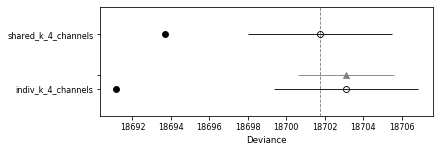

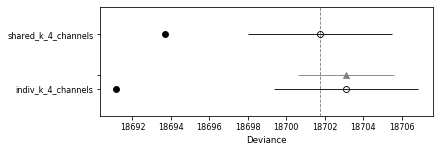

In [297]:
display(waic_results)
display(loo_results)
pm.compareplot(waic_results)
pm.compareplot(loo_results)
del posteriorA; del posteriorB; # clear processing space

Above is a summary plot of WAIC and LOO results. Empty circle: WAIC/LOO value, where lower value indicates better fit. Black error bars are standard deviation. Vertical dashed line indicates lowest WAIC/LOO value of the possible models. Filled black dots are the in-sample deviance of each model. Gray triangle indicates the WAIC/LOO difference between the model and the best-fitting model, with gray error bar denoting standard error of the difference in WAIC/LOO values.

In other words, the gray error bar approximates the uncertainty of WAIC/LOO estimates. If the gray error bar does not overlap with the vertical dotted line (the best-fit model estimate), then this demonstrates that the model with the lowest WAIC/LOO estimate is the best-fitting model.

Note that in the WAIC table, if var_warn = 1, this occurs if posterior variance of the log predictive densities exceeds 0.4 and suggests unreliable WAIC estimates (Vehtari, Gelman, & Gabry, 2016). Similarly, for the LOO table, shape_warn will equal 1 if the pareto distribution is greater than 0.7 for one or more samples, and this would also suggest unreliable estimates. 

# Inverted Encoding Model
## Create Forward Model & Design Matrix

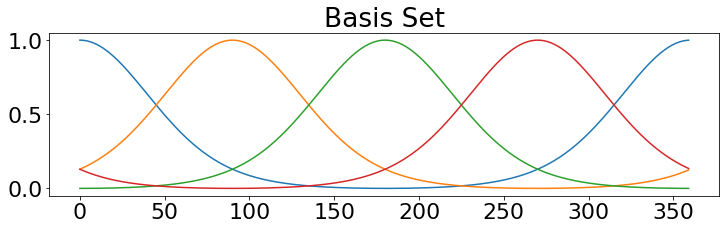

In [6]:
nchannels=4
# Plot chosen basis set

# basis_set = make_vonmises_iter(np.linspace(0,359,360),
#          [circmean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)],
# #          np.mean(posterior['sd_deg'])*np.ones(nchannels),
#          [np.mean(posterior['sd_deg_{}'.format(chan)]) for chan in range(nchannels)],
#          sumfix([np.mean(posterior['p'][:,chan]) for chan in range(nchannels)]))
# basis_points = [circmean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
# # basis_sds = np.mean(posterior['sd_deg'])*np.ones(nchannels)
# basis_sds = [np.mean(posterior['sd_deg_{}'.format(chan)]) for chan in range(nchannels)]

# basis_set = np.full((360,nchannels+1),np.nan)
# basis_set = make_vonmises_iter_unif(np.linspace(0,359,360),
#          [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)],
#          np.mean(posterior['sd_deg'])*np.ones(nchannels),
# #          [np.mean(posterior['sd_deg_{}'.format(chan)]) for chan in range(nchannels)],
#          np.mean(posterior['p'][:,nchannels]),
#          [np.mean(posterior['p'][:,chan]) for chan in range(nchannels)])
# basis_sds = np.mean(posterior['sd_deg'])*np.ones(nchannels)
# basis_points = [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]

# basis_set_iiem_indiv=np.full((360,nchannels),np.nan)
# basis_set_iiem_indiv[:,:nchannels] = make_vonmises_iter(np.linspace(0,359,360),
#          [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)],
#          [np.mean(posterior['sd_deg_{}'.format(chan)]) for chan in range(nchannels)],
#          [np.mean(posterior['p'][:,chan]) for chan in range(nchannels)])
# basis_points = [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]

basis_set = make_vonmises_iter(np.linspace(0,359,360),
                    np.linspace(0,360-(360/nchannels),nchannels),
                    50*np.ones(nchannels),
                    np.ones(nchannels))
basis_sds = 50*np.ones(nchannels)
basis_points = np.linspace(0,360-(360/nchannels),nchannels)

# basis_set = make_vonmises_iter2(np.linspace(0,359,360),
#                     vox_mu_basis,
#                     50*np.ones(nchannels),
#                     np.ones(nchannels))
# basis_points = np.linspace(0,360-(360/nchannels),nchannels)

# if np.any(np.round(np.sum(basis_set,axis=1),3)!=1):
#     raise Exception("Not every feature sums weights to 1")

plt.plot(basis_set[:,:])
plt.title('Basis Set') 
# plt.ylabel('');plt.yticks([]);plt.xlabel('')
# plt.ylim([basis_set[0,-1],np.max(basis_set)])
# plt.savefig('prior.eps', format='eps', dpi=300)
plt.show()

# # Plot actual voxel tunings:
# for vox in np.arange(nvoxels):
#     if vox <= 25:
#         plt.scatter(trial_features,trial_by_vox[:,vox])
# plt.xlabel('Color')
# plt.ylabel('Response')
# plt.yticks([0,np.max(trial_by_vox[:,vox])//2,np.max(trial_by_vox[:,vox])], [0,1])
# plt.title('First 25 Voxel Responses')
# plt.show()

## Standard Basis

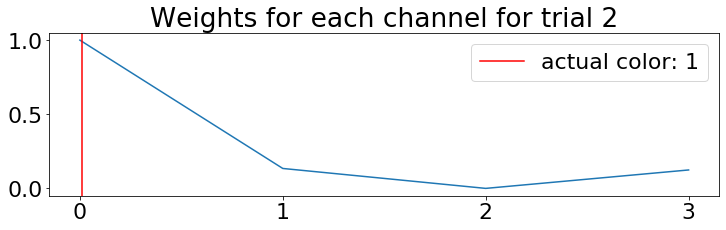

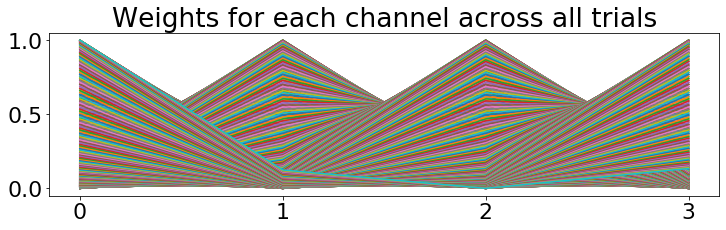

In [7]:
trial_weights = basis_set[trial_features,:]

trial = 1
plt.plot(trial_weights[trial,:])
plt.title("Weights for each channel for trial {}".format(trial+1))
#np.where(basis_points==trial_features[trial])[0][0]
plt.axvline(trial_features[trial]/360 * nchannels,color='red',label="actual color: {}".format(trial_features[trial]))
plt.xticks(np.arange(nchannels))
plt.legend()
plt.show()

for trial in np.arange(ntrials):
    plt.plot(trial_weights[trial,:])
plt.xticks(np.arange(nchannels))
plt.title('Weights for each channel across all trials')
plt.show()

### Test if channels are linearly dependent
Test to see if we have a full rank design matrix (tests if channels are linearly dependent). Linearly dependent channels are bad because it means that at least one of the channels can be defined as a linear combination of the others. This is bad because then we can't uniquely estimate the contribution of each channel to the signal observed in a given voxel. In other words, if trail_weights is not full rank then we have effectively lost the contribution of at least one of the nchannel dimensions.

In [121]:
print('Design matrix: rank = {}'.format( np.linalg.matrix_rank(trial_weights) ))
if np.linalg.matrix_rank(trial_weights) != nchannels:
    raise Exception('trial_weights not full rank')

Design matrix: rank = 4


### Compute weights of forward model

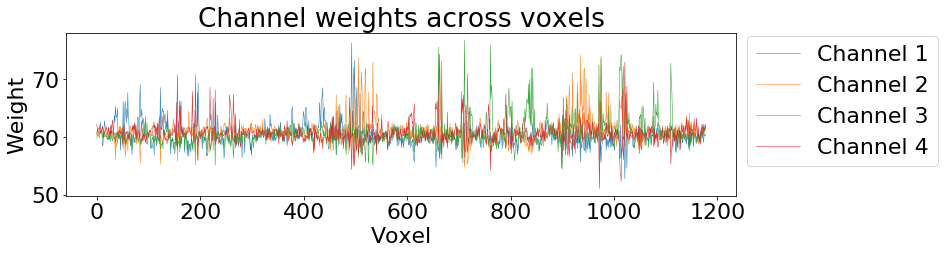

In [8]:
# Define training/testing trials
trn = trial_by_vox[np.isin(np.arange(ntrials),np.unique(train_vox_trial)),:]
trnf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(train_vox_trial))]
tst = trial_by_vox[np.isin(np.arange(ntrials),np.unique(test_vox_trial)),:]
tstf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(test_vox_trial))]
trn_or_tst = np.hstack((np.full( len(trn) , 0), np.full( len(tst) , 1)))

# trn = trial_by_vox[:ntrials//2,:] # training: trial "Betas"
# trnf = np.array(trial_features[:ntrials//2]) # training trial features
# tst = trial_by_vox[ntrials//2:,:] # testing: trial "Betas"
# tstf = np.array(trial_features[ntrials//2:]) # test trial features
# trn_or_tst = np.hstack((np.full( len(trn) , 0), np.full( len(tst) , 1)))

channelweights_per_vox = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trn, rcond=None)[0] 
# solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

for chan in range(nchannels):
    plt.plot(channelweights_per_vox[chan,:].T,linewidth=.5,label="Channel " + str(chan+1));
plt.title('Channel weights across voxels');
plt.xlabel("Voxel")
plt.ylabel("Weight")
plt.legend(bbox_to_anchor=(1, 1.05))

### Invert to compute channel responses

In [9]:
cr_trn = np.linalg.lstsq(channelweights_per_vox.T , trn.T, rcond=None)[0].T
cr_tst = np.linalg.lstsq(channelweights_per_vox.T , tst.T, rcond=None)[0].T


#### Reconstruct training data (note: this is circular, it should be near-perfect!)

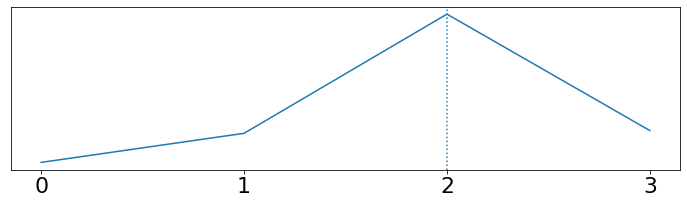

MAE: 43.766666666666666


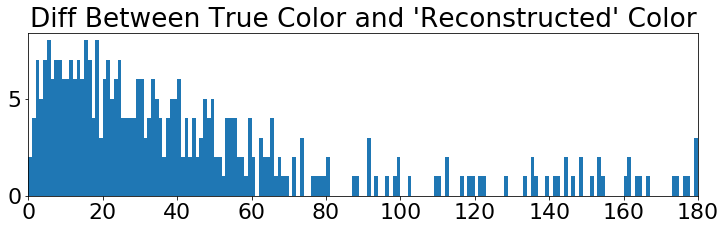

In [10]:
cr_center_trn = np.empty_like(cr_trn[:,:])
estimated_color = np.full(cr_center_trn.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_trn.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(trnf[trial],len(basis_points)), basis_points) ) )
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_trn[trial,:])]
    
plt.plot(np.mean(cr_center_trn,axis=0))
plt.axvline(shiftby,linestyle=":")
plt.ylabel('');plt.yticks([]);plt.xlabel('');plt.xticks(np.arange(nchannels))
# plt.savefig('img/trainrecon.eps', format='eps', dpi=300)
plt.show()

plt.hist(np.abs(wrap360(estimated_color, trnf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")

trn_mae = np.mean(np.abs(wrap360(estimated_color, trnf)))
print("MAE: {}".format(trn_mae))

MAE: 43.766666666666666
NEW MAE: 40.986111111111114
LK MAE: 38.34166666666667


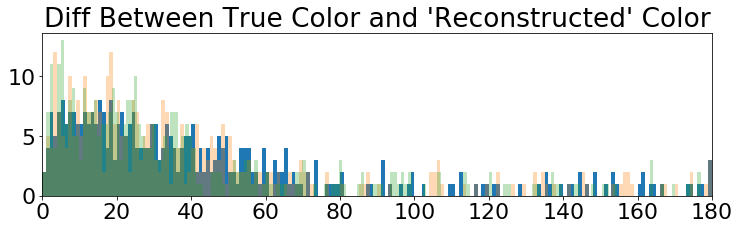

In [11]:
cr_center_trn = np.empty_like(cr_trn[:,:])
estimated_color = np.full(cr_center_trn.shape[0],np.nan)
estimated_color_new = np.full(cr_center_trn.shape[0],np.nan)
estimated_color_lk = np.full(cr_center_trn.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_trn.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(trnf[trial],len(basis_points)), basis_points) ) )
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - closest_basis );
    bs=make_vonmises_iter(np.linspace(0,359,360),
                        basis_points,
                        basis_sds,
                        cr_trn[trial,:])
    estimated_color_new[trial] = np.argmax(np.sum(bs,axis=1))
    estimated_color[trial] = basis_points[np.argmax(cr_trn[trial,:])]
    estimated_color_lk[trial] = np.argmax([np.corrcoef(cr_trn[trial,:],basis_set[f,:])[0][1] for f in range(360)])

plt.hist(np.abs(wrap360(estimated_color, trnf)), bins=180, label="")
trn_mae = np.mean(np.abs(wrap360(estimated_color, trnf)))
print("MAE: {}".format(trn_mae))

plt.hist(np.abs(wrap360(estimated_color_new, trnf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
trn_mae = np.mean(np.abs(wrap360(estimated_color_new, trnf)))
print("NEW MAE: {}".format(trn_mae))

plt.hist(np.abs(wrap360(estimated_color_lk, trnf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
trn_mae = np.mean(np.abs(wrap360(estimated_color_lk, trnf)))
print("LK MAE: {}".format(trn_mae))

#### Reconstruct test data

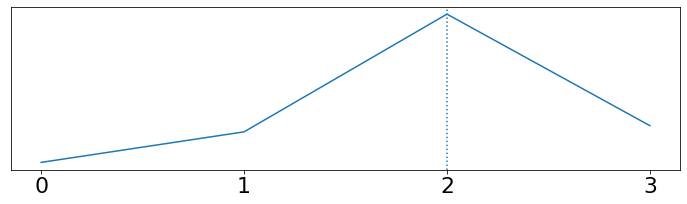

MAE: 45.12777777777778


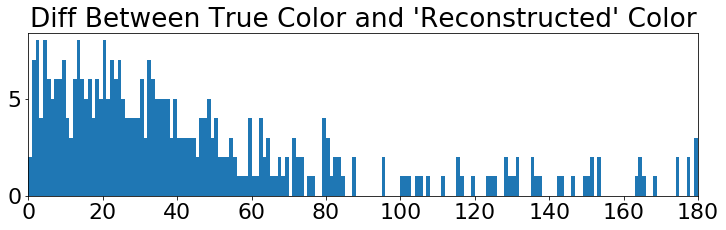

In [131]:
cr_center_tst = np.empty_like(cr_tst[:,:])
estimated_color = np.full(cr_center_tst.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_tst.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(tstf[trial],len(basis_points)), basis_points) ) )
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]
    
plt.plot(np.mean(cr_center_tst,axis=0))
plt.axvline(shiftby,linestyle=":")
plt.ylabel('');plt.yticks([]);plt.xlabel('');plt.xticks(np.arange(nchannels))
# plt.savefig('img/testrecon.eps', format='eps', dpi=300)
plt.show()

plt.hist(np.abs(wrap360(estimated_color, tstf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")

tst_mae = np.mean(np.abs(wrap360(estimated_color, tstf)))
print("MAE: {}".format(tst_mae))

MAE: 45.12777777777778
NEW MAE: 42.28611111111111
LK MAE: 39.53055555555556


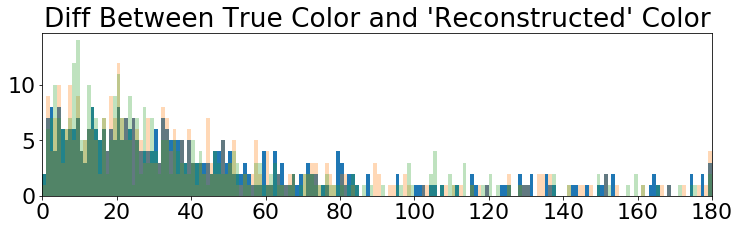

In [132]:
cr_center_tst = np.empty_like(cr_tst[:,:])
estimated_color = np.full(cr_center_tst.shape[0],np.nan)
estimated_color_new = np.full(cr_center_tst.shape[0],np.nan)
estimated_color_lk = np.full(cr_center_tst.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_tst.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(tstf[trial],len(basis_points)), basis_points) ) )
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - closest_basis );
    bs=make_vonmises_iter(np.linspace(0,359,360),
                        basis_points,
                        basis_sds,
                        cr_tst[trial,:])
    estimated_color_new[trial] = np.argmax(np.sum(bs,axis=1))
    estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]
    estimated_color_lk[trial] = np.argmax([np.corrcoef(cr_tst[trial,:],basis_set[f,:])[0][1] for f in range(360)])

plt.hist(np.abs(wrap360(estimated_color, tstf)), bins=180, label="")
tst_mae = np.mean(np.abs(wrap360(estimated_color, tstf)))
print("MAE: {}".format(tst_mae))

plt.hist(np.abs(wrap360(estimated_color_new, tstf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
tst_mae = np.mean(np.abs(wrap360(estimated_color_new, tstf)))
print("NEW MAE: {}".format(tst_mae))

plt.hist(np.abs(wrap360(estimated_color_lk, tstf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
tst_mae = np.mean(np.abs(wrap360(estimated_color_lk, tstf)))
print("LK MAE: {}".format(tst_mae))

#### Null Distribution / Significance Test

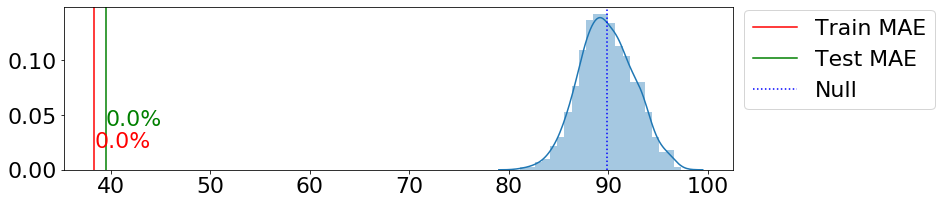

Model performance: 50.296505555555555


In [133]:
# Reconstruct the stimulus:
estimated_color = np.full(cr_tst.shape[0],np.nan)
null_mae = np.full(1000,np.nan)
for perm in np.arange(1000):
    shuffled_tst = np.random.permutation(tst)
    cr_shuffle_tst = np.linalg.lstsq(channelweights_per_vox.T , shuffled_tst.T, rcond=None)[0].T
    for trial in np.arange(cr_shuffle_tst.shape[0]):
        estimated_color[trial] = basis_points[np.argmax(cr_shuffle_tst[trial,:])]

    null_mae[perm] = np.mean(np.abs(wrap360(estimated_color, tstf)))

trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae) * 100
tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae) * 100

sns.distplot(null_mae)
plt.axvline(trn_mae,color='red',label="Train MAE")
plt.axvline(tst_mae,color='green',label="Test MAE")
plt.axvline(np.mean(null_mae),linestyle=':',color='blue',label="Null")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.text(trn_mae,.02,"{:.1f}%".format(trn_overlap),color='red')
plt.text(tst_mae,.04,"{:.1f}%".format(tst_overlap),color='green')
plt.show()

print("Model performance: {}".format(np.mean(null_mae - tst_mae)/1))

## Informed Basis (shared precision)

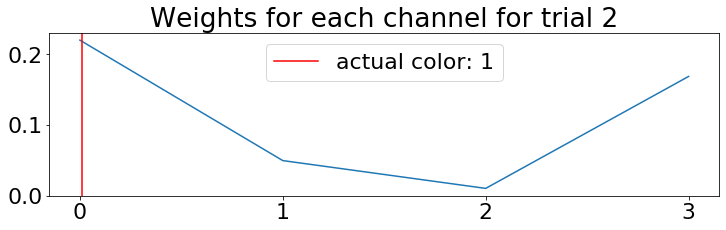

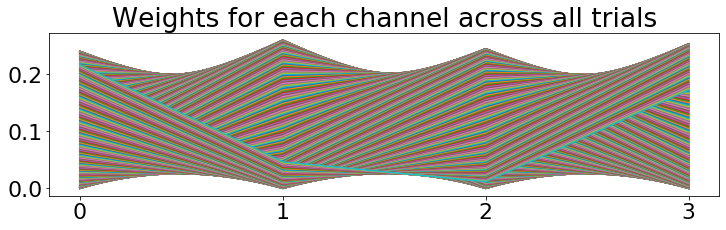

In [140]:
trial_weights = basis_set[trial_features,:]

trial = 1
plt.plot(trial_weights[trial,:])
plt.title("Weights for each channel for trial {}".format(trial+1))
#np.where(basis_points==trial_features[trial])[0][0]
plt.axvline(trial_features[trial]/360 * nchannels,color='red',label="actual color: {}".format(trial_features[trial]))
plt.xticks(np.arange(nchannels))
plt.legend()
plt.show()

for trial in np.arange(ntrials):
    plt.plot(trial_weights[trial,:])
plt.xticks(np.arange(nchannels))
plt.title('Weights for each channel across all trials')
plt.show()

### Test if channels are linearly dependent
Test to see if we have a full rank design matrix (tests if channels are linearly dependent). Linearly dependent channels are bad because it means that at least one of the channels can be defined as a linear combination of the others. This is bad because then we can't uniquely estimate the contribution of each channel to the signal observed in a given voxel. In other words, if trail_weights is not full rank then we have effectively lost the contribution of at least one of the nchannel dimensions.

In [141]:
print('Design matrix: rank = {}'.format( np.linalg.matrix_rank(trial_weights) ))
if np.linalg.matrix_rank(trial_weights) != nchannels:
    raise Exception('trial_weights not full rank')

Design matrix: rank = 4


### Compute weights of forward model

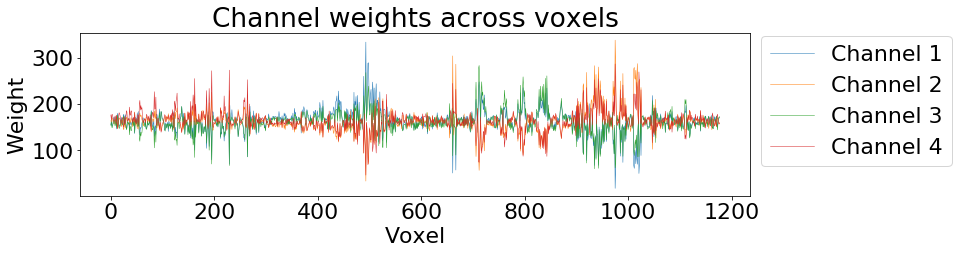

In [142]:
# Define training/testing trials
trn = trial_by_vox[np.isin(np.arange(ntrials),np.unique(train_vox_trial)),:]
trnf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(train_vox_trial))]
tst = trial_by_vox[np.isin(np.arange(ntrials),np.unique(test_vox_trial)),:]
tstf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(test_vox_trial))]
trn_or_tst = np.hstack((np.full( len(trn) , 0), np.full( len(tst) , 1)))

# trn = trial_by_vox[:ntrials//2,:] # training: trial "Betas"
# trnf = np.array(trial_features[:ntrials//2]) # training trial features
# tst = trial_by_vox[ntrials//2:,:] # testing: trial "Betas"
# tstf = np.array(trial_features[ntrials//2:]) # test trial features
# trn_or_tst = np.hstack((np.full( len(trn) , 0), np.full( len(tst) , 1)))

channelweights_per_vox = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trn, rcond=None)[0] 
# solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

for chan in range(nchannels):
    plt.plot(channelweights_per_vox[chan,:].T,linewidth=.5,label="Channel " + str(chan+1));
plt.title('Channel weights across voxels');
plt.xlabel("Voxel")
plt.ylabel("Weight")
plt.legend(bbox_to_anchor=(1, 1.05))

### Invert to compute channel responses

In [143]:
cr_trn = np.linalg.lstsq(channelweights_per_vox.T , trn.T, rcond=None)[0].T
cr_tst = np.linalg.lstsq(channelweights_per_vox.T , tst.T, rcond=None)[0].T


#### Reconstruct training data (note: this is circular, it should be near-perfect!)

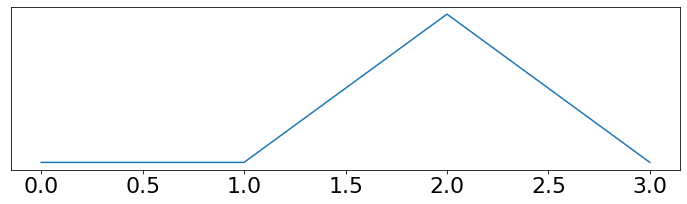

In [144]:
temp=np.zeros(nchannels)
temp[2]=1
plt.plot(temp)
plt.ylabel('');plt.yticks([]);plt.xlabel('')
plt.savefig('img/idealrecon.eps', format='eps', dpi=300)

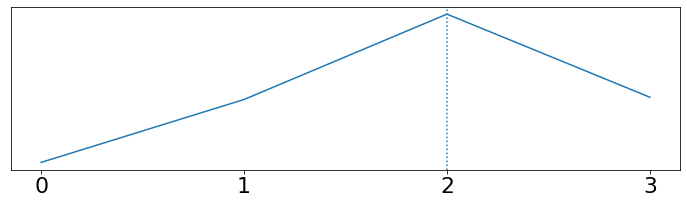

MAE: 43.86858174131137


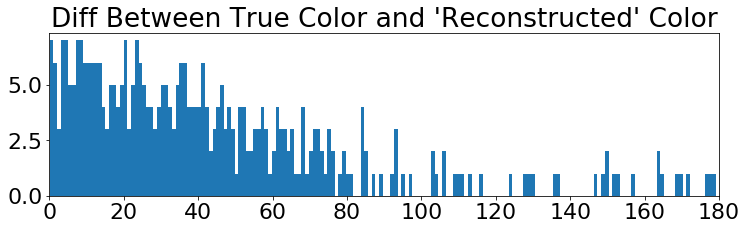

In [145]:
cr_center_trn = np.empty_like(cr_trn[:,:])
estimated_color = np.full(cr_center_trn.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_trn.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(trnf[trial],len(basis_points)), basis_points) ) )
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_trn[trial,:])]
    
plt.plot(np.mean(cr_center_trn,axis=0))
plt.axvline(shiftby,linestyle=":")
plt.ylabel('');plt.yticks([]);plt.xlabel('');plt.xticks(np.arange(nchannels))
# plt.savefig('img/trainrecon.eps', format='eps', dpi=300)
plt.show()

plt.hist(np.abs(wrap360(estimated_color, trnf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")

trn_mae = np.mean(np.abs(wrap360(estimated_color, trnf)))
print("MAE: {}".format(trn_mae))

MAE: 43.86858174131137
NEW MAE: 39.59722222222222
LK MAE: 39.63611111111111


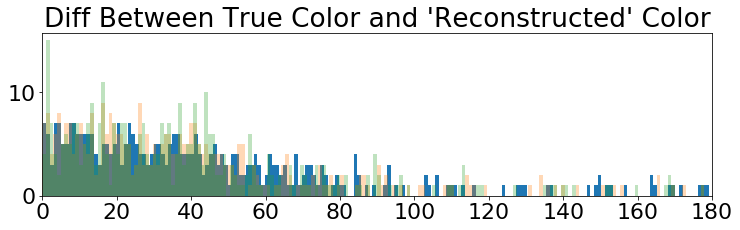

In [146]:
cr_center_trn = np.empty_like(cr_trn[:,:])
estimated_color = np.full(cr_center_trn.shape[0],np.nan)
estimated_color_new = np.full(cr_center_trn.shape[0],np.nan)
estimated_color_lk = np.full(cr_center_trn.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_trn.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(trnf[trial],len(basis_points)), basis_points) ) )
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - closest_basis );
    bs=make_vonmises_iter(np.linspace(0,359,360),
                        basis_points,
                        basis_sds,
                        cr_trn[trial,:])
    estimated_color_new[trial] = np.argmax(np.sum(bs,axis=1))
    estimated_color[trial] = basis_points[np.argmax(cr_trn[trial,:])]
    estimated_color_lk[trial] = np.argmax([np.corrcoef(cr_trn[trial,:],basis_set[f,:])[0][1] for f in range(360)])

plt.hist(np.abs(wrap360(estimated_color, trnf)), bins=180, label="")
trn_mae = np.mean(np.abs(wrap360(estimated_color, trnf)))
print("MAE: {}".format(trn_mae))

plt.hist(np.abs(wrap360(estimated_color_new, trnf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
trn_mae = np.mean(np.abs(wrap360(estimated_color_new, trnf)))
print("NEW MAE: {}".format(trn_mae))

plt.hist(np.abs(wrap360(estimated_color_lk, trnf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
trn_mae = np.mean(np.abs(wrap360(estimated_color_lk, trnf)))
print("LK MAE: {}".format(trn_mae))

#### Reconstruct test data

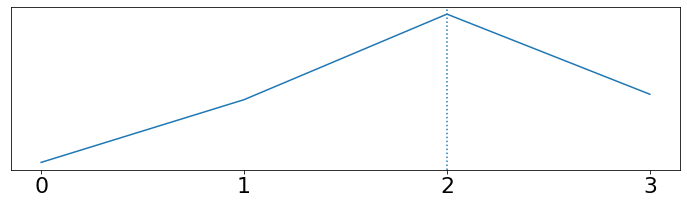

MAE: 44.92371566318415


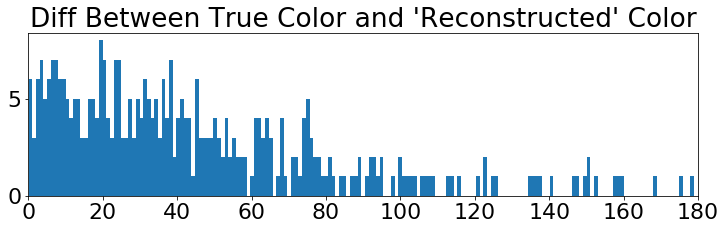

In [147]:
cr_center_tst = np.empty_like(cr_tst[:,:])
estimated_color = np.full(cr_center_tst.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_tst.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(tstf[trial],len(basis_points)), basis_points) ) )
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]
    
plt.plot(np.mean(cr_center_tst,axis=0))
plt.axvline(shiftby,linestyle=":")
plt.ylabel('');plt.yticks([]);plt.xlabel('');plt.xticks(np.arange(nchannels))
# plt.savefig('img/testrecon.eps', format='eps', dpi=300)
plt.show()

plt.hist(np.abs(wrap360(estimated_color, tstf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")

tst_mae = np.mean(np.abs(wrap360(estimated_color, tstf)))
print("MAE: {}".format(tst_mae))

MAE: 44.92371566318415
NEW MAE: 40.58888888888889
LK MAE: 40.522222222222226


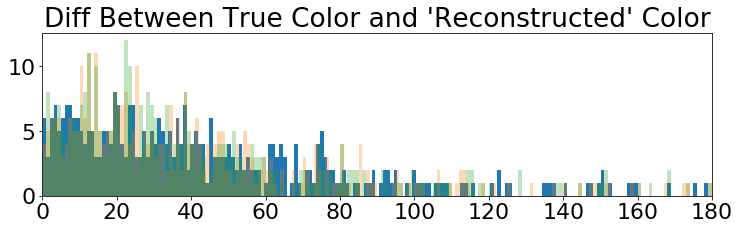

In [148]:
cr_center_tst = np.empty_like(cr_tst[:,:])
estimated_color = np.full(cr_center_tst.shape[0],np.nan)
estimated_color_new = np.full(cr_center_tst.shape[0],np.nan)
estimated_color_lk = np.full(cr_center_tst.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_tst.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(tstf[trial],len(basis_points)), basis_points) ) )
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - closest_basis );
    bs=make_vonmises_iter(np.linspace(0,359,360),
                        basis_points,
                        basis_sds,
                        cr_tst[trial,:])
    estimated_color_new[trial] = np.argmax(np.sum(bs,axis=1))
    estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]
    estimated_color_lk[trial] = np.argmax([np.corrcoef(cr_tst[trial,:],basis_set[f,:])[0][1] for f in range(360)])

plt.hist(np.abs(wrap360(estimated_color, tstf)), bins=180, label="")
tst_mae = np.mean(np.abs(wrap360(estimated_color, tstf)))
print("MAE: {}".format(tst_mae))

plt.hist(np.abs(wrap360(estimated_color_new, tstf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
tst_mae = np.mean(np.abs(wrap360(estimated_color_new, tstf)))
print("NEW MAE: {}".format(tst_mae))

plt.hist(np.abs(wrap360(estimated_color_lk, tstf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
tst_mae = np.mean(np.abs(wrap360(estimated_color_lk, tstf)))
print("LK MAE: {}".format(tst_mae))

#### Null Distribution / Significance Test

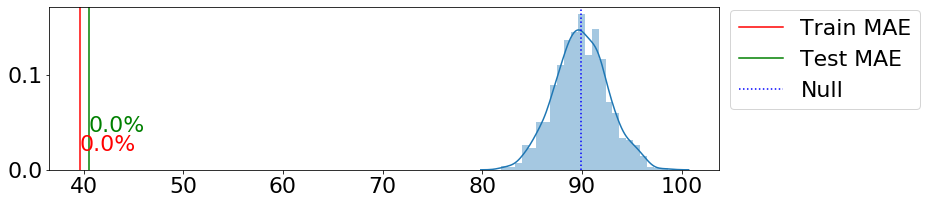

Model performance: 49.405792855569175


In [149]:
# Reconstruct the stimulus:
estimated_color = np.full(cr_tst.shape[0],np.nan)
null_mae = np.full(1000,np.nan)
for perm in np.arange(1000):
    shuffled_tst = np.random.permutation(tst)
    cr_shuffle_tst = np.linalg.lstsq(channelweights_per_vox.T , shuffled_tst.T, rcond=None)[0].T
    for trial in np.arange(cr_shuffle_tst.shape[0]):
        estimated_color[trial] = basis_points[np.argmax(cr_shuffle_tst[trial,:])]

    null_mae[perm] = np.mean(np.abs(wrap360(estimated_color, tstf)))

trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae) * 100
tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae) * 100

sns.distplot(null_mae)
plt.axvline(trn_mae,color='red',label="Train MAE")
plt.axvline(tst_mae,color='green',label="Test MAE")
plt.axvline(np.mean(null_mae),linestyle=':',color='blue',label="Null")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.text(trn_mae,.02,"{:.1f}%".format(trn_overlap),color='red')
plt.text(tst_mae,.04,"{:.1f}%".format(tst_overlap),color='green')
plt.show()

print("Model performance: {}".format(np.mean(null_mae - tst_mae)/1))

## Informed Basis (indiv precision)

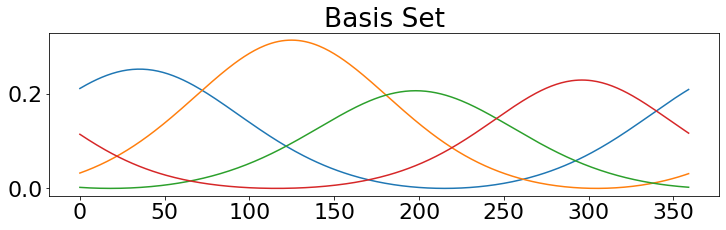

In [647]:
nchannels=4
# Plot chosen basis set

basis_set = make_vonmises_iter(np.linspace(0,359,360),
         [circmean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)],
#          np.mean(posterior['sd_deg'])*np.ones(nchannels),
         [np.mean(posterior['sd_deg_{}'.format(chan)]) for chan in range(nchannels)],
         sumfix([np.mean(posterior['p'][:,chan]) for chan in range(nchannels)]))
basis_points = [circmean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
# basis_sds = np.mean(posterior['sd_deg'])*np.ones(nchannels)
basis_sds = [np.mean(posterior['sd_deg_{}'.format(chan)]) for chan in range(nchannels)]

# if np.any(np.round(np.sum(basis_set,axis=1),3)!=1):
#     raise Exception("Not every feature sums weights to 1")

plt.plot(basis_set[:,:])
plt.title('Basis Set') 
# plt.ylabel('');plt.yticks([]);plt.xlabel('')
# plt.ylim([basis_set[0,-1],np.max(basis_set)])
# plt.savefig('prior.eps', format='eps', dpi=300)
plt.show()

# # Plot actual voxel tunings:
# for vox in np.arange(nvoxels):
#     if vox <= 25:
#         plt.scatter(trial_features,trial_by_vox[:,vox])
# plt.xlabel('Color')
# plt.ylabel('Response')
# plt.yticks([0,np.max(trial_by_vox[:,vox])//2,np.max(trial_by_vox[:,vox])], [0,1])
# plt.title('First 25 Voxel Responses')
# plt.show()

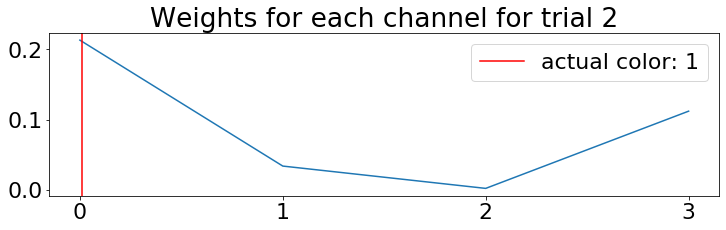

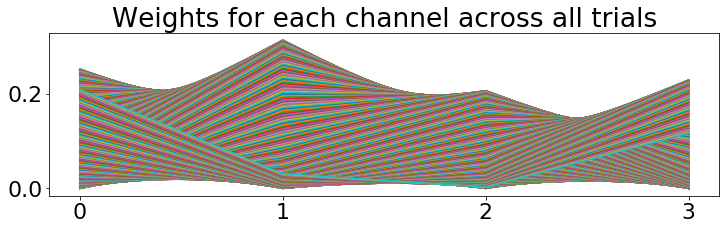

In [648]:
trial_weights = basis_set[trial_features,:]

trial = 1
plt.plot(trial_weights[trial,:])
plt.title("Weights for each channel for trial {}".format(trial+1))
#np.where(basis_points==trial_features[trial])[0][0]
plt.axvline(trial_features[trial]/360 * nchannels,color='red',label="actual color: {}".format(trial_features[trial]))
plt.xticks(np.arange(nchannels))
plt.legend()
plt.show()

for trial in np.arange(ntrials):
    plt.plot(trial_weights[trial,:])
plt.xticks(np.arange(nchannels))
plt.title('Weights for each channel across all trials')
plt.show()

### Test if channels are linearly dependent
Test to see if we have a full rank design matrix (tests if channels are linearly dependent). Linearly dependent channels are bad because it means that at least one of the channels can be defined as a linear combination of the others. This is bad because then we can't uniquely estimate the contribution of each channel to the signal observed in a given voxel. In other words, if trail_weights is not full rank then we have effectively lost the contribution of at least one of the nchannel dimensions.

In [158]:
print('Design matrix: rank = {}'.format( np.linalg.matrix_rank(trial_weights) ))
if np.linalg.matrix_rank(trial_weights) != nchannels:
    raise Exception('trial_weights not full rank')

Design matrix: rank = 4


### Compute weights of forward model

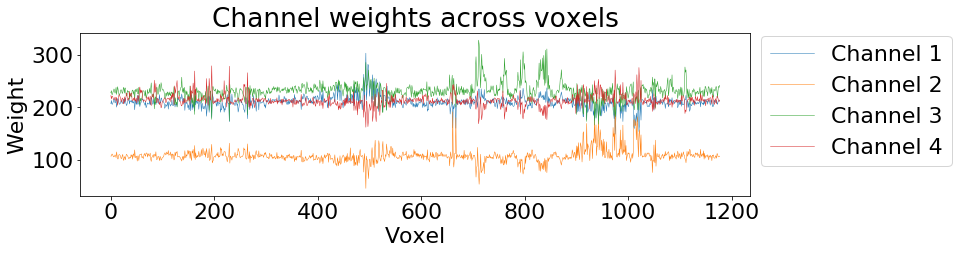

In [649]:
# Define training/testing trials
trn = trial_by_vox[np.isin(np.arange(ntrials),np.unique(train_vox_trial)),:]
trnf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(train_vox_trial))]
tst = trial_by_vox[np.isin(np.arange(ntrials),np.unique(test_vox_trial)),:]
tstf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(test_vox_trial))]
trn_or_tst = np.hstack((np.full( len(trn) , 0), np.full( len(tst) , 1)))

# trn = trial_by_vox[:ntrials//2,:] # training: trial "Betas"
# trnf = np.array(trial_features[:ntrials//2]) # training trial features
# tst = trial_by_vox[ntrials//2:,:] # testing: trial "Betas"
# tstf = np.array(trial_features[ntrials//2:]) # test trial features
# trn_or_tst = np.hstack((np.full( len(trn) , 0), np.full( len(tst) , 1)))

channelweights_per_vox = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trn, rcond=None)[0] 
# solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

for chan in range(nchannels):
    plt.plot(channelweights_per_vox[chan,:].T,linewidth=.5,label="Channel " + str(chan+1));
plt.title('Channel weights across voxels');
plt.xlabel("Voxel")
plt.ylabel("Weight")
plt.legend(bbox_to_anchor=(1, 1.05))

### Invert to compute channel responses

In [650]:
cr_trn = np.linalg.lstsq(channelweights_per_vox.T , trn.T, rcond=None)[0].T
cr_tst = np.linalg.lstsq(channelweights_per_vox.T , tst.T, rcond=None)[0].T


#### Reconstruct training data (note: this is circular, it should be near-perfect!)

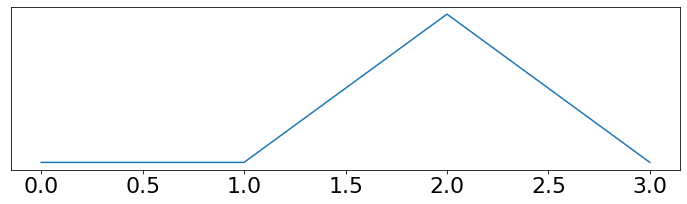

In [651]:
temp=np.zeros(nchannels)
temp[2]=1
plt.plot(temp)
plt.ylabel('');plt.yticks([]);plt.xlabel('')
plt.savefig('img/idealrecon.eps', format='eps', dpi=300)

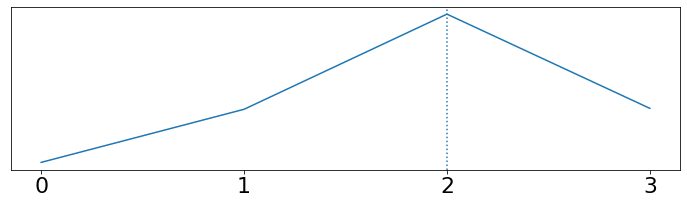

MAE: 44.14241038888889


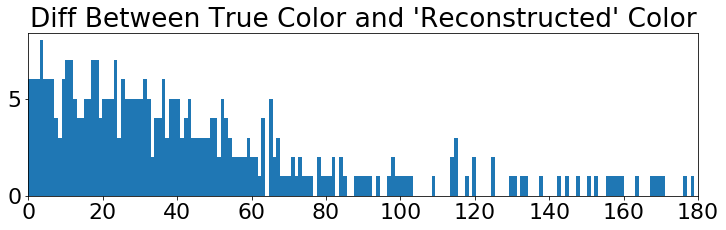

In [652]:
cr_center_trn = np.empty_like(cr_trn[:,:])
estimated_color = np.full(cr_center_trn.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_trn.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(trnf[trial],len(basis_points)), basis_points) ) )
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_trn[trial,:])]
    
plt.plot(np.mean(cr_center_trn,axis=0))
plt.axvline(shiftby,linestyle=":")
plt.ylabel('');plt.yticks([]);plt.xlabel('');plt.xticks(np.arange(nchannels))
# plt.savefig('img/trainrecon.eps', format='eps', dpi=300)
plt.show()

plt.hist(np.abs(wrap360(estimated_color, trnf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")

trn_mae = np.mean(np.abs(wrap360(estimated_color, trnf)))
print("MAE: {}".format(trn_mae))

MAE: 44.14241038888889
NEW MAE: 40.513888888888886
LK MAE: 38.983333333333334


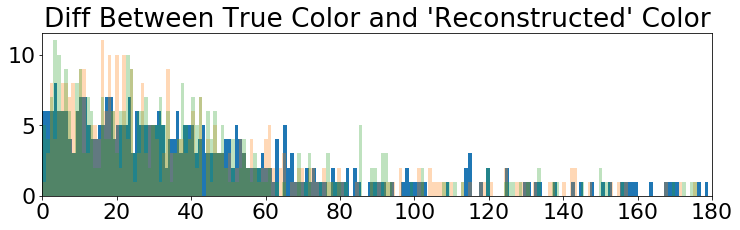

In [653]:
cr_center_trn = np.empty_like(cr_trn[:,:])
estimated_color = np.full(cr_center_trn.shape[0],np.nan)
estimated_color_new = np.full(cr_center_trn.shape[0],np.nan)
estimated_color_lk = np.full(cr_center_trn.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_trn.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(trnf[trial],len(basis_points)), basis_points) ) )
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - closest_basis );
    bs=make_vonmises_iter(np.linspace(0,359,360),
                        basis_points,
                        basis_sds,
                        cr_trn[trial,:])
    estimated_color_new[trial] = np.argmax(np.sum(bs,axis=1))
    estimated_color[trial] = basis_points[np.argmax(cr_trn[trial,:])]
    estimated_color_lk[trial] = np.argmax([np.corrcoef(cr_trn[trial,:],basis_set[f,:])[0][1] for f in range(360)])

plt.hist(np.abs(wrap360(estimated_color, trnf)), bins=180, label="")
trn_mae = np.mean(np.abs(wrap360(estimated_color, trnf)))
print("MAE: {}".format(trn_mae))

plt.hist(np.abs(wrap360(estimated_color_new, trnf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
trn_mae = np.mean(np.abs(wrap360(estimated_color_new, trnf)))
print("NEW MAE: {}".format(trn_mae))

plt.hist(np.abs(wrap360(estimated_color_lk, trnf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
trn_mae = np.mean(np.abs(wrap360(estimated_color_lk, trnf)))
print("LK MAE: {}".format(trn_mae))

#### Reconstruct test data

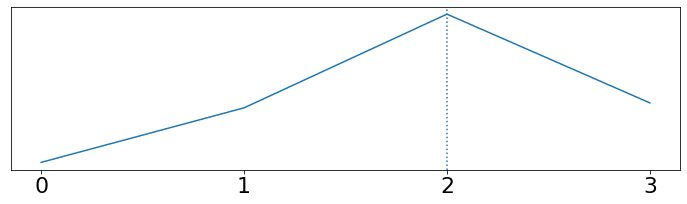

MAE: 44.069086363888886


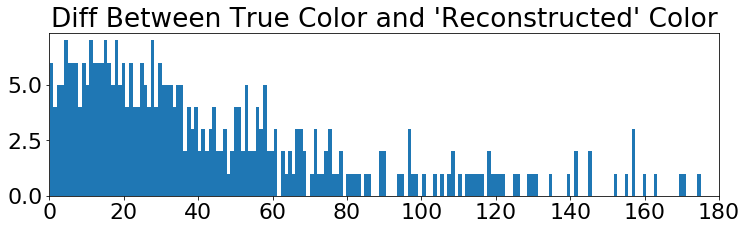

In [654]:
cr_center_tst = np.empty_like(cr_tst[:,:])
estimated_color = np.full(cr_center_tst.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_tst.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(tstf[trial],len(basis_points)), basis_points) ) )
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]
    
plt.plot(np.mean(cr_center_tst,axis=0))
plt.axvline(shiftby,linestyle=":")
plt.ylabel('');plt.yticks([]);plt.xlabel('');plt.xticks(np.arange(nchannels))
# plt.savefig('img/testrecon.eps', format='eps', dpi=300)
plt.show()

plt.hist(np.abs(wrap360(estimated_color, tstf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")

tst_mae = np.mean(np.abs(wrap360(estimated_color, tstf)))
print("MAE: {}".format(tst_mae))

MAE: 44.069086363888886
NEW MAE: 40.49444444444445
LK MAE: 39.516666666666666


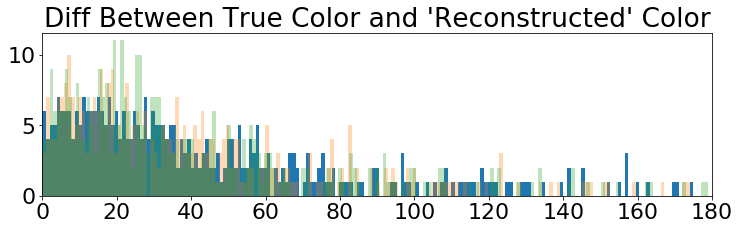

In [655]:
cr_center_tst = np.empty_like(cr_tst[:,:])
estimated_color = np.full(cr_center_tst.shape[0],np.nan)
estimated_color_new = np.full(cr_center_tst.shape[0],np.nan)
estimated_color_lk = np.full(cr_center_tst.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_tst.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(tstf[trial],len(basis_points)), basis_points) ) )
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - closest_basis );
    bs=make_vonmises_iter(np.linspace(0,359,360),
                        basis_points,
                        basis_sds,
                        cr_tst[trial,:])
    estimated_color_new[trial] = np.argmax(np.sum(bs,axis=1))
    estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]
    estimated_color_lk[trial] = np.argmax([np.corrcoef(cr_tst[trial,:],basis_set[f,:])[0][1] for f in range(360)])

plt.hist(np.abs(wrap360(estimated_color, tstf)), bins=180, label="")
tst_mae = np.mean(np.abs(wrap360(estimated_color, tstf)))
print("MAE: {}".format(tst_mae))

plt.hist(np.abs(wrap360(estimated_color_new, tstf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
tst_mae = np.mean(np.abs(wrap360(estimated_color_new, tstf)))
print("NEW MAE: {}".format(tst_mae))

plt.hist(np.abs(wrap360(estimated_color_lk, tstf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
tst_mae = np.mean(np.abs(wrap360(estimated_color_lk, tstf)))
print("LK MAE: {}".format(tst_mae))

#### Null Distribution / Significance Test

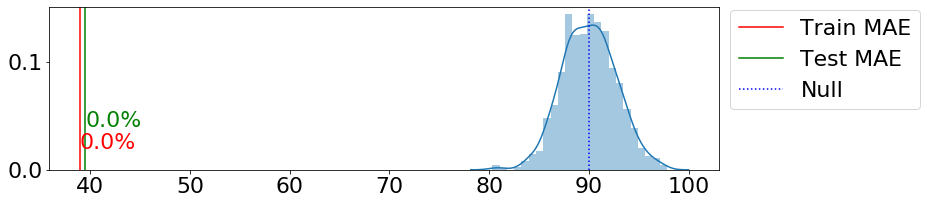

Model performance: 50.494394234283334


In [656]:
# Reconstruct the stimulus:
estimated_color = np.full(cr_tst.shape[0],np.nan)
null_mae = np.full(1000,np.nan)
for perm in np.arange(1000):
    shuffled_tst = np.random.permutation(tst)
    cr_shuffle_tst = np.linalg.lstsq(channelweights_per_vox.T , shuffled_tst.T, rcond=None)[0].T
    for trial in np.arange(cr_shuffle_tst.shape[0]):
        estimated_color[trial] = basis_points[np.argmax(cr_shuffle_tst[trial,:])]

    null_mae[perm] = np.mean(np.abs(wrap360(estimated_color, tstf)))

trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae) * 100
tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae) * 100

sns.distplot(null_mae)
plt.axvline(trn_mae,color='red',label="Train MAE")
plt.axvline(tst_mae,color='green',label="Test MAE")
plt.axvline(np.mean(null_mae),linestyle=':',color='blue',label="Null")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.text(trn_mae,.02,"{:.1f}%".format(trn_overlap),color='red')
plt.text(tst_mae,.04,"{:.1f}%".format(tst_overlap),color='green')
plt.show()

print("Model performance: {}".format(np.mean(null_mae - tst_mae)/1))

# Two ROI model

## Standard Basis

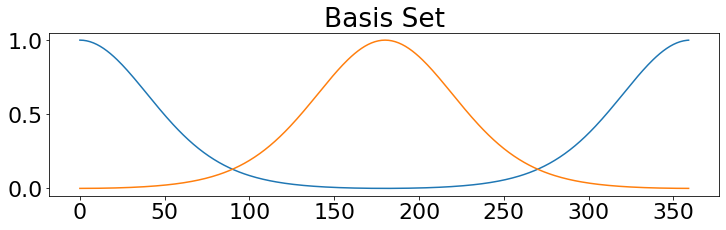

In [213]:
nchannels=2
# Plot chosen basis set

basis_set = make_vonmises_iter(np.linspace(0,359,360),
                    np.linspace(0,360-(360/nchannels),nchannels),
                    60*np.ones(nchannels),
                    np.ones(nchannels))
basis_sds = 60*np.ones(nchannels)
basis_points = np.linspace(0,360-(360/nchannels),nchannels)

plt.plot(basis_set[:,:])
plt.title('Basis Set') 
# plt.ylabel('');plt.yticks([]);plt.xlabel('')
# plt.ylim([basis_set[0,-1],np.max(basis_set)])
# plt.savefig('prior.eps', format='eps', dpi=300)
plt.show()

# # Plot actual voxel tunings:
# for vox in np.arange(nvoxels):
#     if vox <= 25:
#         plt.scatter(trial_features,trial_by_vox[:,vox])
# plt.xlabel('Color')
# plt.ylabel('Response')
# plt.yticks([0,np.max(trial_by_vox[:,vox])//2,np.max(trial_by_vox[:,vox])], [0,1])
# plt.title('First 25 Voxel Responses')
# plt.show()

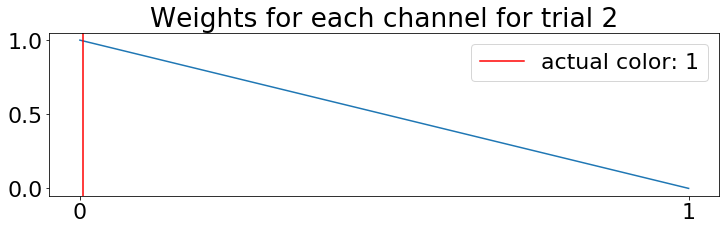

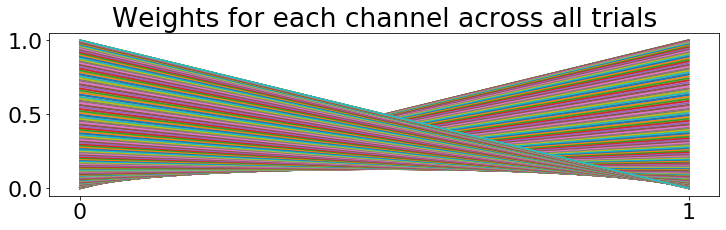

In [214]:
trial_weights = basis_set[trial_features,:]

trial = 1
plt.plot(trial_weights[trial,:])
plt.title("Weights for each channel for trial {}".format(trial+1))
#np.where(basis_points==trial_features[trial])[0][0]
plt.axvline(trial_features[trial]/360 * nchannels,color='red',label="actual color: {}".format(trial_features[trial]))
plt.xticks(np.arange(nchannels))
plt.legend()
plt.show()

for trial in np.arange(ntrials):
    plt.plot(trial_weights[trial,:])
plt.xticks(np.arange(nchannels))
plt.title('Weights for each channel across all trials')
plt.show()

### Test if channels are linearly dependent
Test to see if we have a full rank design matrix (tests if channels are linearly dependent). Linearly dependent channels are bad because it means that at least one of the channels can be defined as a linear combination of the others. This is bad because then we can't uniquely estimate the contribution of each channel to the signal observed in a given voxel. In other words, if trail_weights is not full rank then we have effectively lost the contribution of at least one of the nchannel dimensions.

In [215]:
print('Design matrix: rank = {}'.format( np.linalg.matrix_rank(trial_weights) ))
if np.linalg.matrix_rank(trial_weights) != nchannels:
    raise Exception('trial_weights not full rank')

Design matrix: rank = 2


### Compute weights of forward model

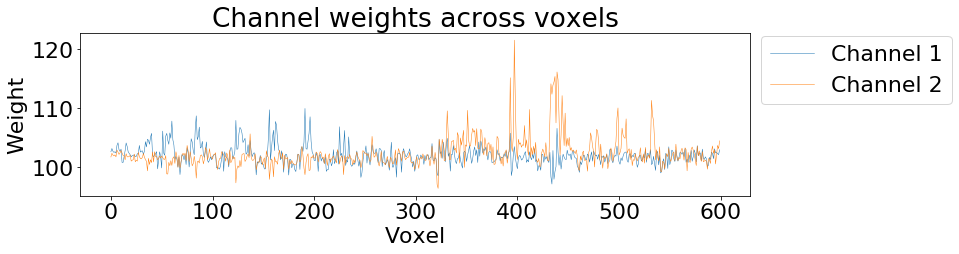

In [216]:
# Define training/testing trials
trn = trial_by_vox[np.isin(np.arange(ntrials),np.unique(train_vox_trial)),:]
trnf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(train_vox_trial))]
tst = trial_by_vox[np.isin(np.arange(ntrials),np.unique(test_vox_trial)),:]
tstf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(test_vox_trial))]
trn_or_tst = np.hstack((np.full( len(trn) , 0), np.full( len(tst) , 1)))

# trn = trial_by_vox[:ntrials//2,:] # training: trial "Betas"
# trnf = np.array(trial_features[:ntrials//2]) # training trial features
# tst = trial_by_vox[ntrials//2:,:] # testing: trial "Betas"
# tstf = np.array(trial_features[ntrials//2:]) # test trial features
# trn_or_tst = np.hstack((np.full( len(trn) , 0), np.full( len(tst) , 1)))

channelweights_per_vox = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trn, rcond=None)[0] 
# solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

for chan in range(nchannels):
    plt.plot(channelweights_per_vox[chan,:].T,linewidth=.5,label="Channel " + str(chan+1));
plt.title('Channel weights across voxels');
plt.xlabel("Voxel")
plt.ylabel("Weight")
plt.legend(bbox_to_anchor=(1, 1.05))

### Invert to compute channel responses

In [217]:
cr_trn = np.linalg.lstsq(channelweights_per_vox.T , trn.T, rcond=None)[0].T
cr_tst = np.linalg.lstsq(channelweights_per_vox.T , tst.T, rcond=None)[0].T


#### Reconstruct training data (note: this is circular, it should be near-perfect!)

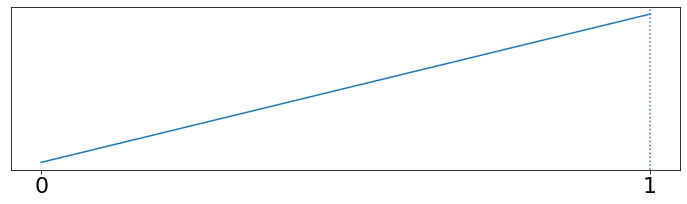

MAE: 65.6


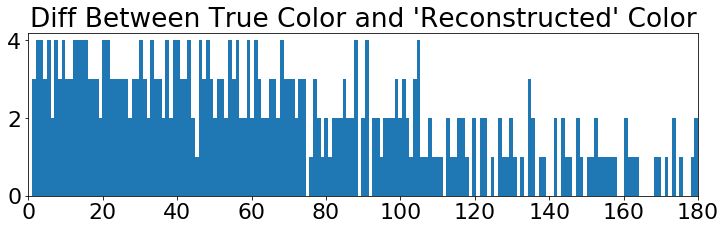

In [218]:
cr_center_trn = np.empty_like(cr_trn[:,:])
estimated_color = np.full(cr_center_trn.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_trn.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(trnf[trial],len(basis_points)), basis_points) ) )
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_trn[trial,:])]
    
plt.plot(np.mean(cr_center_trn,axis=0))
plt.axvline(shiftby,linestyle=":")
plt.ylabel('');plt.yticks([]);plt.xlabel('');plt.xticks(np.arange(nchannels))
# plt.savefig('img/trainrecon.eps', format='eps', dpi=300)
plt.show()

plt.hist(np.abs(wrap360(estimated_color, trnf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")

trn_mae = np.mean(np.abs(wrap360(estimated_color, trnf)))
print("MAE: {}".format(trn_mae))

MAE: 65.6
NEW MAE: 65.6
LK MAE: 90.0


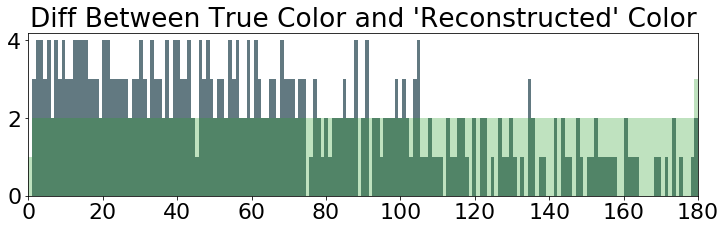

In [219]:
cr_center_trn = np.empty_like(cr_trn[:,:])
estimated_color = np.full(cr_center_trn.shape[0],np.nan)
estimated_color_new = np.full(cr_center_trn.shape[0],np.nan)
estimated_color_lk = np.full(cr_center_trn.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_trn.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(trnf[trial],len(basis_points)), basis_points) ) )
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - closest_basis );
    bs=make_vonmises_iter(np.linspace(0,359,360),
                        basis_points,
                        basis_sds,
                        cr_trn[trial,:])
    estimated_color_new[trial] = np.argmax(np.sum(bs,axis=1))
    estimated_color[trial] = basis_points[np.argmax(cr_trn[trial,:])]
    estimated_color_lk[trial] = np.argmax([np.corrcoef(cr_trn[trial,:],basis_set[f,:])[0][1] for f in range(360)])

plt.hist(np.abs(wrap360(estimated_color, trnf)), bins=180, label="")
trn_mae = np.mean(np.abs(wrap360(estimated_color, trnf)))
print("MAE: {}".format(trn_mae))

plt.hist(np.abs(wrap360(estimated_color_new, trnf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
trn_mae = np.mean(np.abs(wrap360(estimated_color_new, trnf)))
print("NEW MAE: {}".format(trn_mae))

plt.hist(np.abs(wrap360(estimated_color_lk, trnf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
trn_mae = np.mean(np.abs(wrap360(estimated_color_lk, trnf)))
print("LK MAE: {}".format(trn_mae))

trn_mae = np.mean(np.abs(wrap360(estimated_color_new, trnf)))

#### Reconstruct test data

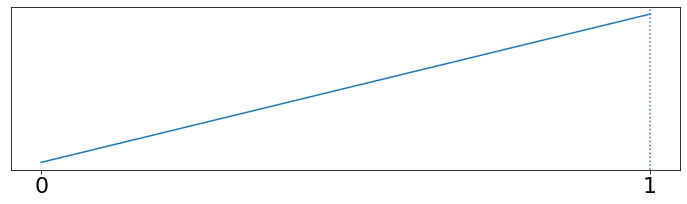

MAE: 66.69444444444444


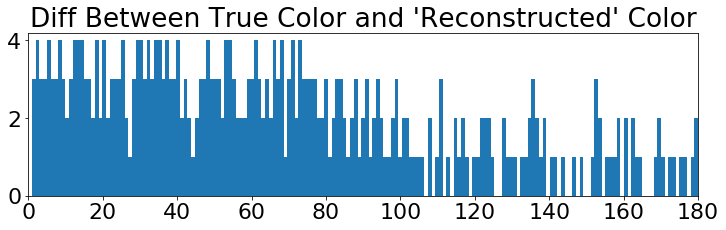

In [220]:
cr_center_tst = np.empty_like(cr_tst[:,:])
estimated_color = np.full(cr_center_tst.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_tst.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(tstf[trial],len(basis_points)), basis_points) ) )
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]
    
plt.plot(np.mean(cr_center_tst,axis=0))
plt.axvline(shiftby,linestyle=":")
plt.ylabel('');plt.yticks([]);plt.xlabel('');plt.xticks(np.arange(nchannels))
# plt.savefig('img/testrecon.eps', format='eps', dpi=300)
plt.show()

plt.hist(np.abs(wrap360(estimated_color, tstf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")

tst_mae = np.mean(np.abs(wrap360(estimated_color, tstf)))
print("MAE: {}".format(tst_mae))

MAE: 66.69444444444444
NEW MAE: 66.69444444444444
LK MAE: 90.0


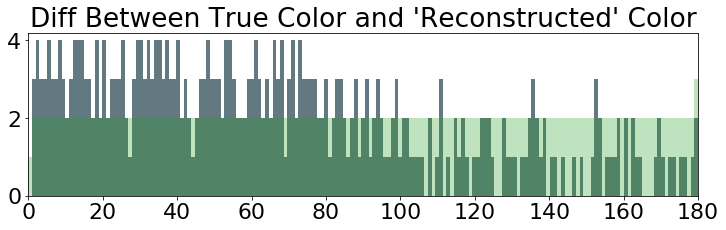

In [221]:
cr_center_tst = np.empty_like(cr_tst[:,:])
estimated_color = np.full(cr_center_tst.shape[0],np.nan)
estimated_color_new = np.full(cr_center_tst.shape[0],np.nan)
estimated_color_lk = np.full(cr_center_tst.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_tst.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(tstf[trial],len(basis_points)), basis_points) ) )
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - closest_basis );
    bs=make_vonmises_iter(np.linspace(0,359,360),
                        basis_points,
                        basis_sds,
                        cr_tst[trial,:])
    estimated_color_new[trial] = np.argmax(np.sum(bs,axis=1))
    estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]
    estimated_color_lk[trial] = np.argmax([np.corrcoef(cr_tst[trial,:],basis_set[f,:])[0][1] for f in range(360)])

plt.hist(np.abs(wrap360(estimated_color, tstf)), bins=180, label="")
tst_mae = np.mean(np.abs(wrap360(estimated_color, tstf)))
print("MAE: {}".format(tst_mae))

plt.hist(np.abs(wrap360(estimated_color_new, tstf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
tst_mae = np.mean(np.abs(wrap360(estimated_color_new, tstf)))
print("NEW MAE: {}".format(tst_mae))

plt.hist(np.abs(wrap360(estimated_color_lk, tstf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
tst_mae = np.mean(np.abs(wrap360(estimated_color_lk, tstf)))
print("LK MAE: {}".format(tst_mae))

tst_mae = np.mean(np.abs(wrap360(estimated_color_new, tstf)))

#### Null Distribution / Significance Test

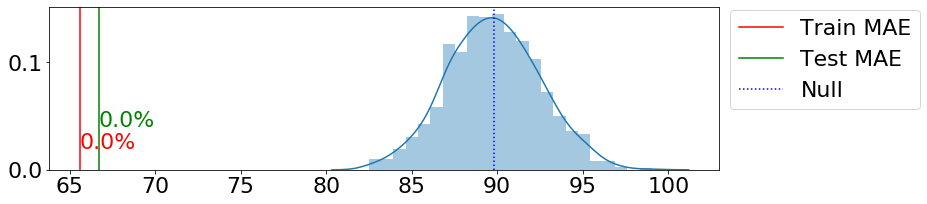

Model performance: 23.094577777777776


In [222]:
tst_mae = np.mean(np.abs(wrap360(estimated_color, tstf)))
# Reconstruct the stimulus:
estimated_color = np.full(cr_tst.shape[0],np.nan)
null_mae = np.full(1000,np.nan)
for perm in np.arange(1000):
    shuffled_tst = np.random.permutation(tst)
    cr_shuffle_tst = np.linalg.lstsq(channelweights_per_vox.T , shuffled_tst.T, rcond=None)[0].T
    for trial in np.arange(cr_shuffle_tst.shape[0]):
        estimated_color[trial] = basis_points[np.argmax(cr_shuffle_tst[trial,:])]

    null_mae[perm] = np.mean(np.abs(wrap360(estimated_color, tstf)))

trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae) * 100
tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae) * 100

sns.distplot(null_mae)
plt.axvline(trn_mae,color='red',label="Train MAE")
plt.axvline(tst_mae,color='green',label="Test MAE")
plt.axvline(np.mean(null_mae),linestyle=':',color='blue',label="Null")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.text(trn_mae,.02,"{:.1f}%".format(trn_overlap),color='red')
plt.text(tst_mae,.04,"{:.1f}%".format(tst_overlap),color='green')
plt.show()

print("Model performance: {}".format(np.mean(null_mae - tst_mae)/1))

## Informed Basis (shared precision)

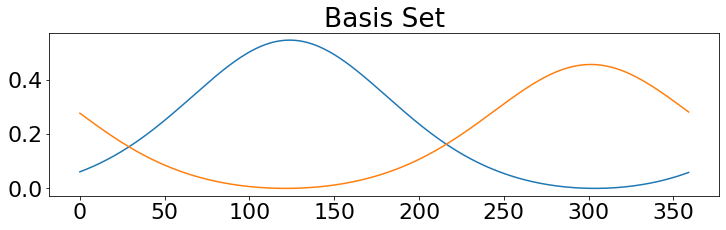

In [590]:
nchannels=2
# Plot chosen basis set

basis_set = make_vonmises_iter(np.linspace(0,359,360),
#          [130.67,321.88],
         [circmean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)],
         np.mean(posterior['sd_deg'])*np.ones(nchannels),
#          [np.mean(posterior['sd_deg_{}'.format(chan)]) for chan in range(nchannels)],
         sumfix([np.mean(posterior['p'][:,chan]) for chan in range(nchannels)]))
basis_points = [circmean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
# basis_points = [130.67,321.88]
basis_sds = np.mean(posterior['sd_deg'])*np.ones(nchannels)
# basis_sds = [np.mean(posterior['sd_deg_{}'.format(chan)]) for chan in range(nchannels)]

plt.plot(basis_set[:,:])
plt.title('Basis Set') 
# plt.ylabel('');plt.yticks([]);plt.xlabel('')
# plt.ylim([basis_set[0,-1],np.max(basis_set)])
# plt.savefig('prior.eps', format='eps', dpi=300)
plt.show()

# # Plot actual voxel tunings:
# for vox in np.arange(nvoxels):
#     if vox <= 25:
#         plt.scatter(trial_features,trial_by_vox[:,vox])
# plt.xlabel('Color')
# plt.ylabel('Response')
# plt.yticks([0,np.max(trial_by_vox[:,vox])//2,np.max(trial_by_vox[:,vox])], [0,1])
# plt.title('First 25 Voxel Responses')
# plt.show()

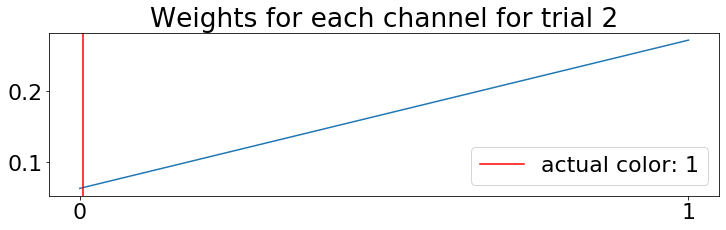

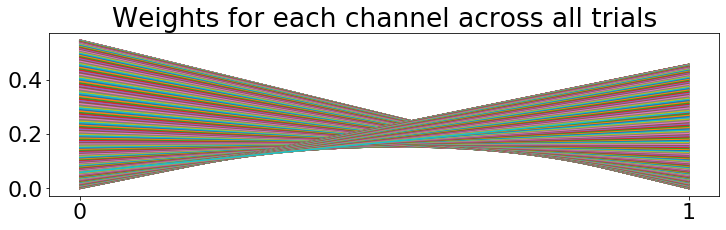

In [591]:
trial_weights = basis_set[trial_features,:]

trial = 1
plt.plot(trial_weights[trial,:])
plt.title("Weights for each channel for trial {}".format(trial+1))
#np.where(basis_points==trial_features[trial])[0][0]
plt.axvline(trial_features[trial]/360 * nchannels,color='red',label="actual color: {}".format(trial_features[trial]))
plt.xticks(np.arange(nchannels))
plt.legend()
plt.show()

for trial in np.arange(ntrials):
    plt.plot(trial_weights[trial,:])
plt.xticks(np.arange(nchannels))
plt.title('Weights for each channel across all trials')
plt.show()

### Test if channels are linearly dependent
Test to see if we have a full rank design matrix (tests if channels are linearly dependent). Linearly dependent channels are bad because it means that at least one of the channels can be defined as a linear combination of the others. This is bad because then we can't uniquely estimate the contribution of each channel to the signal observed in a given voxel. In other words, if trail_weights is not full rank then we have effectively lost the contribution of at least one of the nchannel dimensions.

In [230]:
print('Design matrix: rank = {}'.format( np.linalg.matrix_rank(trial_weights) ))
if np.linalg.matrix_rank(trial_weights) != nchannels:
    raise Exception('trial_weights not full rank')

Design matrix: rank = 2


### Compute weights of forward model

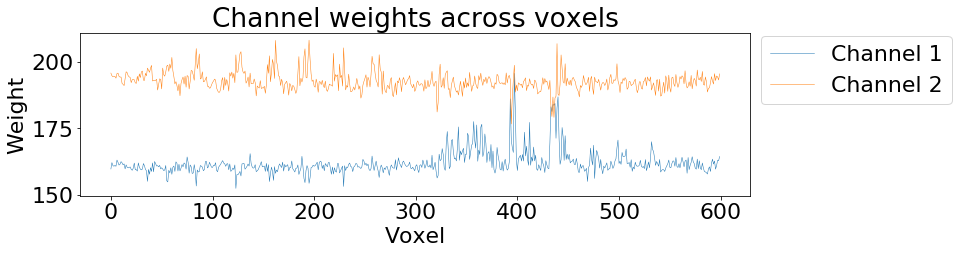

In [592]:
# Define training/testing trials
trn = trial_by_vox[np.isin(np.arange(ntrials),np.unique(train_vox_trial)),:]
trnf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(train_vox_trial))]
tst = trial_by_vox[np.isin(np.arange(ntrials),np.unique(test_vox_trial)),:]
tstf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(test_vox_trial))]
trn_or_tst = np.hstack((np.full( len(trn) , 0), np.full( len(tst) , 1)))

# trn = trial_by_vox[:ntrials//2,:] # training: trial "Betas"
# trnf = np.array(trial_features[:ntrials//2]) # training trial features
# tst = trial_by_vox[ntrials//2:,:] # testing: trial "Betas"
# tstf = np.array(trial_features[ntrials//2:]) # test trial features
# trn_or_tst = np.hstack((np.full( len(trn) , 0), np.full( len(tst) , 1)))

channelweights_per_vox = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trn, rcond=None)[0] 
# solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

for chan in range(nchannels):
    plt.plot(channelweights_per_vox[chan,:].T,linewidth=.5,label="Channel " + str(chan+1));
plt.title('Channel weights across voxels');
plt.xlabel("Voxel")
plt.ylabel("Weight")
plt.legend(bbox_to_anchor=(1, 1.05))

### Invert to compute channel responses

In [593]:
cr_trn = np.linalg.lstsq(channelweights_per_vox.T , trn.T, rcond=None)[0].T
cr_tst = np.linalg.lstsq(channelweights_per_vox.T , tst.T, rcond=None)[0].T


#### Reconstruct training data (note: this is circular, it should be near-perfect!)

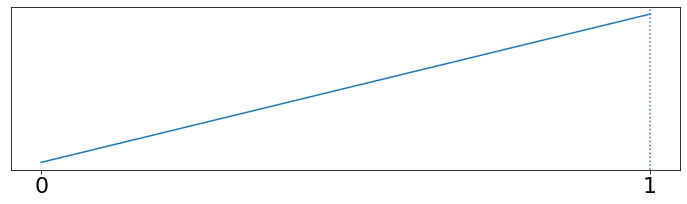

MAE: 64.06310776111111


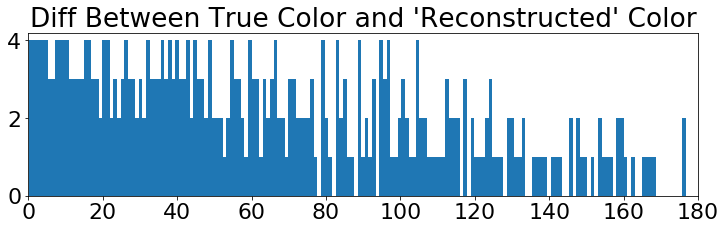

In [594]:
cr_center_trn = np.empty_like(cr_trn[:,:])
estimated_color = np.full(cr_center_trn.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_trn.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(trnf[trial],len(basis_points)), basis_points) ) )
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_trn[trial,:])]
    
plt.plot(np.mean(cr_center_trn,axis=0))
plt.axvline(shiftby,linestyle=":")
plt.ylabel('');plt.yticks([]);plt.xlabel('');plt.xticks(np.arange(nchannels))
# plt.savefig('img/trainrecon.eps', format='eps', dpi=300)
plt.show()

plt.hist(np.abs(wrap360(estimated_color, trnf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")

trn_mae = np.mean(np.abs(wrap360(estimated_color, trnf)))
print("MAE: {}".format(trn_mae))

MAE: 64.06310776111111
NEW MAE: 64.02222222222223
LK MAE: 84.85833333333333


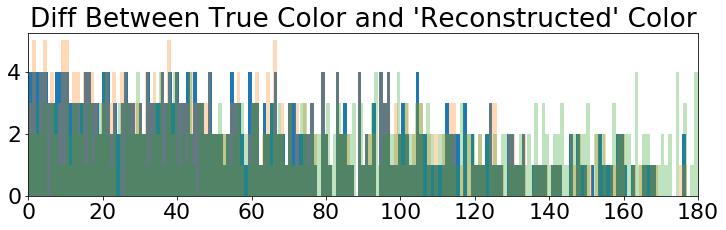

In [595]:
cr_center_trn = np.empty_like(cr_trn[:,:])
estimated_color = np.full(cr_center_trn.shape[0],np.nan)
estimated_color_new = np.full(cr_center_trn.shape[0],np.nan)
estimated_color_lk = np.full(cr_center_trn.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_trn.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(trnf[trial],len(basis_points)), basis_points) ) )
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - closest_basis );
    bs=make_vonmises_iter(np.linspace(0,359,360),
                        basis_points,
                        basis_sds,
                        cr_trn[trial,:])
    estimated_color_new[trial] = np.argmax(np.sum(bs,axis=1))
    estimated_color[trial] = basis_points[np.argmax(cr_trn[trial,:])]
    estimated_color_lk[trial] = np.argmax([np.corrcoef(cr_trn[trial,:],basis_set[f,:])[0][1] for f in range(360)])

plt.hist(np.abs(wrap360(estimated_color, trnf)), bins=180, label="")
trn_mae = np.mean(np.abs(wrap360(estimated_color, trnf)))
print("MAE: {}".format(trn_mae))

plt.hist(np.abs(wrap360(estimated_color_new, trnf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
trn_mae = np.mean(np.abs(wrap360(estimated_color_new, trnf)))
print("NEW MAE: {}".format(trn_mae))

plt.hist(np.abs(wrap360(estimated_color_lk, trnf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
trn_mae = np.mean(np.abs(wrap360(estimated_color_lk, trnf)))
print("LK MAE: {}".format(trn_mae))


trn_mae = np.mean(np.abs(wrap360(estimated_color_new, trnf)))

#### Reconstruct test data

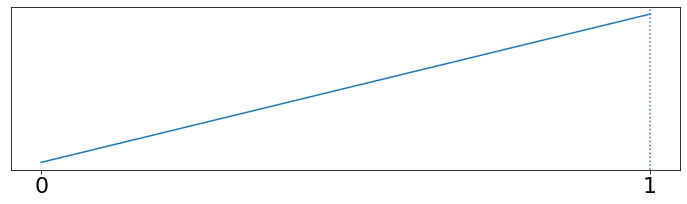

MAE: 62.55652456111111


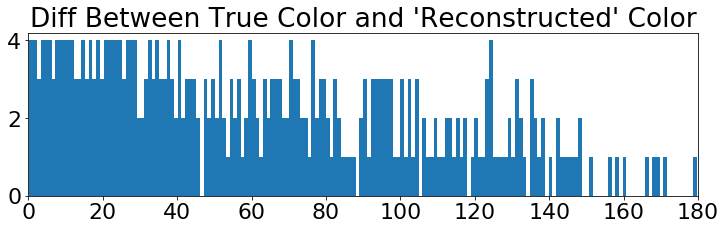

In [596]:
cr_center_tst = np.empty_like(cr_tst[:,:])
estimated_color = np.full(cr_center_tst.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_tst.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(tstf[trial],len(basis_points)), basis_points) ) )
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]
    
plt.plot(np.mean(cr_center_tst,axis=0))
plt.axvline(shiftby,linestyle=":")
plt.ylabel('');plt.yticks([]);plt.xlabel('');plt.xticks(np.arange(nchannels))
# plt.savefig('img/testrecon.eps', format='eps', dpi=300)
plt.show()

plt.hist(np.abs(wrap360(estimated_color, tstf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")

tst_mae = np.mean(np.abs(wrap360(estimated_color, tstf)))
print("MAE: {}".format(tst_mae))

MAE: 62.55652456111111
NEW MAE: 62.547222222222224
LK MAE: 83.94722222222222


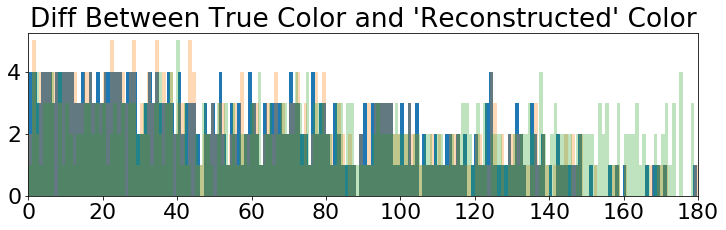

In [597]:
cr_center_tst = np.empty_like(cr_tst[:,:])
estimated_color = np.full(cr_center_tst.shape[0],np.nan)
estimated_color_new = np.full(cr_center_tst.shape[0],np.nan)
estimated_color_lk = np.full(cr_center_tst.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_tst.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(tstf[trial],len(basis_points)), basis_points) ) )
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - closest_basis );
    bs=make_vonmises_iter(np.linspace(0,359,360),
                        basis_points,
                        basis_sds,
                        cr_tst[trial,:])
    estimated_color_new[trial] = np.argmax(np.sum(bs,axis=1))
    estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]
    estimated_color_lk[trial] = np.argmax([np.corrcoef(cr_tst[trial,:],basis_set[f,:])[0][1] for f in range(360)])

plt.hist(np.abs(wrap360(estimated_color, tstf)), bins=180, label="")
tst_mae = np.mean(np.abs(wrap360(estimated_color, tstf)))
print("MAE: {}".format(tst_mae))

plt.hist(np.abs(wrap360(estimated_color_new, tstf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
tst_mae = np.mean(np.abs(wrap360(estimated_color_new, tstf)))
print("NEW MAE: {}".format(tst_mae))

plt.hist(np.abs(wrap360(estimated_color_lk, tstf)), bins=180, alpha=.3, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
tst_mae = np.mean(np.abs(wrap360(estimated_color_lk, tstf)))
print("LK MAE: {}".format(tst_mae))


tst_mae = np.mean(np.abs(wrap360(estimated_color_new, tstf)))

#### Null Distribution / Significance Test

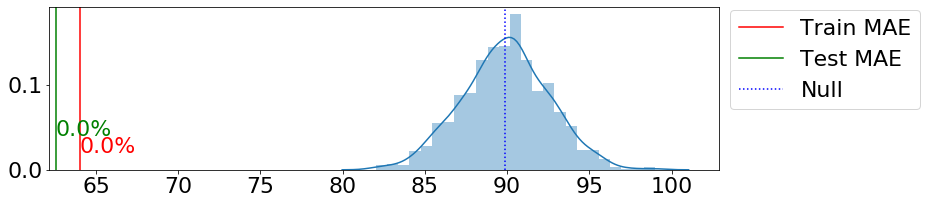

Model performance: 27.350767792033334


In [598]:
# Reconstruct the stimulus:
estimated_color = np.full(cr_tst.shape[0],np.nan)
null_mae = np.full(1000,np.nan)
for perm in np.arange(1000):
    shuffled_tst = np.random.permutation(tst)
    cr_shuffle_tst = np.linalg.lstsq(channelweights_per_vox.T , shuffled_tst.T, rcond=None)[0].T
    for trial in np.arange(cr_shuffle_tst.shape[0]):
        estimated_color[trial] = basis_points[np.argmax(cr_shuffle_tst[trial,:])]

    null_mae[perm] = np.mean(np.abs(wrap360(estimated_color, tstf)))

trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae) * 100
tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae) * 100

sns.distplot(null_mae)
plt.axvline(trn_mae,color='red',label="Train MAE")
plt.axvline(tst_mae,color='green',label="Test MAE")
plt.axvline(np.mean(null_mae),linestyle=':',color='blue',label="Null")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.text(trn_mae,.02,"{:.1f}%".format(trn_overlap),color='red')
plt.text(tst_mae,.04,"{:.1f}%".format(tst_overlap),color='green')
plt.show()

print("Model performance: {}".format(np.mean(null_mae - tst_mae)/1))

## FULL IEM (no unif)

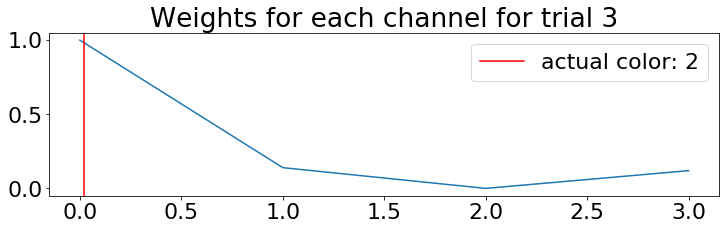

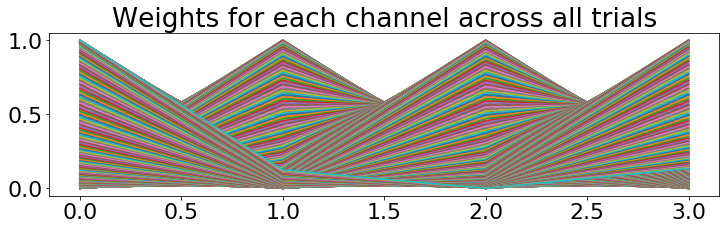

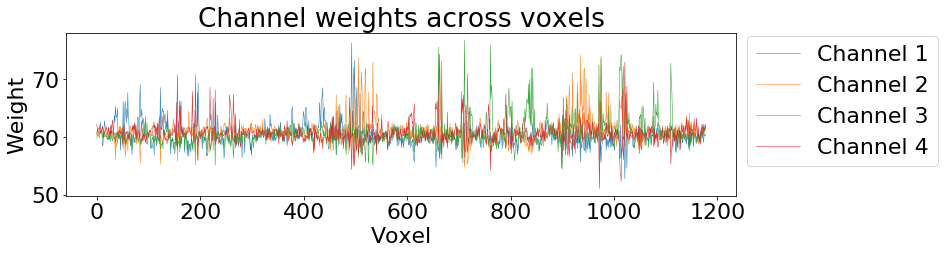

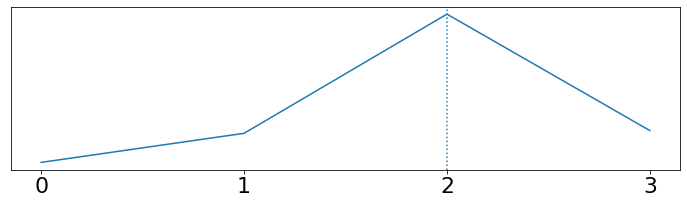

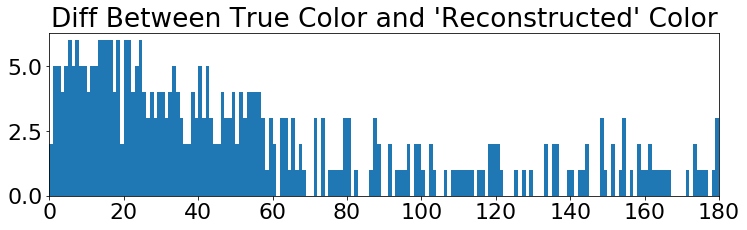

MAE: 55.03333333333333


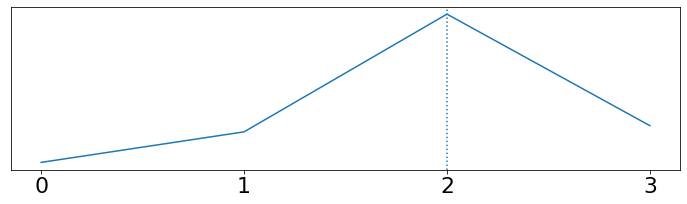

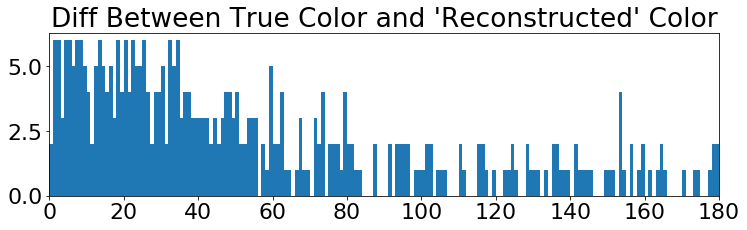

MAE: 54.73888888888889


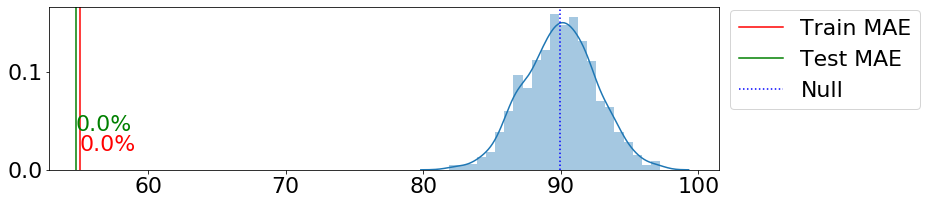

Model performance: 35.22610555555556


In [263]:
trial_weights = basis_set[trial_features,:]

trial = 2
plt.plot(trial_weights[trial,:])
plt.title("Weights for each channel for trial {}".format(trial+1))
#np.where(basis_points==trial_features[trial])[0][0]
plt.axvline(trial_features[trial]/360 * nchannels,color='red',label="actual color: {}".format(trial_features[trial]))
plt.legend()
plt.show()

for trial in np.arange(ntrials):
    plt.plot(trial_weights[trial,:])
plt.title('Weights for each channel across all trials')
plt.show()

# Define training/testing trials
trn = trial_by_vox[np.isin(np.arange(ntrials),np.unique(train_vox_trial)),:]
trnf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(train_vox_trial))]
tst = trial_by_vox[np.isin(np.arange(ntrials),np.unique(test_vox_trial)),:]
tstf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(test_vox_trial))]
trn_or_tst = np.hstack((np.full( len(trn) , 0), np.full( len(tst) , 1)))

channelweights_per_vox = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trn, rcond=None)[0] 
# solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full ran

for chan in range(nchannels):
    plt.plot(channelweights_per_vox[chan,:].T,linewidth=.5,label="Channel " + str(chan+1));
plt.title('Channel weights across voxels');
plt.xlabel("Voxel")
plt.ylabel("Weight")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.show()

cr_trn = np.linalg.lstsq(channelweights_per_vox.T , trn.T, rcond=None)[0].T
cr_tst = np.linalg.lstsq(channelweights_per_vox.T , tst.T, rcond=None)[0].T

cr_center_trn = np.empty_like(cr_trn)
estimated_color = np.full(cr_center_trn.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_trn.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(trnf[trial],len(basis_points)), basis_points) ) )
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_trn[trial,:-1])]
    
plt.plot(np.mean(cr_center_trn,axis=0))
plt.axvline(shiftby,linestyle=":")
plt.ylabel('');plt.yticks([]);plt.xlabel('');plt.xticks(np.arange(nchannels))
# plt.savefig('img/trainrecon.eps', format='eps', dpi=300)
plt.show()

plt.hist(np.abs(wrap360(estimated_color, trnf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
plt.show()

trn_mae = np.mean(np.abs(wrap360(estimated_color, trnf)))
print("MAE: {}".format(trn_mae))

cr_center_tst = np.empty_like(cr_tst)
estimated_color = np.full(cr_center_tst.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_tst.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(tstf[trial],len(basis_points)), basis_points) ) )
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:-1])]
    
plt.plot(np.mean(cr_center_tst,axis=0))
plt.axvline(shiftby,linestyle=":")
plt.ylabel('');plt.yticks([]);plt.xlabel('');plt.xticks(np.arange(nchannels))
# plt.savefig('img/testrecon.eps', format='eps', dpi=300)
plt.show()

plt.hist(np.abs(wrap360(estimated_color, tstf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
plt.show()

tst_mae = np.mean(np.abs(wrap360(estimated_color, tstf)))
print("MAE: {}".format(tst_mae))

# Reconstruct the stimulus:
estimated_color = np.full(cr_tst.shape[0],np.nan)
null_mae = np.full(1000,np.nan)
for perm in np.arange(1000):
    shuffled_tst = np.random.permutation(tst)
    cr_shuffle_tst = np.linalg.lstsq(channelweights_per_vox.T , shuffled_tst.T, rcond=None)[0].T
    for trial in np.arange(cr_shuffle_tst.shape[0]):
        estimated_color[trial] = basis_points[np.argmax(cr_shuffle_tst[trial,:-1])]

    null_mae[perm] = np.mean(np.abs(wrap360(estimated_color, tstf)))

trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae) * 100
tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae) * 100

sns.distplot(null_mae)
plt.axvline(trn_mae,color='red',label="Train MAE")
plt.axvline(tst_mae,color='green',label="Test MAE")
plt.axvline(np.mean(null_mae),linestyle=':',color='blue',label="Null")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.text(trn_mae,.02,"{:.1f}%".format(trn_overlap),color='red')
plt.text(tst_mae,.04,"{:.1f}%".format(tst_overlap),color='green')
plt.show()

print("Model performance: {}".format(np.mean(null_mae - tst_mae)/1))

## FULL IEM (unif)

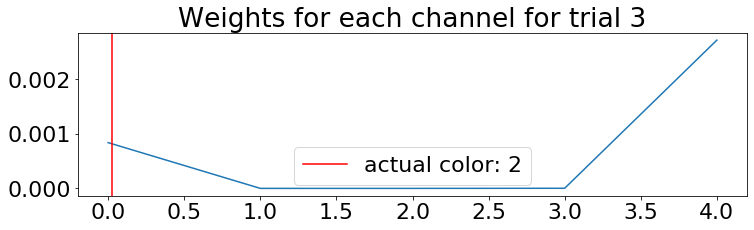

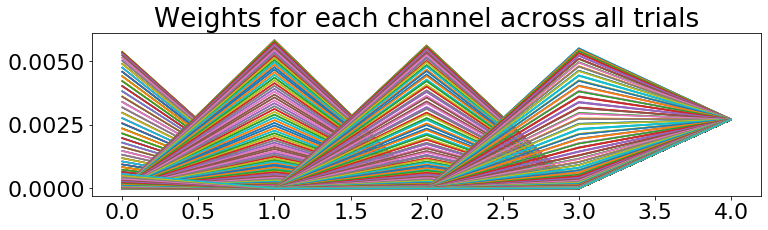

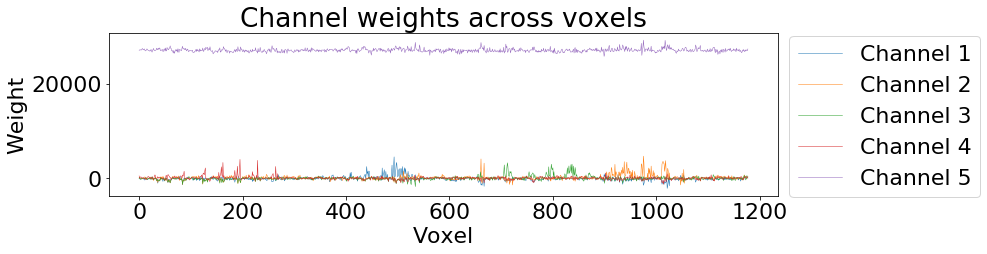

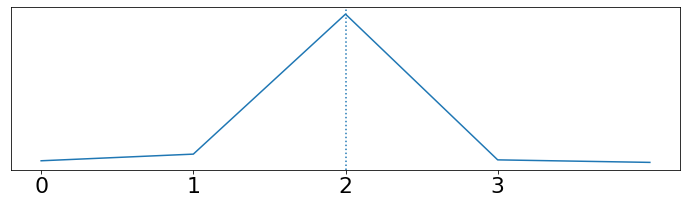

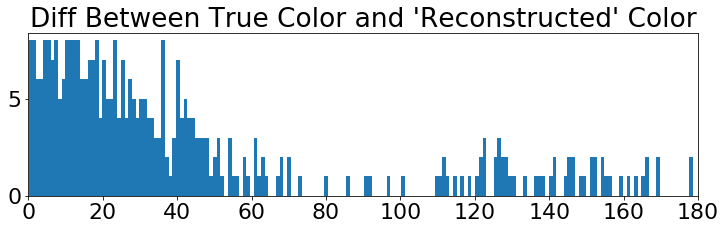

MAE: 43.695505181045405


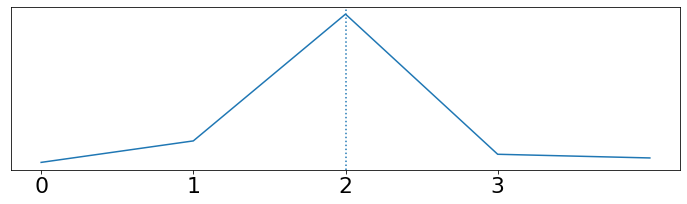

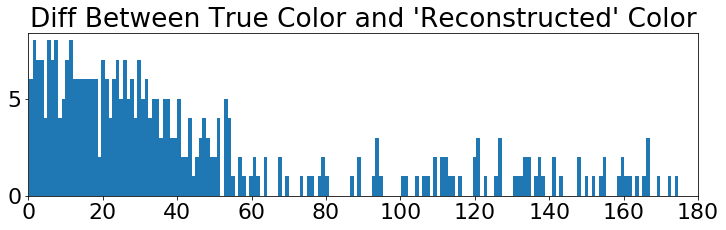

MAE: 45.1846651832702


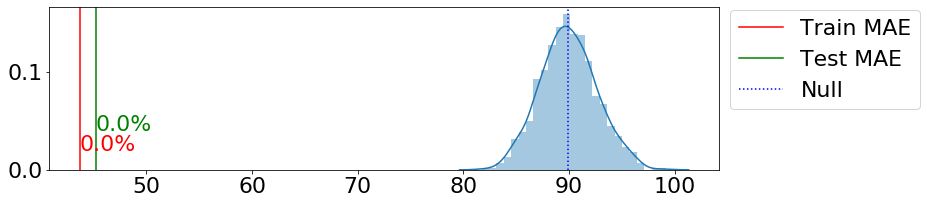

Model performance: 44.759848011197974


In [63]:
trial_weights = basis_set[trial_features,:]

trial = 2
plt.plot(trial_weights[trial,:])
plt.title("Weights for each channel for trial {}".format(trial+1))
#np.where(basis_points==trial_features[trial])[0][0]
plt.axvline(trial_features[trial]/360 * nchannels,color='red',label="actual color: {}".format(trial_features[trial]))
plt.legend()
plt.show()

for trial in np.arange(ntrials):
    plt.plot(trial_weights[trial,:])
plt.title('Weights for each channel across all trials')
plt.show()

# Define training/testing trials
trn = trial_by_vox[np.isin(np.arange(ntrials),np.unique(train_vox_trial)),:]
trnf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(train_vox_trial))]
tst = trial_by_vox[np.isin(np.arange(ntrials),np.unique(test_vox_trial)),:]
tstf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(test_vox_trial))]
trn_or_tst = np.hstack((np.full( len(trn) , 0), np.full( len(tst) , 1)))

channelweights_per_vox = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trn, rcond=None)[0] 
# solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

for chan in range(channelweights_per_vox.shape[0]):
    plt.plot(channelweights_per_vox[chan,:].T,linewidth=.5,label="Channel " + str(chan+1));
plt.title('Channel weights across voxels');
plt.xlabel("Voxel")
plt.ylabel("Weight")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.show()

cr_trn = np.linalg.lstsq(channelweights_per_vox.T , trn.T, rcond=None)[0].T
cr_tst = np.linalg.lstsq(channelweights_per_vox.T , tst.T, rcond=None)[0].T

cr_center_trn = np.empty_like(cr_trn)
estimated_color = np.full(cr_center_trn.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_trn.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(trnf[trial],len(basis_points)), basis_points) ) )
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_trn[trial,:-1])]
    
plt.plot(np.mean(cr_center_trn,axis=0))
plt.axvline(shiftby,linestyle=":")
plt.ylabel('');plt.yticks([]);plt.xlabel('');plt.xticks(np.arange(nchannels))
# plt.savefig('img/trainrecon.eps', format='eps', dpi=300)
plt.show()

plt.hist(np.abs(wrap360(estimated_color, trnf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
plt.show()

trn_mae = np.mean(np.abs(wrap360(estimated_color, trnf)))
print("MAE: {}".format(trn_mae))

cr_center_tst = np.empty_like(cr_tst)
estimated_color = np.full(cr_center_tst.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_tst.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(tstf[trial],len(basis_points)), basis_points) ) )
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:-1])]
    
plt.plot(np.mean(cr_center_tst,axis=0))
plt.axvline(shiftby,linestyle=":")
plt.ylabel('');plt.yticks([]);plt.xlabel('');plt.xticks(np.arange(nchannels))
# plt.savefig('img/testrecon.eps', format='eps', dpi=300)
plt.show()

plt.hist(np.abs(wrap360(estimated_color, tstf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")
plt.show()

tst_mae = np.mean(np.abs(wrap360(estimated_color, tstf)))
print("MAE: {}".format(tst_mae))

# Reconstruct the stimulus:
estimated_color = np.full(cr_tst.shape[0],np.nan)
null_mae = np.full(1000,np.nan)
for perm in np.arange(1000):
    shuffled_tst = np.random.permutation(tst)
    cr_shuffle_tst = np.linalg.lstsq(channelweights_per_vox.T , shuffled_tst.T, rcond=None)[0].T
    for trial in np.arange(cr_shuffle_tst.shape[0]):
        estimated_color[trial] = basis_points[np.argmax(cr_shuffle_tst[trial,:-1])]

    null_mae[perm] = np.mean(np.abs(wrap360(estimated_color, tstf)))

trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae) * 100
tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae) * 100

sns.distplot(null_mae)
plt.axvline(trn_mae,color='red',label="Train MAE")
plt.axvline(tst_mae,color='green',label="Test MAE")
plt.axvline(np.mean(null_mae),linestyle=':',color='blue',label="Null")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.text(trn_mae,.02,"{:.1f}%".format(trn_overlap),color='red')
plt.text(tst_mae,.04,"{:.1f}%".format(tst_overlap),color='green')
plt.show()

print("Model performance: {}".format(np.mean(null_mae - tst_mae)/1))

# Compare With MVPA

Let's say we want to decode (e.g., classify) whether there is signal in our ROI that is different for conditions 1 and 2. Given all the voxels we have from half our dataset, can we decode above chance whether a trial was condition 1 or 2?

In [118]:
trn = trial_by_vox[:ntrials//2,:]
trn_cond = trial_conds[:ntrials//2]
trnf = trial_features[:ntrials//2]

tst = trial_by_vox[ntrials//2:,:]
tst_cond = trial_conds[ntrials//2:]
tstf = trial_features[ntrials//2:]

normalizer = StandardScaler()
trn = normalizer.fit_transform(trn)
tst = normalizer.fit_transform(tst)

In [119]:
model = LinearSVC(C=1)

model.fit(trn, trn_cond)

score = model.score(tst, tst_cond)
print('Accuracy = {}'.format(score))
print('Chance = 0.50')

Accuracy = 0.5133333333333333
Chance = 0.50


What if we want to decode the actual color?

MAE: 63.38666666666666


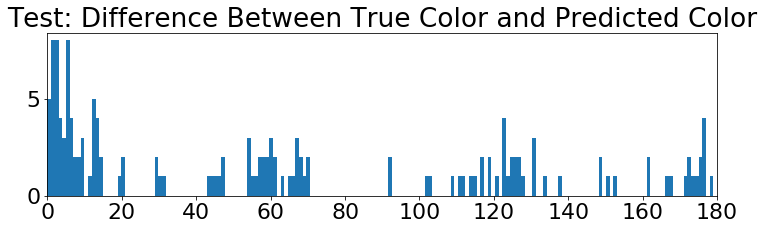

In [122]:
model.fit(trn, trnf)

predictions = model.predict(tst)

plt.hist(np.abs(wrap360(predictions, tstf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Test: Difference Between True Color and Predicted Color")

tst_mae = np.mean(np.abs(wrap360(predictions, tstf)))
print("MAE: {}".format(tst_mae))

# List Of Models

## Individual Precisions

# scratch

In [ ]:
samps=5000
X = np.full((samps,nvoxels),np.nan)
for v in range(nvoxels):
    x = train_vox_betas[train_vox_features==f]/np.sum(train_vox_betas[train_vox_features==f])
    x = x + (1-np.sum(x))/len(x) # ensure sums to 1
    X[:,v] = inverse_transform(x)
X = np.deg2rad(X)-np.pi

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

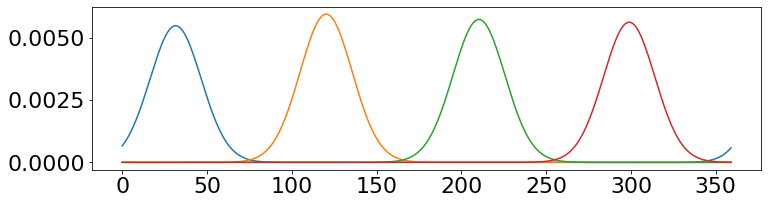

In [287]:
nchannels=4
basis_set=np.full((360,nchannels+1),np.nan)
basis_set = make_vonmises_iter_unif(np.linspace(0,359,360),
         [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)],
         [np.mean(posterior['sd_deg_{}'.format(chan)]) for chan in range(nchannels)],
          np.mean(posterior['p'][:,nchannels]),
         [np.mean(posterior['p'][:,chan]) for chan in range(nchannels)])
basis_points = [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]

print(np.sum(basis_set,axis=1))

plt.plot(basis_set[:,:-1])
trial_weights = basis_set[trial_features,:]

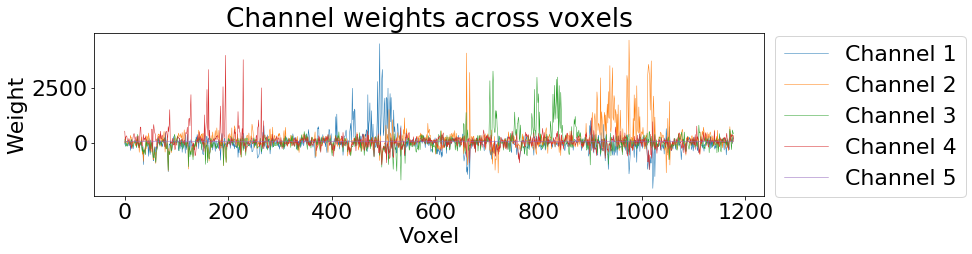

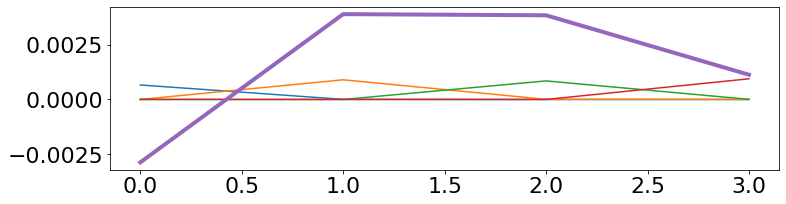

1.074603385433484
188.0


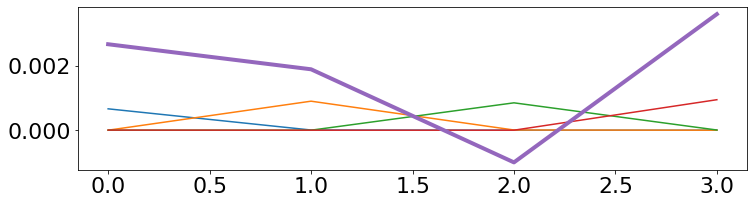

0.9394682428296564
6.0


In [502]:
# Define training/testing trials
trn = trial_by_vox[np.isin(np.arange(ntrials),np.unique(train_vox_trial)),:]
trnf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(train_vox_trial))]
tst = trial_by_vox[np.isin(np.arange(ntrials),np.unique(test_vox_trial)),:]
tstf = trial_by_feature[np.isin(np.arange(ntrials),np.unique(test_vox_trial))]
trn_or_tst = np.hstack((np.full( len(trn) , 0), np.full( len(tst) , 1)))

channelweights_per_vox = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trn, rcond=None)[0] 
# solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

for chan in range(channelweights_per_vox.shape[0]):
    plt.plot(channelweights_per_vox[chan,:].T,linewidth=.5,label="Channel " + str(chan+1));
plt.title('Channel weights across voxels');
plt.xlabel("Voxel")
plt.ylabel("Weight")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.show()

cr_trn = np.linalg.lstsq(channelweights_per_vox.T , trn.T, rcond=None)[0].T
cr_tst = np.linalg.lstsq(channelweights_per_vox.T , tst.T, rcond=None)[0].T

plt.plot(basis_set[np.arange(0,360,90),:-1])
plt.plot(cr_trn[282,:-1],linewidth=4)
plt.show()
print(np.sum(cr_trn[282,:]))
print(np.round(circmean(basis_points,weights=cr_trn[282,:-1])))

plt.plot(basis_set[np.arange(0,360,90),:-1])
plt.plot(cr_trn[311,:-1],linewidth=4)
plt.show()
print(np.sum(cr_trn[311,:]))
print(np.round(circmean(basis_points,weights=cr_trn[311,:-1])))

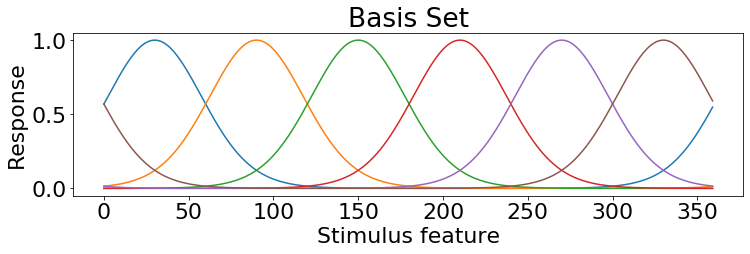

In [231]:
# Plot chosen basis set
plt.plot(make_vonmises_iter(np.linspace(0,359,360),np.array([0,60,120,180,240,300])+30,np.ones(nchannels)*30,np.ones(nchannels)))
plt.title('Basis Set') 
plt.ylabel('Response')
plt.xlabel('Stimulus feature')
plt.show()

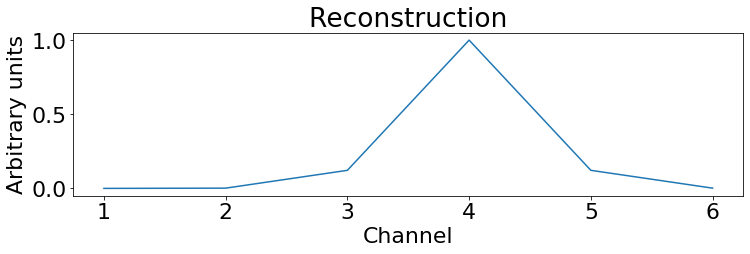

In [63]:
# Plot chosen basis set
a=make_vonmises(np.linspace(0,359,360),360/2,np.ones(1)*30)
plt.plot(np.linspace(1,6,6),a[[0,60,120,180,240,300]])
plt.title('Reconstruction') 
plt.ylabel('Arbitrary units')
plt.xlabel("Channel")
plt.show()

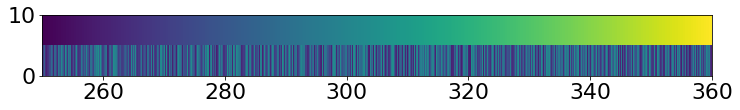

In [70]:
plt.imshow([np.linspace(0,720,720),trial_features], extent=[250,360,0,10])
# plt.axis('off')

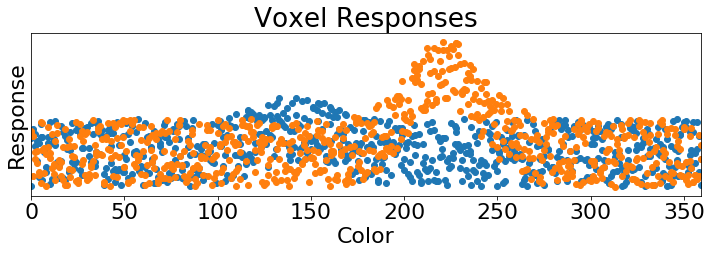

In [261]:
# Plot actual voxel tunings:
for vox in np.arange(nvoxels):
    if vox < 3:
        plt.scatter(trial_features,trial_by_vox[:,vox])
plt.xlabel('Color')
plt.ylabel('Response')
plt.yticks([]); plt.xlim([0,359])
plt.title('Voxel Responses')
plt.show()

In [97]:
save_obj([vox_dist, trial_features, trial_conds, vox_betas, features, trial_by_vox, obs], 'save_data')

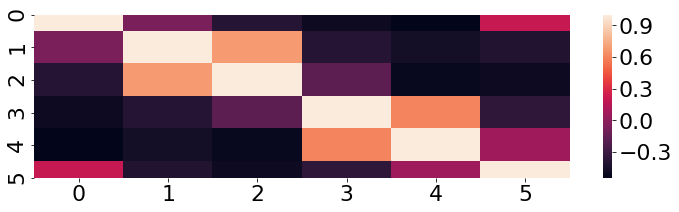

In [115]:
sns.heatmap(np.corrcoef(trial_by_vox[0:359:60,:]))


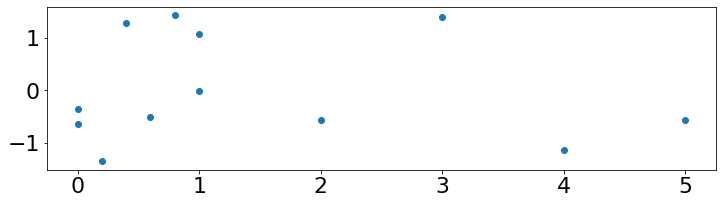

In [149]:
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)

X_mds = clf.fit_transform(np.corrcoef(trial_by_vox[0:359:60,:]))

plt.scatter([np.linspace(0,1,6),np.linspace(0,5,6)],X_mds)